In [1]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import os
import re
import matplotlib.pyplot as plt
import networkx as nx
from sklearn import covariance
from sklearn.covariance import GraphicalLassoCV
from sklearn.preprocessing import MinMaxScaler
import matplotlib.colors as mcolors
import ot
from itertools import combinations
from scipy.spatial import distance_matrix
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.neighbors import kneighbors_graph
from sklearn.metrics import roc_auc_score, average_precision_score, precision_score, recall_score, f1_score
import random
from sklearn.metrics import mean_absolute_error, mean_squared_error
import cvxpy as cp
import haversine as hs
from haversine import Unit
import geopandas as gpd
import matplotlib as mpl

## Experiment 2: infer a graph with real data (PAM) and apply stability.

In [3]:
#for Kalofolias
import pygsp
from scipy import spatial
import utils
import learn_graph as lg
from pyunlocbox import functions, solvers
import time
from sklearn import metrics



• lg.log_degree_barrier  
• construct_P  
• optimize_A_tilde  
• calculate_nmse  
• remap_A_tilde     
• plot_network  -- original one   
• plot_graph_   -- node dropout   
• same_posicion_data(df_info)  
• df_norm       -- DataFrame (N×F) acoustic structures  
• df_info       -- DataFrame site information -'Habitat'  


In [4]:
def infer_graph_kalofolias(X, dist_type='correlation', alpha=0.1, beta=1.0):
    """
    X: (N,F) array of signals
    dist_type: 'sqeuclidean' or 'correlation'
    alpha, beta: hyperparámetros de log_degree_barrier
    """
    W_learned, _ = lg.log_degree_barrier(
        X, dist_type=dist_type,
        alpha=alpha, beta=beta,
        retall=True, verbosity='LOW'
    )
    return np.array(W_learned)

In [5]:
def same_posicion_data(df):
  gps_point = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitude, df.latitude)) #objeto geometrico para respetar posiciones
  coordinates = np.column_stack((gps_point.geometry.x, gps_point.geometry.y))
  return coordinates

In [123]:
def plot_network(matrix, threshold, same_position_data_func, df_info):
    # Prepare data
    links = matrix.stack().reset_index()
    links.columns = ['var1', 'var2', 'value']
    links2 = matrix.stack().reset_index()
    links2.columns = ['var1', 'var2', 'value']

    links = links.loc[(abs(links['value']) >= threshold) & (links['var1'] != links['var2'])]
    links2 = links2.loc[(links2['var1'] != links2['var2'])]

    # Create graph
    G = nx.from_pandas_edgelist(links, 'var1', 'var2', edge_attr='value', create_using=nx.Graph())

    all_nodes = pd.Series(pd.concat([links2['var1'], links2['var2']])).unique()

    # Create a complete graph with all nodes
    G_complete = nx.complete_graph(all_nodes)

    # Nodes position and colors
    coordinates = same_position_data_func(df_info)
    coordinates = coordinates[G_complete.nodes]
    colores = df_info.Habitat.values[G_complete.nodes]
    positions = dict(zip(G_complete.nodes, coordinates))

    # Edge weights
    edge_weights = [abs(G[u][v]['value']) for u, v in G.edges()]

    plt.figure(figsize=(10, 8))

    node_size = 1400
    node_color = colores
    node_border_color = 'white'
    node_border_width = 0
    node_labels = {node: node for node in G_complete.nodes()}
    nx.draw_networkx_nodes(G_complete, positions, nodelist=G_complete.nodes(), node_size=node_size, node_color=node_color,
                           linewidths=node_border_width, edgecolors=node_border_color, cmap="summer_r")
    nx.draw_networkx_labels(G_complete, positions, labels=node_labels, font_color='black')

    min_width = 1
    max_width = 5
    scaled_widths = [(w - min(edge_weights)) / (max(edge_weights) - min(edge_weights)) * (max_width - min_width) + min_width for w in edge_weights]

    # Plot final graph
    nx.draw_networkx_edges(G, positions, width=scaled_widths, edge_color="darkblue", alpha=0.8)
    plt.savefig("grafo.svg", format="svg")
    
    plt.show()
    
    return G, G_complete


In [7]:
# Function to build P by removing a specific node
def construct_P(N, s):
    return np.delete(np.eye(N), s, axis=0)
    
# Fill in the reconstructed matrix in its original position.
def remap_A_hat(Atil_small, removed):
    """
    Given the reconstructed matrix Atil_small of size (N-1)x(N-1),
    reconstruct the matrix of size N×N by inserting rows/columns of zeros in ‘removed
    """
    N_minus_1 = Atil_small.shape[0]
    N = N_minus_1 + 1
    A_hat = np.zeros((N, N))
    idx = list(range(N))
    idx.pop(removed)

    for i_small, i_big in enumerate(idx):
        for j_small, j_big in enumerate(idx):
            A_hat[i_big, j_big] = Atil_small[i_small, j_small]

    return A_hat

# Binarize a matrix
def binarize(A, eps=1e-8):
    """
    Binarize A: returns a matrix of the same size with 1 where |A[i,j]|>eps and 0 otherwise.
    """
    return (np.abs(A) > eps).astype(float)

# Masking a node in the matrix
def mask_node(A, removed):
    """
    Given A (N×N), resets the row and column ‘removed’ (simulates the deletion of that node).
    """
    M = A.copy()
    M[removed, :] = 0
    M[:, removed] = 0
    return M

def calculate_nmse_with_mask_and_binarize(Atil_small, A_full, removed, eps=1e-8):
    """
    1) Remap Atil_small to the original size N×N,
    2) Binarize A_hat and the masked,
    3) Calculate binarized NMSE || Ahat_bin - A_full_bin ||_F / || A_full_bin ||_F

    Return (nmse, A_hat_bin, A_full_bin).
    """
    A_hat = remap_A_hat(Atil_small, removed)
    A_hat_bin = binarize(A_hat, eps)

    A_full_masked = mask_node(A_full, removed)
    A_full_bin = binarize(A_full_masked, eps)
    
    diff = np.linalg.norm(A_hat_bin - A_full_bin, 'fro')
    normA = np.linalg.norm(A_full_bin, 'fro')
    return diff / normA, A_hat_bin, A_full_bin

In [8]:
def construct_P(N, s):
    return np.delete(np.eye(N), s, axis=0)

# optmization problem

def evaluate_graph_stability(A, X, P, lambda_reg):
    """
    Given A (N×N), X (N×F), P ((N-1)×N) and lambda_reg,
    Solve the optimization problem:
       min_{A_tilde, L_tilde}  trace(X_tilde^T L_tilde X_tilde) + lambda_reg * ||A_tilde - A_proj||_F
    s.t. A_tilde ≥0, diag(A_tilde)=0, L_tilde is Laplacian PSD, etc.

    Return A_tilde(N-1)×(N-1).
    """
    N_new = P.shape[0]  # Matrix new size (N-1)
    X_tilde = P @ X     # (N-1)×F
    A_proj = P @ A @ P.T  # (N-1)×(N-1)

    A_tilde = cp.Variable((N_new, N_new), symmetric=True)
    D_tilde = cp.diag(cp.sum(A_tilde, axis=1)) 
    L_tilde = cp.Variable((N_new, N_new), symmetric=True)

    objective = cp.trace(X_tilde.T @ L_tilde @ X_tilde) + lambda_reg * cp.norm(A_tilde - A_proj, 'fro')

    # constraints
    constraints = [
        A_tilde >= 0,  
        cp.diag(A_tilde) == 0,  
        L_tilde @ np.ones((N_new, 1)) == 0,  
        L_tilde == D_tilde - A_tilde,
        L_tilde >> 0  # Equivalent to X >= 0 for PSD constraint
    ]
    # L_ij <= 0 para i != j
    for i in range(N_new):
        for j in range(N_new):
            if i != j:
                constraints.append(L_tilde[i, j] <= 0)

    problem = cp.Problem(cp.Minimize(objective), constraints)
    problem.solve(solver=cp.SCS, eps=1e-3)


    # non negative values
    A_sol = A_tilde.value
    A_sol = np.maximum(A_sol, 0.0)
    A_sol_np =np.array(A_sol)

    return A_sol_np

In [9]:
# fast version of the optimization problem
def evaluate_graph_stability_fast(
    A: np.ndarray,
    X: np.ndarray,
    P: np.ndarray,
    lambda_reg: float,
    eps: float = 1e-3
) -> np.ndarray:
    """
    Fast solver: minimize 0.5 * sum_{i,j} W_ij A_ij + λ ||A - A_proj||_F
    s.t. A >= 0, diag(A)=0.
    W_ij = ||x_i - x_j||^2 on the projected X.
    """
    # 1) project
    X_tilde = P @ X                       # (n-1)×F
    A_proj  = P @ A @ P.T                # (n-1)×(n-1)
    n = X_tilde.shape[0]

    # 2) build W
    diff = X_tilde[:, None, :] - X_tilde[None, :, :]  # (n-1,n-1,F)
    W_np = np.sum(diff**2, axis=2)                     # (n-1,n-1)

    # 3) variable
    A_tilde = cp.Variable((n, n), symmetric=True)

    # 4) objective
    obj = 0.5 * cp.sum(cp.multiply(W_np, A_tilde)) \
          + lambda_reg * cp.norm(A_tilde - A_proj, 'fro')

    # 5) constraints
    constr = [
        A_tilde >= 0,
        cp.diag(A_tilde) == 0
    ]

    # 6) solve
    prob = cp.Problem(cp.Minimize(obj), constr)
    prob.solve(solver=cp.SCS, eps=eps)

    A_sol = A_tilde.value
    return np.maximum(A_sol, 0.0)


In [ ]:
#function to plot and save the graph
mpl.rcParams['svg.fonttype'] = 'none'

def plot_graph_(W, df_info, pos_removed=None, removed_node=None, epsilon=1e-4,
                save_svg=False, out_dir=None, filename=None, show=True):
    """
    Dibuja el grafo y, si save_svg=True, guarda un .svg en out_dir/filename.
    Retorna (links_e, svg_path_or_None).
    """
    n = W.shape[0]

    links_e = pd.DataFrame(
        [(i, j, W.iloc[i, j])
         for i in range(n) for j in range(i+1, n) if W.iloc[i, j] >= epsilon],
        columns=['var1', 'var2', 'value']
    )

    G_e = nx.from_pandas_edgelist(links_e, 'var1', 'var2', edge_attr='value', create_using=nx.Graph())
    all_nodes_e = np.arange(n)
    G_complete_e = nx.complete_graph(all_nodes_e)


    coordinates = same_posicion_data(df_info)         
    coordinates = coordinates[G_complete_e.nodes]     
    colores     = df_info.Habitat.values[G_complete_e.nodes]
    positions   = dict(zip(G_complete_e.nodes, coordinates))
    node_labels = {node: node for node in G_complete_e.nodes()}

    fig, ax = plt.subplots(figsize=(10, 8))

    node_size         = 1400
    node_color        = colores
    node_border_color = 'white'
    node_border_width = 0

    nx.draw_networkx_nodes(
        G_complete_e, positions, nodelist=G_complete_e.nodes(),
        node_size=node_size, node_color=node_color,
        linewidths=node_border_width, edgecolors=node_border_color,
        cmap="summer_r", ax=ax
    )
    nx.draw_networkx_labels(G_complete_e, positions, labels=node_labels, font_color='black', ax=ax)

    edge_weights_e = [abs(G_e[u][v]['value']) for u, v in G_e.edges()]
    min_width, max_width = 1, 5
    if edge_weights_e and (max(edge_weights_e) - min(edge_weights_e)) != 0:
        scaled_widths_e = [
            (w - min(edge_weights_e)) / (max(edge_weights_e) - min(edge_weights_e)) * (max_width - min_width) + min_width
            for w in edge_weights_e
        ]
    else:
        scaled_widths_e = [1 for _ in edge_weights_e]

    nx.draw_networkx_edges(G_e, positions, width=scaled_widths_e, edge_color="darkblue", alpha=0.8, ax=ax)

    if pos_removed is not None and removed_node is not None:
        nx.draw_networkx_nodes(
            G_complete_e, {removed_node: pos_removed}, nodelist=[removed_node],
            node_size=node_size, node_color='gray',
            linewidths=node_border_width, edgecolors=node_border_color, ax=ax
        )

    ax.set_axis_off()

    
    svg_path = None
    if save_svg:
    
        default_dir = Path("/images")
        out_dir = Path(out_dir) if out_dir is not None else default_dir
        out_dir.mkdir(parents=True, exist_ok=True)

        if filename is None:
            base = "graph"
            if removed_node is not None:
                base += f"_drop{removed_node}"
            filename = base + ".svg"

        svg_path = out_dir / filename
        fig.savefig(svg_path, format="svg", bbox_inches="tight")

    if show:
        plt.show()
    else:
        plt.close(fig)

    return links_e, (str(svg_path) if svg_path is not None else None)


### Input data. PAM matrix - acoustic structures

In [ ]:
#  X
df1 = pd.read_excel(r'/Acoustic_structures.xlsx')
df2 = df1.iloc[:,1:]
df2

2      3     4     5    6      7     8      9     10    11   ...  346  \
0   2147   5991   965  2070   13  11267  2588  13203   370   372  ...  178   
1   1733   4502   637  2110   50   2307  1232   5179    91    65  ...  140   
2    640   5983   704  6192    0  13213   151   6781   900    54  ...  143   
3    450   6319   359  4335    0  10314   516   9410   627   289  ...  181   
4    391   9177   468  1416    0   2120   846   1809   213  1538  ...  214   
5    751   7728   330   675    2  12486   401   5930  1261  2072  ...   80   
6    776  12360  1500  1604    5  15887   692   8396  1237  2925  ...  168   
7    535   8602   490   543    1   5782   634   4752   760  1133  ...  192   
8    698   4911   252  2953   14   9522   647   6002   234  1487  ...  307   
9     52   4394    88     6    0   2430     8    513    68     0  ...  212   
10  1529   5626  2017  2442   30   9754  2989  10872   103   563  ...  174   
11   675  10070  1584   752    7   6725   606   3435   108   277  ...  214   
12  1045  13951   556  1334   15   6898   553   2925   224  1332  ...  127   
13    92   7360   424    68    7  10568  2485   8312   294   332  ...  925   
14   667   6076  2300  1092    6   4540  1461   4329    26   186  ...  264   
15   508  10067   449  4044    4   9431   772   4636   101  1948  ...  219   
16    30   7730   197    54    5   7925   328   5729   112   377  ...  292   

    348  349  351  352  353  354  355  356  358  
0    68   38   25   51   33    2    1    1   17  
1    99   37   54  129   43    0    0    1   21  
2   191   20   46   16   34    1    1    0   21  
3   147   42   39   80   33    1    1    3   32  
4   284   38  112   49  135    1    1    2   64  
5   245   32  153   64   48    5    4    2   41  
6   121   19   96  123   38   11    0    2   37  
7   102   30   95  114   87    8    0    1   29  
8   176   26   66   77   87    0    1    0   24  
9    93    4   50   80   23    0    0    3   18  
10  151   54   39   79   46    1    1    2   12  
11  262   36   70  139  129    2    2    2   73  
12   66   19   38   11  142    0    1    0   99  
13   84   67  133  293   43    8    4    1   64  
14   92   29   30  233    6    1    1    0    9  
15  137   57   84   48   64    3    2    1   40  
16   67   39  150  190   34    2    0    0   85  

[17 rows x 292 columns]

In [15]:
# site information (e.g., coordinates, habitat, etc.)
df = pd.read_excel(r'/Matrix_information.xlsx')
df

Point  latitude  longitude  Habitat  Site Recording Name
0   KLSA01   7.36574  -73.85669        1     0       SMA03286
1   KLSA02   7.36832  -73.86041        1     1       SMA03294
2   KLSA03   7.36765  -73.85181        2     2       SMA03332
3   KLSA04   7.36233  -73.85412        1     3       SMA03322
4   KLSA05   7.36389  -73.86101        3     4       SMA03210
5   KLSA06   7.36238  -73.84993        1     5       SMA03328
6   KLSA07   7.35796  -73.85642        3     6       SMA03297
7   KLSA08   7.36733  -73.86392        1     7    SMA03175ICP
8   KLSA09   7.35986  -73.86059        1     8       SMA03247
9   KLSA10   7.36400  -73.87019        2     9       SMA03327
10  KLSA11   7.35659  -73.85120        1    10       SMA03393
11  KLSA12   7.35610  -73.85893        3    11       SMA03406
12  KLSA13   7.35834  -73.86369        3    12       SMA03320
13  KLSA14   7.37197  -73.86410        1    13       SMA03126
14  KLSA15   7.35329  -73.85260        1    14       SMA03326
15  KLSA16   7.35697  -73.84627        1    15       SMA03330
16  KLSA17   7.37620  -73.86427        1    16       SMA03251

In [16]:
scaler = MinMaxScaler()
df_norm = pd.DataFrame(scaler.fit_transform(df2), columns=df2.columns)

df_norm

2         3         4         5     6         7         8    \
0   1.000000  0.167103  0.396474  0.333657  0.26  0.664415  0.865481   
1   0.804440  0.011301  0.248192  0.340123  1.00  0.013583  0.410600   
2   0.288144  0.166266  0.278481  1.000000  0.00  0.805767  0.047970   
3   0.198394  0.201423  0.122514  0.699806  0.00  0.595191  0.170413   
4   0.170524  0.500471  0.171790  0.227934  0.00  0.000000  0.281114   
5   0.340576  0.348854  0.109403  0.108147  0.04  0.752960  0.131835   
6   0.352385  0.833525  0.638336  0.258325  0.10  1.000000  0.229453   
7   0.238545  0.440306  0.181736  0.086809  0.02  0.265998  0.209997   
8   0.315541  0.054096  0.074141  0.476398  0.28  0.537663  0.214358   
9   0.010392  0.000000  0.000000  0.000000  0.00  0.022518  0.000000   
10  0.708077  0.128911  0.872061  0.393792  0.60  0.554514  1.000000   
11  0.304676  0.593910  0.676311  0.120595  0.14  0.334496  0.200604   
12  0.479452  1.000000  0.211573  0.214678  0.30  0.347062  0.182825   
13  0.029287  0.310348  0.151899  0.010023  0.14  0.613641  0.830929   
14  0.300897  0.175997  1.000000  0.175558  0.12  0.175783  0.487420   
15  0.225791  0.593596  0.163201  0.652764  0.08  0.531053  0.256290   
16  0.000000  0.349064  0.049277  0.007759  0.10  0.421660  0.107347   

         9         10        11   ...       346       348       349       351  \
0   1.000000  0.278543  0.127179  ...  0.115976  0.009174  0.539683  0.000000   
1   0.367691  0.052632  0.022222  ...  0.071006  0.151376  0.523810  0.226562   
2   0.493932  0.707692  0.018462  ...  0.074556  0.573394  0.253968  0.164062   
3   0.701103  0.486640  0.098803  ...  0.119527  0.371560  0.603175  0.109375   
4   0.102128  0.151417  0.525812  ...  0.158580  1.000000  0.539683  0.679688   
5   0.426872  1.000000  0.708376  ...  0.000000  0.821101  0.444444  1.000000   
6   0.621198  0.980567  1.000000  ...  0.104142  0.252294  0.238095  0.554688   
7   0.334043  0.594332  0.387350  ...  0.132544  0.165138  0.412698  0.546875   
8   0.432545  0.168421  0.508376  ...  0.268639  0.504587  0.349206  0.320312   
9   0.000000  0.034008  0.000000  ...  0.156213  0.123853  0.000000  0.195312   
10  0.816312  0.062348  0.192479  ...  0.111243  0.389908  0.793651  0.109375   
11  0.230260  0.066397  0.094701  ...  0.158580  0.899083  0.507937  0.351562   
12  0.190071  0.160324  0.455385  ...  0.055621  0.000000  0.238095  0.101562   
13  0.614578  0.217004  0.113504  ...  1.000000  0.082569  1.000000  0.843750   
14  0.300709  0.000000  0.063590  ...  0.217751  0.119266  0.396825  0.039062   
15  0.324901  0.060729  0.665983  ...  0.164497  0.325688  0.841270  0.460938   
16  0.411032  0.069636  0.128889  ...  0.250888  0.004587  0.555556  0.976562   

         352       353       354   355       356       358  
0   0.141844  0.198529  0.181818  0.25  0.333333  0.088889  
1   0.418440  0.272059  0.000000  0.00  0.333333  0.133333  
2   0.017730  0.205882  0.090909  0.25  0.000000  0.133333  
3   0.244681  0.198529  0.090909  0.25  1.000000  0.255556  
4   0.134752  0.948529  0.090909  0.25  0.666667  0.611111  
5   0.187943  0.308824  0.454545  1.00  0.666667  0.355556  
6   0.397163  0.235294  1.000000  0.00  0.666667  0.311111  
7   0.365248  0.595588  0.727273  0.00  0.333333  0.222222  
8   0.234043  0.595588  0.000000  0.25  0.000000  0.166667  
9   0.244681  0.125000  0.000000  0.00  1.000000  0.100000  
10  0.241135  0.294118  0.090909  0.25  0.666667  0.033333  
11  0.453901  0.904412  0.181818  0.50  0.666667  0.711111  
12  0.000000  1.000000  0.000000  0.25  0.000000  1.000000  
13  1.000000  0.272059  0.727273  1.00  0.333333  0.611111  
14  0.787234  0.000000  0.090909  0.25  0.000000  0.000000  
15  0.131206  0.426471  0.272727  0.50  0.333333  0.344444  
16  0.634752  0.205882  0.181818  0.00  0.000000  0.844444  

[17 rows x 292 columns]

In [23]:
# other functions for thresholding
def _mask_diag_flat_vals_from_df(W_df):
    W = np.array(W_df, dtype=float)
    np.fill_diagonal(W, 0.0)
    vals = np.abs(W).ravel()
    vals = vals[np.isfinite(vals)]
    vals = vals[vals > 0]
    return vals

def normalize_by_max(A):
    A = np.array(A, dtype=float)
    m = np.max(np.abs(A))
    if m == 0 or np.isnan(m):
        return A.copy(), 1.0
    return A / m, float(m)

def percentile_thr_from_W(W_df, q=0.95):
    vals = _mask_diag_flat_vals_from_df(W_df)
    if vals.size == 0:
        return 0.0
    return float(np.percentile(vals, q*100))

def otsu_thr_from_W(W_df, nbins=256):
    vals = _mask_diag_flat_vals_from_df(W_df)
    if vals.size == 0:
        return 0.0
    hist, bin_edges = np.histogram(vals, bins=nbins)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2.0
    total = hist.sum()
    sum_total = (hist * bin_centers).sum()
    sumB = 0.0
    wB = 0.0
    max_var = 0.0
    threshold = bin_centers[0]
    for i in range(nbins):
        wB += hist[i]
        if wB == 0:
            continue
        wF = total - wB
        if wF == 0:
            break
        sumB += hist[i] * bin_centers[i]
        mB = sumB / wB
        mF = (sum_total - sumB) / wF
        var_between = wB * wF * (mB - mF) ** 2
        if var_between > max_var:
            max_var = var_between
            threshold = bin_centers[i]
    return float(threshold)

def compute_threshold_from_Wdf(W_df, method='percentile', param=0.95):
    W = np.array(W_df, dtype=float)
    W_norm, scale = normalize_by_max(W)
    if method == 'percentile':
        thr_norm = percentile_thr_from_W(pd.DataFrame(W_norm), q=param)
    elif method == 'otsu':
        thr_norm = otsu_thr_from_W(pd.DataFrame(W_norm))
    else:
        raise ValueError("method must be 'percentile' or 'otsu'")
    thr_original = thr_norm * (scale if scale is not None else 1.0)
    if thr_original == 0:
        thr_original = 1e-8
    return {'scale': scale, 'thr_norm': thr_norm, 'thr_original': float(thr_original), 'method': method, 'param': param}


### Kalofolias 2016

In [17]:
X = df_norm.values
alpha, beta =0.1, 0.1
W_learned = infer_graph_kalofolias(X, dist_type='correlation',alpha=alpha, beta=beta)

Solution found after 155 iterations:
    objective function f(sol) = 4.574058e+00
    stopping criterion: RTOL


In [18]:
W_df = pd.DataFrame(W_learned)
W_df 

0         1             2         3         4         5         6   \
0   0.000000  0.231519 -2.375519e-05 -0.000043 -0.000013  0.000038 -0.000030   
1   0.231519  0.000000 -3.074851e-06 -0.000022  0.000008  0.000059 -0.000009   
2  -0.000024 -0.000003  0.000000e+00  0.002441  0.000012  0.000062 -0.000006   
3  -0.000043 -0.000022  2.440823e-03  0.000000 -0.000008  0.000043 -0.000025   
4  -0.000013  0.000008  1.158198e-05 -0.000008  0.000000  0.000074  0.000005   
5   0.000038  0.000059  6.239663e-05  0.000043  0.000074  0.000000  0.041933   
6  -0.000030 -0.000009 -5.892686e-06 -0.000025  0.000005  0.041933  0.000000   
7  -0.000103 -0.000082 -7.894721e-05 -0.000098 -0.000068  0.106950  0.041045   
8  -0.000022 -0.000002  2.132464e-01 -0.000018  0.000013  0.000064 -0.000005   
9  -0.000054 -0.000033 -2.979480e-05 -0.000049  0.112689  0.000032 -0.000036   
10  0.060424 -0.000037 -3.329319e-05  0.017195 -0.000022  0.000029 -0.000040   
11 -0.000068 -0.000047 -4.397956e-05 -0.000063 -0.000033  0.000018 -0.000050   
12  0.000021  0.000041  4.481216e-05  0.000025  0.000056  0.000107  0.000038   
13 -0.000022 -0.000001  2.344933e-06 -0.000017  0.000014  0.000064 -0.000004   
14 -0.000018  0.000002  5.844026e-06 -0.000013  0.000017  0.000068  0.000177   
15 -0.000024 -0.000003  1.996994e-07  0.224941  0.000011  0.000062 -0.000006   
16 -0.000022 -0.000001  2.344933e-06 -0.000017  0.000014  0.000064 -0.000004   

          7         8         9         10        11        12        13  \
0  -0.000103 -0.000022 -0.000054  0.060424 -0.000068  0.000021 -0.000022   
1  -0.000082 -0.000002 -0.000033 -0.000037 -0.000047  0.000041 -0.000001   
2  -0.000079  0.213246 -0.000030 -0.000033 -0.000044  0.000045  0.000002   
3  -0.000098 -0.000018 -0.000049  0.017195 -0.000063  0.000025 -0.000017   
4  -0.000068  0.000013  0.112689 -0.000022 -0.000033  0.000056  0.000014   
5   0.106950  0.000064  0.000032  0.000029  0.000018  0.000107  0.000064   
6   0.041045 -0.000005 -0.000036 -0.000040 -0.000050  0.000038 -0.000004   
7   0.000000 -0.000078 -0.000109 -0.000113  0.027071 -0.000035 -0.000077   
8  -0.000078  0.000000 -0.000028 -0.000032 -0.000043  0.000046  0.000004   
9  -0.000109 -0.000028  0.000000 -0.000064 -0.000074  0.000015 -0.000028   
10 -0.000113 -0.000032 -0.000064  0.000000 -0.000078  0.000011 -0.000031   
11  0.027071 -0.000043 -0.000074 -0.000078  0.000000  0.164335 -0.000042   
12 -0.000035  0.000046  0.000015  0.000011  0.164335  0.000000  0.000047   
13 -0.000077  0.000004 -0.000028 -0.000031 -0.000042  0.000047  0.000000   
14 -0.000074  0.000007 -0.000024  0.175673 -0.000039  0.000050  0.000008   
15 -0.000079  0.000002 -0.000030 -0.000034 -0.000044  0.000045  0.000002   
16 -0.000077  0.000004 -0.000028 -0.000031 -0.000042  0.000047  0.203981   

          14            15        16  
0  -0.000018 -2.397636e-05 -0.000022  
1   0.000002 -3.296022e-06 -0.000001  
2   0.000006  1.996994e-07  0.000002  
3  -0.000013  2.249406e-01 -0.000017  
4   0.000017  1.136081e-05  0.000014  
5   0.000068  6.217546e-05  0.000064  
6   0.000177 -6.113858e-06 -0.000004  
7  -0.000074 -7.916838e-05 -0.000077  
8   0.000007  1.505319e-06  0.000004  
9  -0.000024 -3.001597e-05 -0.000028  
10  0.175673 -3.351436e-05 -0.000031  
11 -0.000039 -4.420073e-05 -0.000042  
12  0.000050  4.459099e-05  0.000047  
13  0.000008  2.123762e-06  0.203981  
14  0.000000  5.622855e-06  0.000008  
15  0.000006  0.000000e+00  0.000002  
16  0.000008  2.123762e-06  0.000000

Threshold automático: 0.002214449001899613  (method: percentile param: 0.9 )

Matriz umbralizada (thr=0.002214449001899613):


0         1         2         3         4         5         6   \
0   0.000000  0.231519  0.000000  0.000000  0.000000  0.000000  0.000000   
1   0.231519  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
2   0.000000  0.000000  0.000000  0.002441  0.000000  0.000000  0.000000   
3   0.000000  0.000000  0.002441  0.000000  0.000000  0.000000  0.000000   
4   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
5   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.041933   
6   0.000000  0.000000  0.000000  0.000000  0.000000  0.041933  0.000000   
7   0.000000  0.000000  0.000000  0.000000  0.000000  0.106950  0.041045   
8   0.000000  0.000000  0.213246  0.000000  0.000000  0.000000  0.000000   
9   0.000000  0.000000  0.000000  0.000000  0.112689  0.000000  0.000000   
10  0.060424  0.000000  0.000000  0.017195  0.000000  0.000000  0.000000   
11  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
12  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
13  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
14  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
15  0.000000  0.000000  0.000000  0.224941  0.000000  0.000000  0.000000   
16  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   

          7         8         9         10        11        12        13  \
0   0.000000  0.000000  0.000000  0.060424  0.000000  0.000000  0.000000   
1   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
2   0.000000  0.213246  0.000000  0.000000  0.000000  0.000000  0.000000   
3   0.000000  0.000000  0.000000  0.017195  0.000000  0.000000  0.000000   
4   0.000000  0.000000  0.112689  0.000000  0.000000  0.000000  0.000000   
5   0.106950  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
6   0.041045  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
7   0.000000  0.000000  0.000000  0.000000  0.027071  0.000000  0.000000   
8   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
9   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
10  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
11  0.027071  0.000000  0.000000  0.000000  0.000000  0.164335  0.000000   
12  0.000000  0.000000  0.000000  0.000000  0.164335  0.000000  0.000000   
13  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
14  0.000000  0.000000  0.000000  0.175673  0.000000  0.000000  0.000000   
15  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
16  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.203981   

          14        15        16  
0   0.000000  0.000000  0.000000  
1   0.000000  0.000000  0.000000  
2   0.000000  0.000000  0.000000  
3   0.000000  0.224941  0.000000  
4   0.000000  0.000000  0.000000  
5   0.000000  0.000000  0.000000  
6   0.000000  0.000000  0.000000  
7   0.000000  0.000000  0.000000  
8   0.000000  0.000000  0.000000  
9   0.000000  0.000000  0.000000  
10  0.175673  0.000000  0.000000  
11  0.000000  0.000000  0.000000  
12  0.000000  0.000000  0.000000  
13  0.000000  0.000000  0.203981  
14  0.000000  0.000000  0.000000  
15  0.000000  0.000000  0.000000  
16  0.000000  0.000000  0.000000

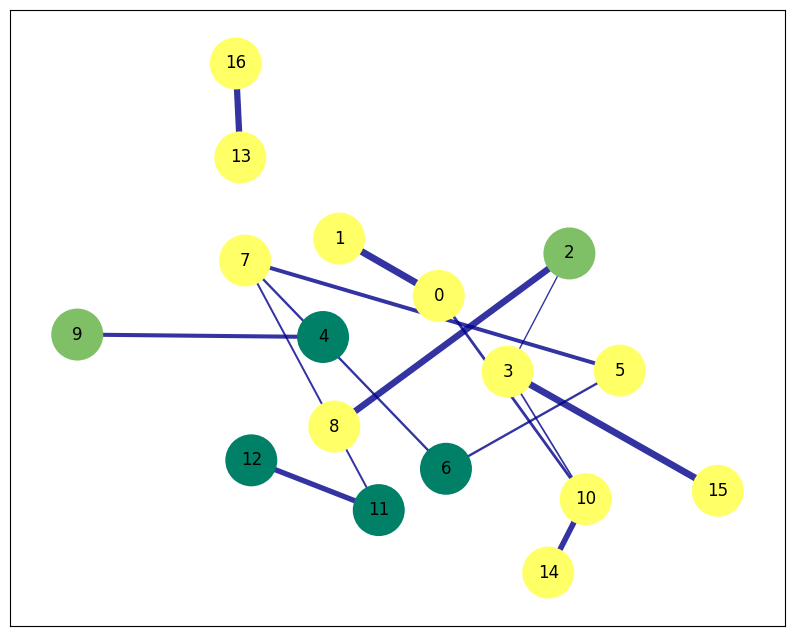

In [128]:
thr_info = compute_threshold_from_Wdf(W_df, method='percentile', param=0.90)
threshold = thr_info['thr_original']   
print("Threshold:", threshold, " (method:", thr_info['method'], "param:", thr_info['param'], ")")

W_thresh = W_df.copy()
W_thresh[np.abs(W_thresh) < threshold] = 0.0
print(f"\n(thr={threshold}):")
display(pd.DataFrame(W_thresh))

G, G_complete = plot_network(W_df, threshold, same_posicion_data, df)

In [212]:
# input data for refinement 
X = df_norm.values # NxF
A = W_thresh.values 
N = X.shape[0]  
F = X.shape[1]  

In [130]:
coords = same_posicion_data(df) # Nx2
if isinstance(coords, pd.Series):
    coords = np.vstack(coords.values)

#### Refinement loop 


--- Eliminando nodo 0 ---
DEBUG removed=0: eps=1.0e-07, max_hat=5.20e-06, max_full_masked=2.25e-01
       edges_inferred=11, edges_gt_masked=12, mismatches_total=2
       sample mismatches (i,j): [[2, 3], [3, 2]]
         mismatch (2,3): Ah=6.62e-08, Af=2.44e-03
         mismatch (3,2): Ah=6.62e-08, Af=2.44e-03
NMSE binarizada: 0.288675
Matriz reconstruida remapeada:
     0             1             2             3             4             5   \
0   0.0  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
1   0.0  0.000000e+00  1.467732e-08  1.120477e-08  3.038810e-08  1.551290e-08   
2   0.0  1.467732e-08  0.000000e+00  6.619983e-08  2.953295e-08  1.348829e-08   
3   0.0  1.120477e-08  6.619983e-08  0.000000e+00  2.537804e-08  1.395747e-08   
4   0.0  3.038810e-08  2.953295e-08  2.537804e-08  0.000000e+00  2.650455e-08   
5   0.0  1.551290e-08  1.348829e-08  1.395747e-08  2.650455e-08  0.000000e+00   
6   0.0  2.482138e-08  2.544715e-08  2.093580e-08  3.781383e-0

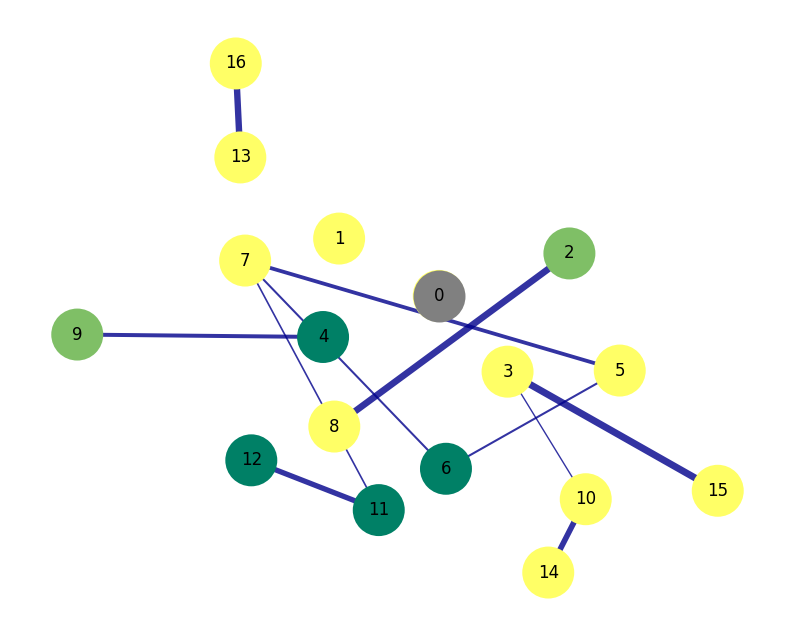


--- Eliminando nodo 1 ---
DEBUG removed=1: eps=1.0e-07, max_hat=6.84e-06, max_full_masked=2.25e-01
       edges_inferred=12, edges_gt_masked=13, mismatches_total=2
       sample mismatches (i,j): [[2, 3], [3, 2]]
         mismatch (2,3): Ah=8.13e-08, Af=2.44e-03
         mismatch (3,2): Ah=8.13e-08, Af=2.44e-03
NMSE binarizada: 0.277350
Matriz reconstruida remapeada:
              0    1             2             3             4             5   \
0   0.000000e+00  0.0  8.603967e-09  6.967970e-09  2.098353e-08  1.149345e-08   
1   0.000000e+00  0.0  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
2   8.603967e-09  0.0  0.000000e+00  8.126253e-08  2.129037e-08  9.723738e-09   
3   6.967970e-09  0.0  8.126253e-08  0.000000e+00  1.829508e-08  1.006197e-08   
4   2.098353e-08  0.0  2.129037e-08  1.829508e-08  0.000000e+00  1.910719e-08   
5   1.149345e-08  0.0  9.723738e-09  1.006197e-08  1.910719e-08  0.000000e+00   
6   1.637879e-08  0.0  1.834490e-08  1.509266e-08  2.726006e-0

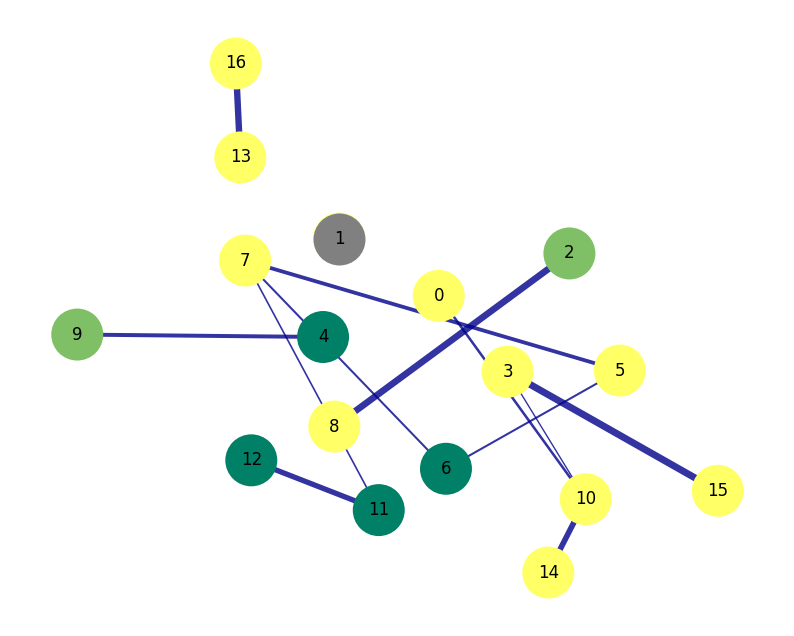


--- Eliminando nodo 2 ---
DEBUG removed=2: eps=1.0e-07, max_hat=5.95e-06, max_full_masked=2.32e-01
       edges_inferred=12, edges_gt_masked=12, mismatches_total=0
NMSE binarizada: 0.000000
Matriz reconstruida remapeada:
          0         1    2             3         4         5         6   \
0   0.000000  0.000006  0.0  0.000000e+00  0.000000  0.000000  0.000000   
1   0.000006  0.000000  0.0  0.000000e+00  0.000000  0.000000  0.000000   
2   0.000000  0.000000  0.0  0.000000e+00  0.000000  0.000000  0.000000   
3   0.000000  0.000000  0.0  0.000000e+00  0.000000  0.000000  0.000000   
4   0.000000  0.000000  0.0  0.000000e+00  0.000000  0.000000  0.000000   
5   0.000000  0.000000  0.0  0.000000e+00  0.000000  0.000000  0.000001   
6   0.000000  0.000000  0.0  0.000000e+00  0.000000  0.000001  0.000000   
7   0.000000  0.000000  0.0  0.000000e+00  0.000000  0.000003  0.000001   
8   0.000000  0.000000  0.0  0.000000e+00  0.000000  0.000000  0.000000   
9   0.000000  0.000000  0.0 

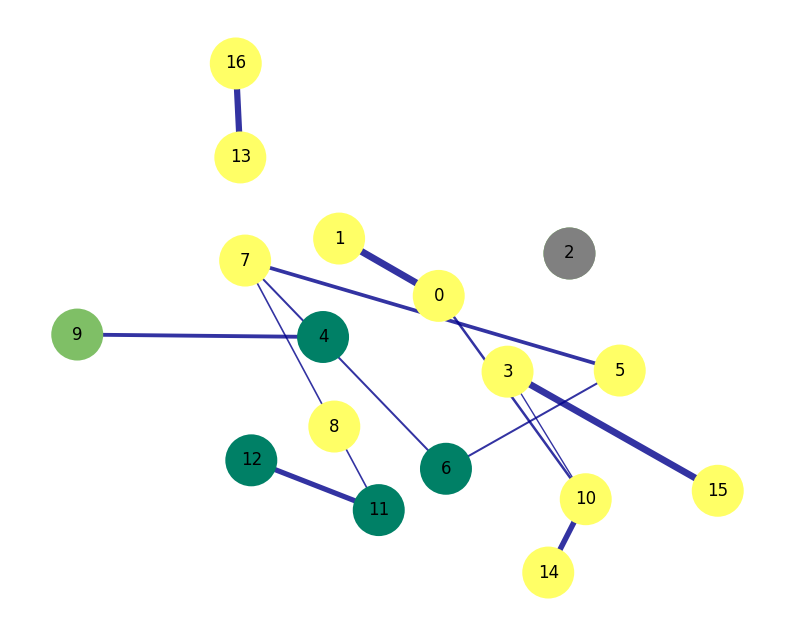


--- Eliminando nodo 3 ---
DEBUG removed=3: eps=1.0e-07, max_hat=4.42e-06, max_full_masked=2.32e-01
       edges_inferred=11, edges_gt_masked=11, mismatches_total=0
NMSE binarizada: 0.000000
Matriz reconstruida remapeada:
              0             1             2    3             4             5   \
0   0.000000e+00  4.421674e-06  3.324546e-09  0.0  8.107971e-09  4.441034e-09   
1   4.421674e-06  0.000000e+00  4.088429e-09  0.0  8.464733e-09  4.321185e-09   
2   3.324546e-09  4.088429e-09  0.000000e+00  0.0  8.226530e-09  3.757222e-09   
3   0.000000e+00  0.000000e+00  0.000000e+00  0.0  0.000000e+00  0.000000e+00   
4   8.107971e-09  8.464733e-09  8.226530e-09  0.0  0.000000e+00  7.382957e-09   
5   4.441034e-09  4.321185e-09  3.757222e-09  0.0  7.382957e-09  0.000000e+00   
6   6.328712e-09  6.914102e-09  7.088413e-09  0.0  1.053320e-08  8.067165e-07   
7   4.628870e-09  4.825286e-09  4.673510e-09  0.0  6.832486e-09  2.044206e-06   
8   4.010670e-09  3.886715e-09  4.072742e-06  0.0

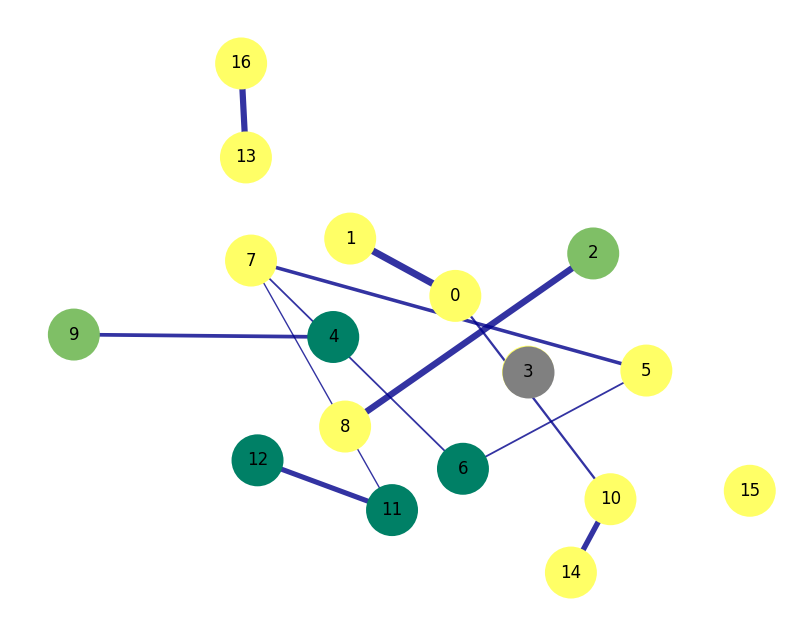


--- Eliminando nodo 4 ---
DEBUG removed=4: eps=1.0e-07, max_hat=1.05e-06, max_full_masked=2.32e-01
       edges_inferred=11, edges_gt_masked=13, mismatches_total=4
       sample mismatches (i,j): [[2, 3], [3, 2], [3, 10], [10, 3]]
         mismatch (2,3): Ah=9.03e-09, Af=2.44e-03
         mismatch (3,2): Ah=9.03e-09, Af=2.44e-03
         mismatch (3,10): Ah=7.65e-08, Af=1.72e-02
         mismatch (10,3): Ah=7.65e-08, Af=1.72e-02
NMSE binarizada: 0.392232
Matriz reconstruida remapeada:
              0         1             2             3    4             5   \
0   0.000000e+00  0.000001  0.000000e+00  0.000000e+00  0.0  0.000000e+00   
1   1.052326e-06  0.000000  0.000000e+00  0.000000e+00  0.0  0.000000e+00   
2   0.000000e+00  0.000000  0.000000e+00  9.034719e-09  0.0  0.000000e+00   
3   0.000000e+00  0.000000  9.034719e-09  0.000000e+00  0.0  0.000000e+00   
4   0.000000e+00  0.000000  0.000000e+00  0.000000e+00  0.0  0.000000e+00   
5   0.000000e+00  0.000000  0.000000e+00  0.000

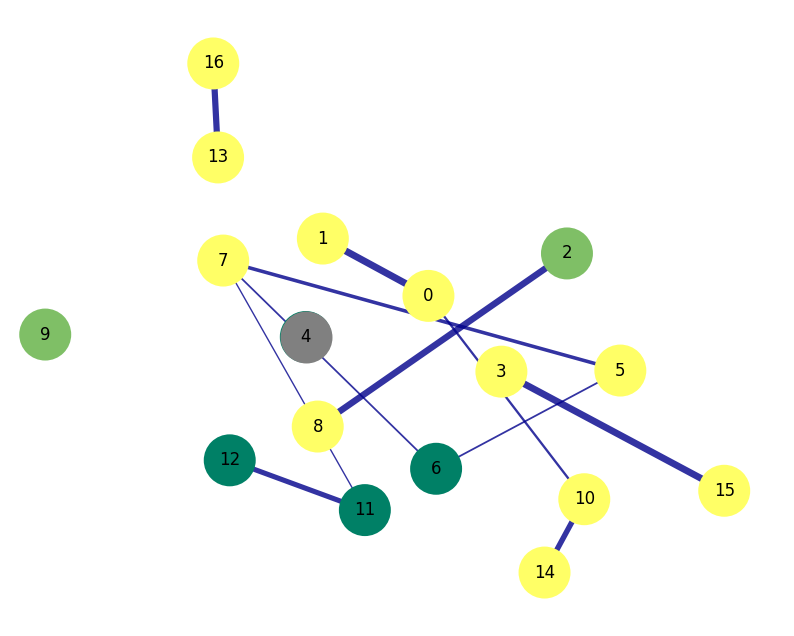


--- Eliminando nodo 5 ---
DEBUG removed=5: eps=1.0e-07, max_hat=4.19e-06, max_full_masked=2.32e-01
       edges_inferred=11, edges_gt_masked=12, mismatches_total=2
       sample mismatches (i,j): [[2, 3], [3, 2]]
         mismatch (2,3): Ah=5.19e-08, Af=2.44e-03
         mismatch (3,2): Ah=5.19e-08, Af=2.44e-03
NMSE binarizada: 0.288675
Matriz reconstruida remapeada:
              0             1             2             3             4    5   \
0   0.000000e+00  4.193116e-06  9.424301e-09  7.632322e-09  2.298418e-08  0.0   
1   4.193116e-06  0.000000e+00  1.158973e-08  8.847687e-09  2.399552e-08  0.0   
2   9.424301e-09  1.158973e-08  0.000000e+00  5.191746e-08  2.332027e-08  0.0   
3   7.632322e-09  8.847687e-09  5.191746e-08  0.000000e+00  2.003940e-08  0.0   
4   2.298418e-08  2.399552e-08  2.332027e-08  2.003940e-08  0.000000e+00  0.0   
5   0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.0   
6   1.794040e-08  1.959984e-08  2.009397e-08  1.653165e-08  2.

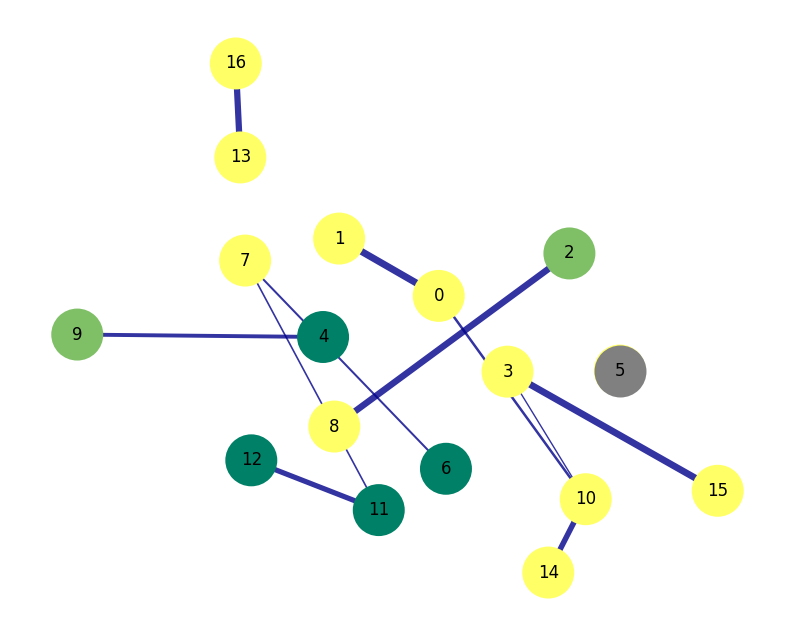


--- Eliminando nodo 6 ---
DEBUG removed=6: eps=1.0e-07, max_hat=6.91e-06, max_full_masked=2.32e-01
       edges_inferred=11, edges_gt_masked=12, mismatches_total=2
       sample mismatches (i,j): [[2, 3], [3, 2]]
         mismatch (2,3): Ah=6.37e-08, Af=2.44e-03
         mismatch (3,2): Ah=6.37e-08, Af=2.44e-03
NMSE binarizada: 0.288675
Matriz reconstruida remapeada:
              0             1             2             3             4   \
0   0.000000e+00  1.996621e-06  1.050647e-09  8.508725e-10  2.562341e-09   
1   1.996621e-06  0.000000e+00  1.292055e-09  9.863648e-10  2.675087e-09   
2   1.050647e-09  1.292055e-09  0.000000e+00  6.369631e-08  2.599808e-09   
3   8.508725e-10  9.863648e-10  6.369631e-08  0.000000e+00  2.234048e-09   
4   2.562341e-09  2.675087e-09  2.599808e-09  2.234048e-09  0.000000e+00   
5   1.403488e-09  1.365613e-09  1.187385e-09  1.228687e-09  2.333216e-09   
6   0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
7   1.462849e-09  1.5

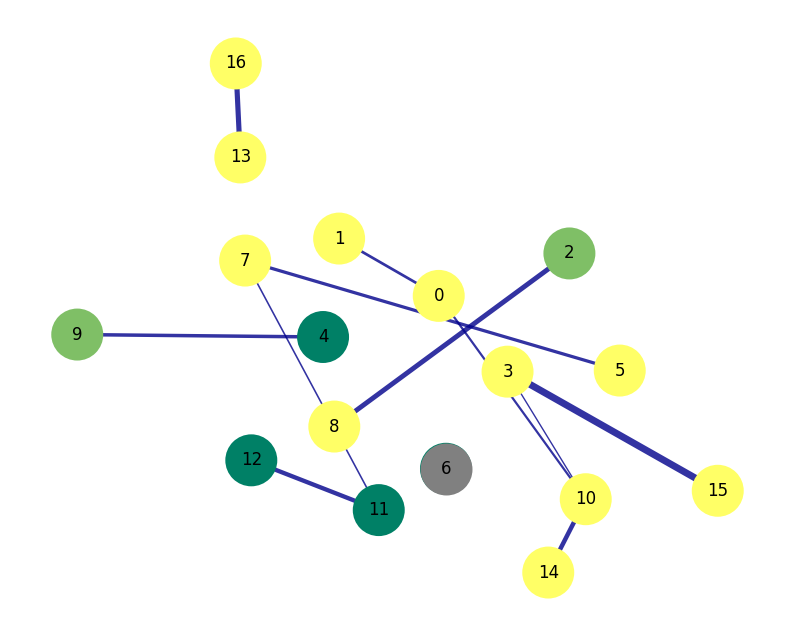


--- Eliminando nodo 7 ---
DEBUG removed=7: eps=1.0e-07, max_hat=3.95e-06, max_full_masked=2.32e-01
       edges_inferred=10, edges_gt_masked=11, mismatches_total=2
       sample mismatches (i,j): [[2, 3], [3, 2]]
         mismatch (2,3): Ah=5.13e-08, Af=2.44e-03
         mismatch (3,2): Ah=5.13e-08, Af=2.44e-03
NMSE binarizada: 0.301511
Matriz reconstruida remapeada:
              0             1             2             3             4   \
0   0.000000e+00  3.948587e-06  1.176595e-08  9.528717e-09  2.869504e-08   
1   3.948587e-06  0.000000e+00  1.446942e-08  1.104606e-08  2.995766e-08   
2   1.176595e-08  1.446942e-08  0.000000e+00  5.126194e-08  2.911463e-08   
3   9.528717e-09  1.104606e-08  5.126194e-08  0.000000e+00  2.501857e-08   
4   2.869504e-08  2.995766e-08  2.911463e-08  2.501857e-08  0.000000e+00   
5   1.571733e-08  1.529317e-08  1.329724e-08  1.375977e-08  2.612913e-08   
6   2.239803e-08  2.446980e-08  2.508670e-08  2.063925e-08  3.727821e-08   
7   0.000000e+00  0.0

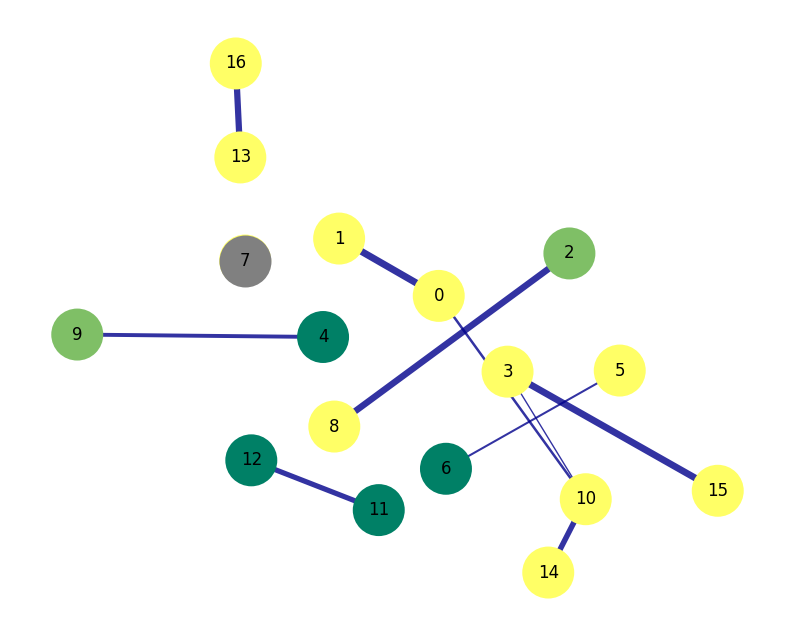


--- Eliminando nodo 8 ---
DEBUG removed=8: eps=1.0e-07, max_hat=7.80e-06, max_full_masked=2.32e-01
       edges_inferred=12, edges_gt_masked=13, mismatches_total=2
       sample mismatches (i,j): [[2, 3], [3, 2]]
         mismatch (2,3): Ah=8.56e-08, Af=2.44e-03
         mismatch (3,2): Ah=8.56e-08, Af=2.44e-03
NMSE binarizada: 0.277350
Matriz reconstruida remapeada:
              0             1             2             3             4   \
0   0.000000e+00  7.804167e-06  4.077282e-09  3.302009e-09  9.943760e-09   
1   7.804167e-06  0.000000e+00  5.014122e-09  3.827819e-09  1.038130e-08   
2   4.077282e-09  5.014122e-09  0.000000e+00  8.560747e-08  1.008916e-08   
3   3.302009e-09  3.827819e-09  8.560747e-08  0.000000e+00  8.669745e-09   
4   9.943760e-09  1.038130e-08  1.008916e-08  8.669745e-09  0.000000e+00   
5   5.446562e-09  5.299578e-09  4.607924e-09  4.768205e-09  9.054589e-09   
6   7.761645e-09  8.479577e-09  8.693355e-09  7.152169e-09  1.291811e-08   
7   5.676928e-09  5.9

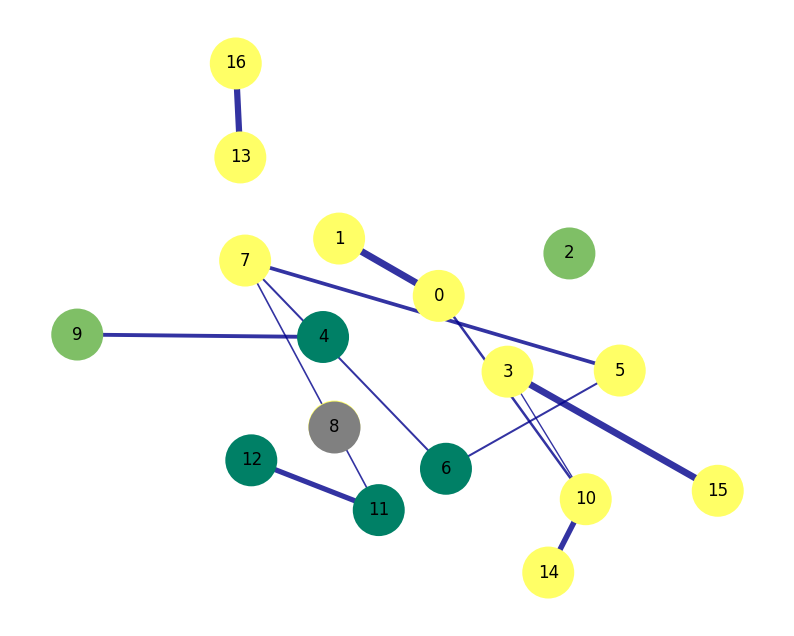


--- Eliminando nodo 9 ---
DEBUG removed=9: eps=1.0e-07, max_hat=6.08e-05, max_full_masked=2.32e-01
       edges_inferred=13, edges_gt_masked=13, mismatches_total=0
NMSE binarizada: 0.000000
Matriz reconstruida remapeada:
              0             1             2             3             4   \
0   0.000000e+00  6.079945e-05  2.416359e-08  1.956901e-08  5.893066e-08   
1   6.079945e-05  0.000000e+00  2.971567e-08  2.268517e-08  6.152369e-08   
2   2.416359e-08  2.971567e-08  0.000000e+00  6.563034e-07  5.979237e-08   
3   1.956901e-08  2.268517e-08  6.563034e-07  0.000000e+00  5.138035e-08   
4   5.893066e-08  6.152369e-08  5.979237e-08  5.138035e-08  0.000000e+00   
5   3.227849e-08  3.140740e-08  2.730838e-08  2.825827e-08  5.366108e-08   
6   4.599858e-08  5.025333e-08  5.152027e-08  4.238659e-08  7.655781e-08   
7   3.364373e-08  3.507133e-08  3.396818e-08  3.490915e-08  4.966013e-08   
8   2.915050e-08  2.824957e-08  5.524146e-05  2.239786e-08  4.934026e-08   
9   0.000000e+00  

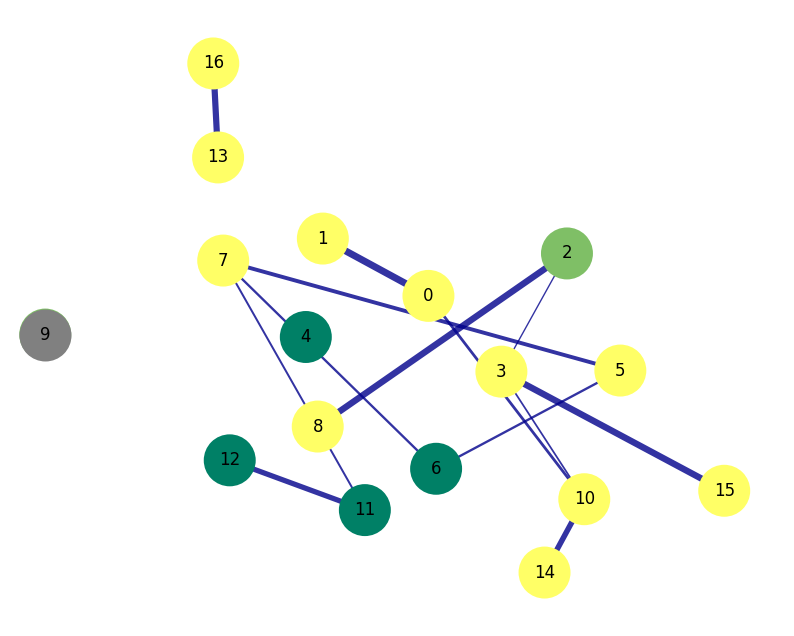


--- Eliminando nodo 10 ---
DEBUG removed=10: eps=1.0e-07, max_hat=1.97e-08, max_full_masked=2.32e-01
       edges_inferred=0, edges_gt_masked=11, mismatches_total=22
       sample mismatches (i,j): [[0, 1], [1, 0], [2, 3], [2, 8], [3, 2], [3, 15], [4, 9], [5, 6], [5, 7], [6, 5], [6, 7], [7, 5], [7, 6], [7, 11], [8, 2], [9, 4], [11, 7], [11, 12], [12, 11], [13, 16]]
         mismatch (0,1): Ah=0.00e+00, Af=2.32e-01
         mismatch (1,0): Ah=0.00e+00, Af=2.32e-01
         mismatch (2,3): Ah=0.00e+00, Af=2.44e-03
         mismatch (2,8): Ah=0.00e+00, Af=2.13e-01
         mismatch (3,2): Ah=0.00e+00, Af=2.44e-03
         mismatch (3,15): Ah=0.00e+00, Af=2.25e-01
NMSE binarizada: 1.000000
Matriz reconstruida remapeada:
              0             1             2             3             4   \
0   0.000000e+00  0.000000e+00  5.888542e-09  4.768868e-09  1.436110e-08   
1   0.000000e+00  0.000000e+00  7.241557e-09  5.528260e-09  1.499301e-08   
2   5.888542e-09  7.241557e-09  0.000000e+00 

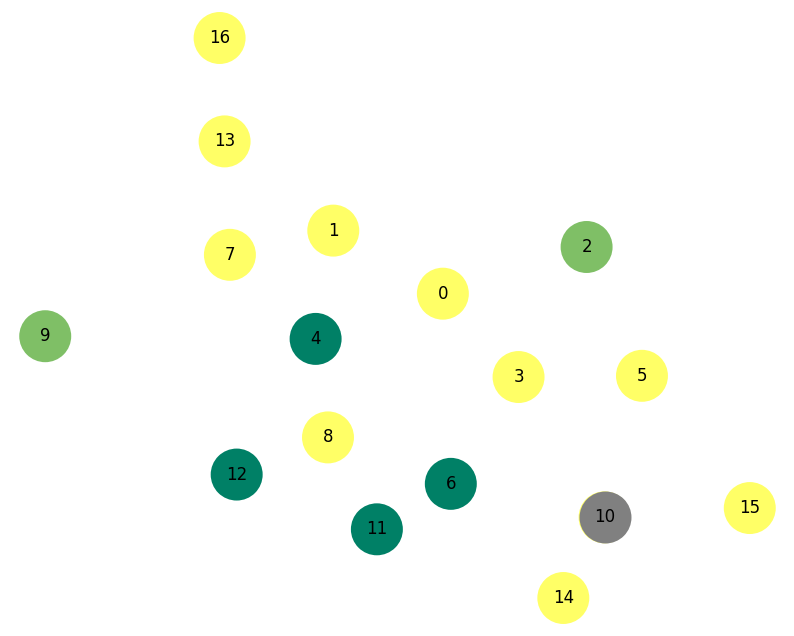


--- Eliminando nodo 11 ---
DEBUG removed=11: eps=1.0e-07, max_hat=3.47e-08, max_full_masked=2.32e-01
       edges_inferred=0, edges_gt_masked=12, mismatches_total=24
       sample mismatches (i,j): [[0, 1], [0, 10], [1, 0], [2, 3], [2, 8], [3, 2], [3, 10], [3, 15], [4, 9], [5, 6], [5, 7], [6, 5], [6, 7], [7, 5], [7, 6], [8, 2], [9, 4], [10, 0], [10, 3], [10, 14]]
         mismatch (0,1): Ah=0.00e+00, Af=2.32e-01
         mismatch (0,10): Ah=0.00e+00, Af=6.04e-02
         mismatch (1,0): Ah=0.00e+00, Af=2.32e-01
         mismatch (2,3): Ah=0.00e+00, Af=2.44e-03
         mismatch (2,8): Ah=0.00e+00, Af=2.13e-01
         mismatch (3,2): Ah=0.00e+00, Af=2.44e-03
NMSE binarizada: 1.000000
Matriz reconstruida remapeada:
              0             1             2             3             4   \
0   0.000000e+00  0.000000e+00  1.036832e-08  8.396842e-09  2.528648e-08   
1   0.000000e+00  0.000000e+00  1.275066e-08  9.733949e-09  2.639912e-08   
2   1.036832e-08  1.275066e-08  0.000000e+00  0

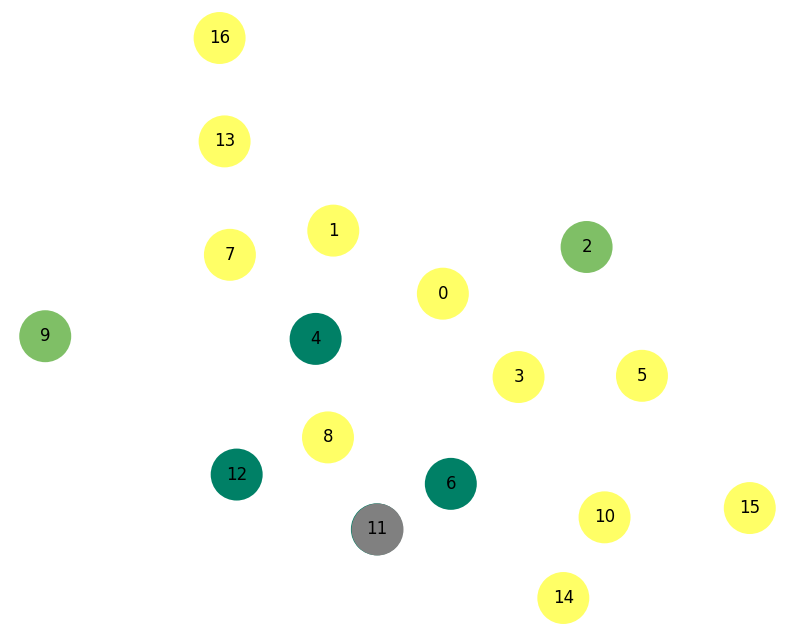


--- Eliminando nodo 12 ---
DEBUG removed=12: eps=1.0e-07, max_hat=2.51e-08, max_full_masked=2.32e-01
       edges_inferred=0, edges_gt_masked=13, mismatches_total=26
       sample mismatches (i,j): [[0, 1], [0, 10], [1, 0], [2, 3], [2, 8], [3, 2], [3, 10], [3, 15], [4, 9], [5, 6], [5, 7], [6, 5], [6, 7], [7, 5], [7, 6], [7, 11], [8, 2], [9, 4], [10, 0], [10, 3]]
         mismatch (0,1): Ah=0.00e+00, Af=2.32e-01
         mismatch (0,10): Ah=0.00e+00, Af=6.04e-02
         mismatch (1,0): Ah=0.00e+00, Af=2.32e-01
         mismatch (2,3): Ah=0.00e+00, Af=2.44e-03
         mismatch (2,8): Ah=0.00e+00, Af=2.13e-01
         mismatch (3,2): Ah=0.00e+00, Af=2.44e-03
NMSE binarizada: 1.000000
Matriz reconstruida remapeada:
              0             1             2             3             4   \
0   0.000000e+00  0.000000e+00  7.482099e-09  6.059418e-09  1.824750e-08   
1   0.000000e+00  0.000000e+00  9.201266e-09  7.024316e-09  1.905041e-08   
2   7.482099e-09  9.201266e-09  0.000000e+00  0.

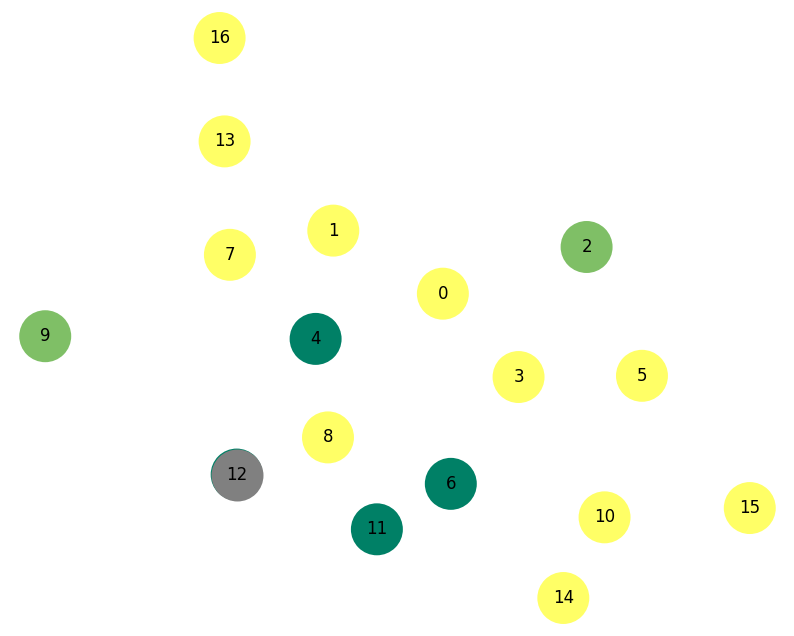


--- Eliminando nodo 13 ---
DEBUG removed=13: eps=1.0e-07, max_hat=5.76e-06, max_full_masked=2.32e-01
       edges_inferred=12, edges_gt_masked=13, mismatches_total=2
       sample mismatches (i,j): [[2, 3], [3, 2]]
         mismatch (2,3): Ah=5.58e-08, Af=2.44e-03
         mismatch (3,2): Ah=5.58e-08, Af=2.44e-03
NMSE binarizada: 0.277350
Matriz reconstruida remapeada:
          0         1             2             3         4         5   \
0   0.000000  0.000006  0.000000e+00  0.000000e+00  0.000000  0.000000   
1   0.000006  0.000000  0.000000e+00  0.000000e+00  0.000000  0.000000   
2   0.000000  0.000000  0.000000e+00  5.582829e-08  0.000000  0.000000   
3   0.000000  0.000000  5.582829e-08  0.000000e+00  0.000000  0.000000   
4   0.000000  0.000000  0.000000e+00  0.000000e+00  0.000000  0.000000   
5   0.000000  0.000000  0.000000e+00  0.000000e+00  0.000000  0.000000   
6   0.000000  0.000000  0.000000e+00  0.000000e+00  0.000000  0.000001   
7   0.000000  0.000000  0.000000e+0

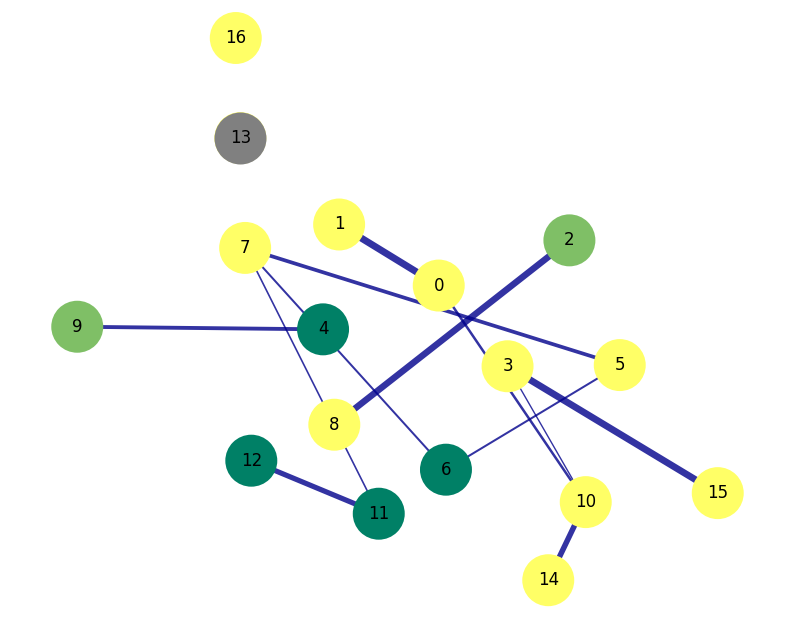


--- Eliminando nodo 14 ---
DEBUG removed=14: eps=1.0e-07, max_hat=3.81e-06, max_full_masked=2.32e-01
       edges_inferred=12, edges_gt_masked=13, mismatches_total=2
       sample mismatches (i,j): [[2, 3], [3, 2]]
         mismatch (2,3): Ah=4.23e-08, Af=2.44e-03
         mismatch (3,2): Ah=4.23e-08, Af=2.44e-03
NMSE binarizada: 0.277350
Matriz reconstruida remapeada:
              0             1             2             3             4   \
0   0.000000e+00  3.811293e-06  2.555063e-09  2.069232e-09  6.231341e-09   
1   3.811293e-06  0.000000e+00  3.142141e-09  2.398735e-09  6.505528e-09   
2   2.555063e-09  3.142141e-09  0.000000e+00  4.225718e-08  6.322458e-09   
3   2.069232e-09  2.398735e-09  4.225718e-08  0.000000e+00  5.432969e-09   
4   6.231341e-09  6.505528e-09  6.322458e-09  5.432969e-09  0.000000e+00   
5   3.413134e-09  3.321025e-09  2.887594e-09  2.988035e-09  5.674134e-09   
6   4.863900e-09  5.313798e-09  5.447764e-09  4.481967e-09  8.095239e-09   
7   3.557495e-09  3

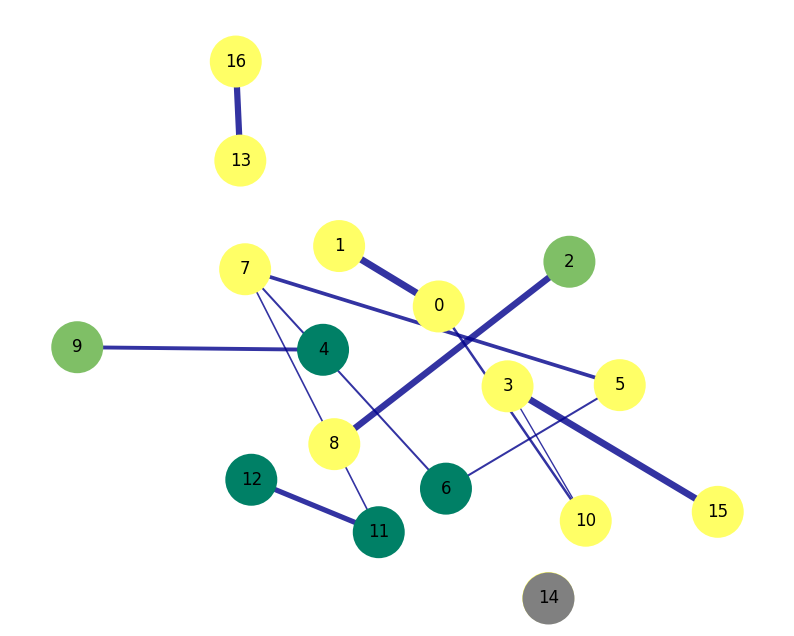


--- Eliminando nodo 15 ---
DEBUG removed=15: eps=1.0e-07, max_hat=4.44e-06, max_full_masked=2.32e-01
       edges_inferred=12, edges_gt_masked=13, mismatches_total=2
       sample mismatches (i,j): [[2, 3], [3, 2]]
         mismatch (2,3): Ah=4.95e-08, Af=2.44e-03
         mismatch (3,2): Ah=4.95e-08, Af=2.44e-03
NMSE binarizada: 0.277350
Matriz reconstruida remapeada:
              0             1             2             3             4   \
0   0.000000e+00  4.441511e-06  3.312267e-09  2.682458e-09  8.078026e-09   
1   4.441511e-06  0.000000e+00  4.073329e-09  3.109611e-09  8.433471e-09   
2   3.312267e-09  4.073329e-09  0.000000e+00  4.952963e-08  8.196147e-09   
3   2.682458e-09  3.109611e-09  4.952963e-08  0.000000e+00  7.043053e-09   
4   8.078026e-09  8.433471e-09  8.196147e-09  7.043053e-09  0.000000e+00   
5   4.424632e-09  4.305226e-09  3.743345e-09  3.873553e-09  7.355689e-09   
6   6.305338e-09  6.888566e-09  7.062233e-09  5.810218e-09  1.049430e-08   
7   4.611774e-09  4

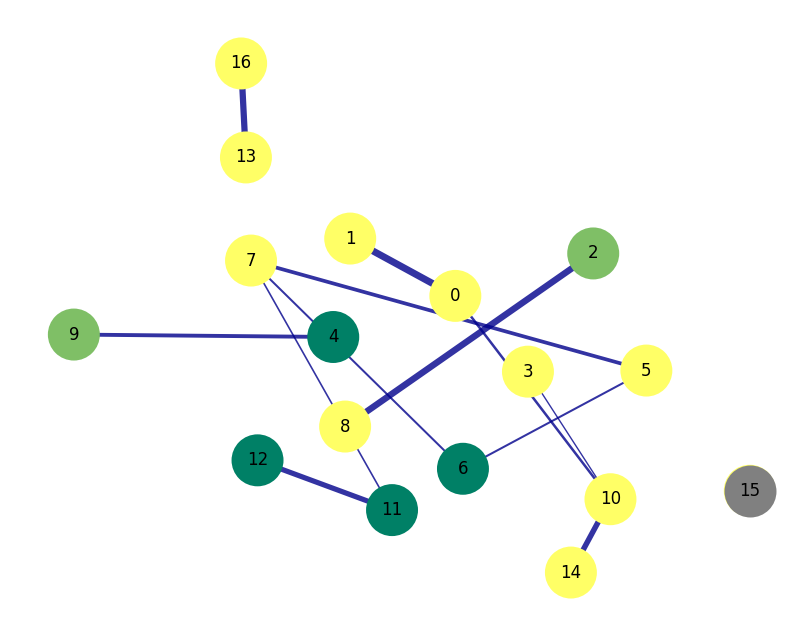


--- Eliminando nodo 16 ---
DEBUG removed=16: eps=1.0e-07, max_hat=4.42e-06, max_full_masked=2.32e-01
       edges_inferred=12, edges_gt_masked=13, mismatches_total=2
       sample mismatches (i,j): [[2, 3], [3, 2]]
         mismatch (2,3): Ah=5.36e-08, Af=2.44e-03
         mismatch (3,2): Ah=5.36e-08, Af=2.44e-03
NMSE binarizada: 0.277350
Matriz reconstruida remapeada:
              0             1             2             3             4   \
0   0.000000e+00  4.421848e-06  8.441134e-09  6.836099e-09  2.058641e-08   
1   4.421848e-06  0.000000e+00  1.038066e-08  7.924675e-09  2.149224e-08   
2   8.441134e-09  1.038066e-08  0.000000e+00  5.355624e-08  2.088744e-08   
3   6.836099e-09  7.924675e-09  5.355624e-08  0.000000e+00  1.794884e-08   
4   2.058641e-08  2.149224e-08  2.088744e-08  1.794884e-08  0.000000e+00   
5   1.127593e-08  1.097164e-08  9.539714e-09  9.871541e-09  1.874558e-08   
6   1.606881e-08  1.755514e-08  1.799772e-08  1.480703e-08  2.674416e-08   
7   1.175286e-08  1

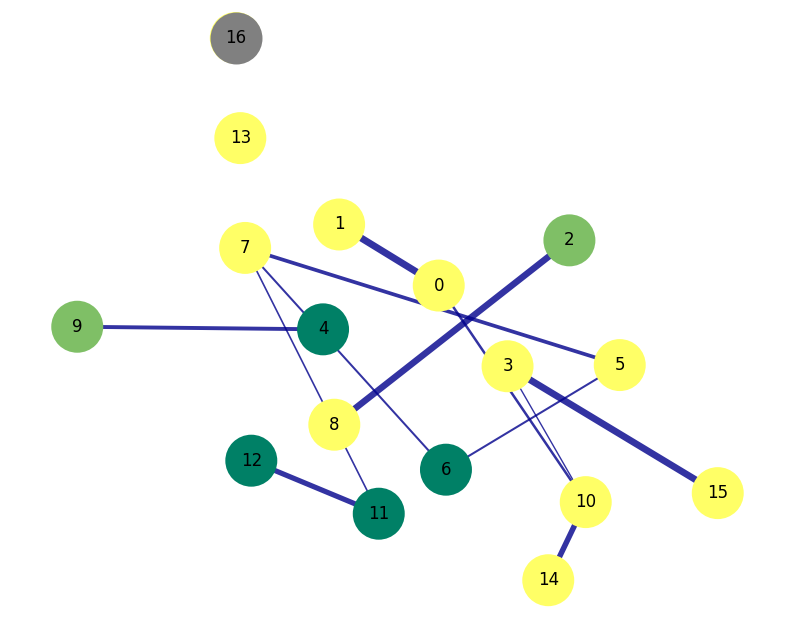


NMSE por nodo eliminado:
    node      nmse
0      0  0.288675
1      1  0.277350
2      2  0.000000
3      3  0.000000
4      4  0.392232
5      5  0.288675
6      6  0.288675
7      7  0.301511
8      8  0.277350
9      9  0.000000
10    10  1.000000
11    11  1.000000
12    12  1.000000
13    13  0.277350
14    14  0.277350
15    15  0.277350
16    16  0.277350
mean and median nmse: 0.3661099769008387 0.2773500981126146


In [215]:
# Loop over nodes 
lambda_reg = 8          # regularization parameter (tune it)
epsilon    = 1e-7          # binarization threshold
results = []

for s in range(N):
    print(f"\n--- Eliminando nodo {s} ---")
    P = construct_P(N, s)

    A_tilde_small = evaluate_graph_stability_fast(A, X, P, lambda_reg, eps=1e-3)
    #A_tilde_small = evaluate_graph_stability(A, X, P, lambda_reg)

    nmse, A_hat_bin, A_full_bin = calculate_nmse_with_mask_and_binarize(A_tilde_small, A, s, eps=epsilon)
    print(f"NMSE binarizada: {nmse:.6f}")
    results.append({'node': s, 'nmse': nmse})

    A_cont = remap_A_hat(A_tilde_small, s)
    W_recon_df = pd.DataFrame(A_cont)
    print("Refinement matrix:")
    print(W_recon_df)

    pos_removed = tuple(coords[s])  
    plot_graph_(
        W            = W_recon_df,
        df_info      = df,
        pos_removed  = pos_removed,
        removed_node = s,
        epsilon      = epsilon, 
        save_svg     = False,
        out_dir      = path, 
        filename     = f"graph_stable_glasso_drop{s}.svg", 
        show=True
    )

df_results = pd.DataFrame(results)
print("\nNMSE per deleted node:")
print(df_results)
mean_nmse = df_results['nmse'].mean()
median_nmse = df_results['nmse'].median()
print("mean and median nmse:", mean_nmse, median_nmse)


### Graphical Lasso

In [56]:
info=df_norm
info

2         3         4         5     6         7         8    \
0   1.000000  0.167103  0.396474  0.333657  0.26  0.664415  0.865481   
1   0.804440  0.011301  0.248192  0.340123  1.00  0.013583  0.410600   
2   0.288144  0.166266  0.278481  1.000000  0.00  0.805767  0.047970   
3   0.198394  0.201423  0.122514  0.699806  0.00  0.595191  0.170413   
4   0.170524  0.500471  0.171790  0.227934  0.00  0.000000  0.281114   
5   0.340576  0.348854  0.109403  0.108147  0.04  0.752960  0.131835   
6   0.352385  0.833525  0.638336  0.258325  0.10  1.000000  0.229453   
7   0.238545  0.440306  0.181736  0.086809  0.02  0.265998  0.209997   
8   0.315541  0.054096  0.074141  0.476398  0.28  0.537663  0.214358   
9   0.010392  0.000000  0.000000  0.000000  0.00  0.022518  0.000000   
10  0.708077  0.128911  0.872061  0.393792  0.60  0.554514  1.000000   
11  0.304676  0.593910  0.676311  0.120595  0.14  0.334496  0.200604   
12  0.479452  1.000000  0.211573  0.214678  0.30  0.347062  0.182825   
13  0.029287  0.310348  0.151899  0.010023  0.14  0.613641  0.830929   
14  0.300897  0.175997  1.000000  0.175558  0.12  0.175783  0.487420   
15  0.225791  0.593596  0.163201  0.652764  0.08  0.531053  0.256290   
16  0.000000  0.349064  0.049277  0.007759  0.10  0.421660  0.107347   

         9         10        11   ...       346       348       349       351  \
0   1.000000  0.278543  0.127179  ...  0.115976  0.009174  0.539683  0.000000   
1   0.367691  0.052632  0.022222  ...  0.071006  0.151376  0.523810  0.226562   
2   0.493932  0.707692  0.018462  ...  0.074556  0.573394  0.253968  0.164062   
3   0.701103  0.486640  0.098803  ...  0.119527  0.371560  0.603175  0.109375   
4   0.102128  0.151417  0.525812  ...  0.158580  1.000000  0.539683  0.679688   
5   0.426872  1.000000  0.708376  ...  0.000000  0.821101  0.444444  1.000000   
6   0.621198  0.980567  1.000000  ...  0.104142  0.252294  0.238095  0.554688   
7   0.334043  0.594332  0.387350  ...  0.132544  0.165138  0.412698  0.546875   
8   0.432545  0.168421  0.508376  ...  0.268639  0.504587  0.349206  0.320312   
9   0.000000  0.034008  0.000000  ...  0.156213  0.123853  0.000000  0.195312   
10  0.816312  0.062348  0.192479  ...  0.111243  0.389908  0.793651  0.109375   
11  0.230260  0.066397  0.094701  ...  0.158580  0.899083  0.507937  0.351562   
12  0.190071  0.160324  0.455385  ...  0.055621  0.000000  0.238095  0.101562   
13  0.614578  0.217004  0.113504  ...  1.000000  0.082569  1.000000  0.843750   
14  0.300709  0.000000  0.063590  ...  0.217751  0.119266  0.396825  0.039062   
15  0.324901  0.060729  0.665983  ...  0.164497  0.325688  0.841270  0.460938   
16  0.411032  0.069636  0.128889  ...  0.250888  0.004587  0.555556  0.976562   

         352       353       354   355       356       358  
0   0.141844  0.198529  0.181818  0.25  0.333333  0.088889  
1   0.418440  0.272059  0.000000  0.00  0.333333  0.133333  
2   0.017730  0.205882  0.090909  0.25  0.000000  0.133333  
3   0.244681  0.198529  0.090909  0.25  1.000000  0.255556  
4   0.134752  0.948529  0.090909  0.25  0.666667  0.611111  
5   0.187943  0.308824  0.454545  1.00  0.666667  0.355556  
6   0.397163  0.235294  1.000000  0.00  0.666667  0.311111  
7   0.365248  0.595588  0.727273  0.00  0.333333  0.222222  
8   0.234043  0.595588  0.000000  0.25  0.000000  0.166667  
9   0.244681  0.125000  0.000000  0.00  1.000000  0.100000  
10  0.241135  0.294118  0.090909  0.25  0.666667  0.033333  
11  0.453901  0.904412  0.181818  0.50  0.666667  0.711111  
12  0.000000  1.000000  0.000000  0.25  0.000000  1.000000  
13  1.000000  0.272059  0.727273  1.00  0.333333  0.611111  
14  0.787234  0.000000  0.090909  0.25  0.000000  0.000000  
15  0.131206  0.426471  0.272727  0.50  0.333333  0.344444  
16  0.634752  0.205882  0.181818  0.00  0.000000  0.844444  

[17 rows x 292 columns]

In [57]:
datos=np.array(df_norm)
datos2=np.transpose(datos) 
datos2 /= datos2.std(axis=0)

In [79]:
edge_model = covariance.GraphicalLassoCV(cv=5, max_iter=10000,verbose=True, assume_centered=True)
edge_model.fit(datos2)

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.2s finished


[GraphicalLassoCV] Done refinement  1 out of 4:   0s
[GraphicalLassoCV] Done refinement  2 out of 4:   0s
[GraphicalLassoCV] Done refinement  3 out of 4:   0s
[GraphicalLassoCV] Done refinement  4 out of 4:   0s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished


GraphicalLassoCV(assume_centered=True, cv=5, max_iter=10000, verbose=True)

In [80]:
precision_m = np.around(edge_model.precision_, decimals=3) # precision matrix
precision_m = pd.DataFrame(precision_m)
covariance_m= np.around(edge_model.covariance_, decimals=3) # covariance
covariance_m= pd.DataFrame(covariance_m)

In [81]:
precision_m

0      1      2      3      4      5      6      7      8      9   \
0   2.006 -0.725 -0.025 -0.282 -0.000  0.013 -0.061  0.000  0.000  0.000   
1  -0.725  1.832  0.000 -0.029  0.000 -0.068  0.026 -0.000 -0.195  0.092   
2  -0.025  0.000  1.802 -0.616 -0.037 -0.221 -0.062  0.082 -0.653 -0.000   
3  -0.282 -0.029 -0.616  2.239 -0.071 -0.018 -0.075  0.067 -0.078 -0.014   
4  -0.000  0.000 -0.037 -0.071  1.012 -0.092  0.043 -0.104 -0.149 -0.099   
5   0.013 -0.068 -0.221 -0.018 -0.092  1.407 -0.046 -0.403  0.208  0.089   
6  -0.061  0.026 -0.062 -0.075  0.043 -0.046  0.837 -0.131  0.006  0.000   
7   0.000 -0.000  0.082  0.067 -0.104 -0.403 -0.131  1.434  0.000  0.048   
8   0.000 -0.195 -0.653 -0.078 -0.149  0.208  0.006  0.000  1.647 -0.213   
9   0.000  0.092 -0.000 -0.014 -0.099  0.089  0.000  0.048 -0.213  1.109   
10 -0.623 -0.314 -0.126 -0.497 -0.064 -0.000 -0.079 -0.192 -0.004  0.057   
11  0.056  0.000 -0.036 -0.026 -0.086 -0.006 -0.106 -0.441 -0.166 -0.196   
12 -0.106 -0.000 -0.047  0.075 -0.276 -0.035 -0.000 -0.237  0.000 -0.092   
13  0.004  0.000  0.023 -0.138  0.000 -0.261 -0.000 -0.004 -0.132 -0.051   
14  0.052 -0.292  0.103 -0.120  0.000  0.026 -0.141 -0.085 -0.000  0.088   
15 -0.124 -0.111 -0.018 -0.581 -0.144 -0.375 -0.106 -0.022 -0.414  0.000   
16 -0.000 -0.113  0.274  0.000 -0.076 -0.020 -0.116 -0.000  0.000 -0.077   

       10     11     12     13     14     15     16  
0  -0.623  0.056 -0.106  0.004  0.052 -0.124 -0.000  
1  -0.314  0.000 -0.000  0.000 -0.292 -0.111 -0.113  
2  -0.126 -0.036 -0.047  0.023  0.103 -0.018  0.274  
3  -0.497 -0.026  0.075 -0.138 -0.120 -0.581  0.000  
4  -0.064 -0.086 -0.276  0.000  0.000 -0.144 -0.076  
5  -0.000 -0.006 -0.035 -0.261  0.026 -0.375 -0.020  
6  -0.079 -0.106 -0.000 -0.000 -0.141 -0.106 -0.116  
7  -0.192 -0.441 -0.237 -0.004 -0.085 -0.022 -0.000  
8  -0.004 -0.166  0.000 -0.132 -0.000 -0.414  0.000  
9   0.057 -0.196 -0.092 -0.051  0.088  0.000 -0.077  
10  2.280 -0.038  0.066  0.045 -0.611  0.002  0.014  
11 -0.038  1.397 -0.538 -0.176 -0.046  0.216 -0.115  
12  0.066 -0.538  1.430  0.123  0.250 -0.157 -0.058  
13  0.045 -0.176  0.123  1.407 -0.221 -0.030 -0.749  
14 -0.611 -0.046  0.250 -0.221  1.464 -0.040 -0.077  
15  0.002  0.216 -0.157 -0.030 -0.040  1.840 -0.099  
16  0.014 -0.115 -0.058 -0.749 -0.077 -0.099  1.386

Threshold automático: 0.314  (method: percentile param: 0.88 )

Matriz umbralizada (thr=0.314):


0      1      2      3      4      5      6      7      8      9   \
0   2.006 -0.725  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000   
1  -0.725  1.832  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000   
2   0.000  0.000  1.802 -0.616  0.000  0.000  0.000  0.000 -0.653  0.000   
3   0.000  0.000 -0.616  2.239  0.000  0.000  0.000  0.000  0.000  0.000   
4   0.000  0.000  0.000  0.000  1.012  0.000  0.000  0.000  0.000  0.000   
5   0.000  0.000  0.000  0.000  0.000  1.407  0.000 -0.403  0.000  0.000   
6   0.000  0.000  0.000  0.000  0.000  0.000  0.837  0.000  0.000  0.000   
7   0.000  0.000  0.000  0.000  0.000 -0.403  0.000  1.434  0.000  0.000   
8   0.000  0.000 -0.653  0.000  0.000  0.000  0.000  0.000  1.647  0.000   
9   0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  1.109   
10 -0.623 -0.314  0.000 -0.497  0.000  0.000  0.000  0.000  0.000  0.000   
11  0.000  0.000  0.000  0.000  0.000  0.000  0.000 -0.441  0.000  0.000   
12  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000   
13  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000   
14  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000   
15  0.000  0.000  0.000 -0.581  0.000 -0.375  0.000  0.000 -0.414  0.000   
16  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000   

       10     11     12     13     14     15     16  
0  -0.623  0.000  0.000  0.000  0.000  0.000  0.000  
1  -0.314  0.000  0.000  0.000  0.000  0.000  0.000  
2   0.000  0.000  0.000  0.000  0.000  0.000  0.000  
3  -0.497  0.000  0.000  0.000  0.000 -0.581  0.000  
4   0.000  0.000  0.000  0.000  0.000  0.000  0.000  
5   0.000  0.000  0.000  0.000  0.000 -0.375  0.000  
6   0.000  0.000  0.000  0.000  0.000  0.000  0.000  
7   0.000 -0.441  0.000  0.000  0.000  0.000  0.000  
8   0.000  0.000  0.000  0.000  0.000 -0.414  0.000  
9   0.000  0.000  0.000  0.000  0.000  0.000  0.000  
10  2.280  0.000  0.000  0.000 -0.611  0.000  0.000  
11  0.000  1.397 -0.538  0.000  0.000  0.000  0.000  
12  0.000 -0.538  1.430  0.000  0.000  0.000  0.000  
13  0.000  0.000  0.000  1.407  0.000  0.000 -0.749  
14 -0.611  0.000  0.000  0.000  1.464  0.000  0.000  
15  0.000  0.000  0.000  0.000  0.000  1.840  0.000  
16  0.000  0.000  0.000 -0.749  0.000  0.000  1.386

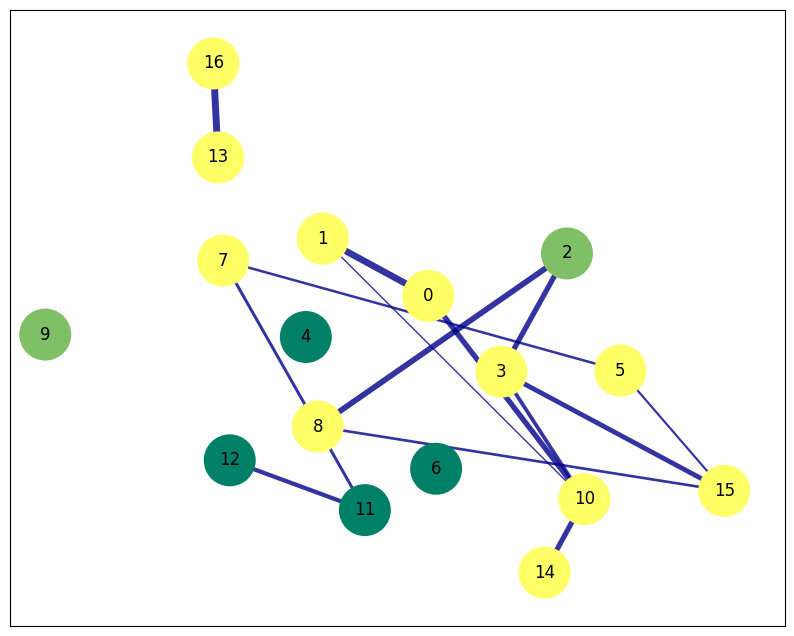

In [186]:
thr_info = compute_threshold_from_Wdf(precision_m, method='percentile', param=0.88)
threshold = thr_info['thr_original']  
print("Threshold :", threshold, " (method:", thr_info['method'], "param:", thr_info['param'], ")")

p_thresh = precision_m.copy()
p_thresh[np.abs(p_thresh) < threshold] = 0.0
print(f"\n(thr={threshold}):")
display(pd.DataFrame(p_thresh))

G_glasso, Glasso_complete = plot_network(p_thresh, threshold, same_posicion_data, df)

In [187]:
# input data 
X = df_norm.values 
A = p_thresh.values 
N = X.shape[0]  
F = X.shape[1] 

In [ ]:
from pathlib import Path

def remap_A_hat(Atil_small, removed):
    N_minus_1 = Atil_small.shape[0]
    N = N_minus_1 + 1
    A_hat = np.zeros((N, N))
    idx = list(range(N))
    idx.pop(removed)
    for i_small, i_big in enumerate(idx):
        for j_small, j_big in enumerate(idx):
            A_hat[i_big, j_big] = Atil_small[i_small, j_small]
   
    A_hat = (A_hat + A_hat.T) / 2.0
    np.fill_diagonal(A_hat, 0.0)
    return A_hat

def mask_node(A, removed):
    
    M = A.copy().astype(float)
    M[removed, :] = 0.0
    M[:, removed] = 0.0
    M = (M + M.T) / 2.0
    np.fill_diagonal(M, 0.0)
    return M

def binarize_matrix(A, eps):
    B = (np.abs(A) > eps).astype(float)
    B = np.triu(B, 1)  # mantener solo triángulo superior
    B = B + B.T        # volver a simétrica
    np.fill_diagonal(B, 0.0)
    return B

def calculate_nmse_with_mask_and_binarize(Atil_small, A_full, removed, eps=1e-6):

    A_hat = remap_A_hat(Atil_small, removed)
    A_full_masked = mask_node(A_full, removed)

    max_hat = float(np.max(np.abs(A_hat)))
    max_full = float(np.max(np.abs(A_full_masked)))

    if max_full < 1e-16 and max_hat < 1e-16:
        print(f"DEBUG removed={removed}: ambos A_hat y A_full_masked ≈ 0 → NMSE=0")
        A_hat_bin = np.zeros_like(A_hat)
        A_full_bin = np.zeros_like(A_full_masked)
        return 0.0, A_hat_bin, A_full_bin

    A_hat_bin = binarize_matrix(A_hat, eps)
    A_full_bin = binarize_matrix(A_full_masked, eps)

    diff = np.linalg.norm(A_hat_bin - A_full_bin, ord='fro')
    normA = np.linalg.norm(A_full_bin, ord='fro')
    nmse = np.inf if normA == 0 and diff != 0 else (0.0 if normA == 0 and diff == 0 else diff / normA)

    cnt_hat = int(np.sum(np.triu(A_hat_bin, 1)))   
    cnt_full = int(np.sum(np.triu(A_full_bin, 1)))
    mism = np.argwhere(A_hat_bin != A_full_bin)
    n_mism = mism.shape[0]
    sample_mismatches = mism[:20].tolist()

    print(f"DEBUG removed={removed}: eps={eps:.1e}, max_hat={max_hat:.2e}, max_full_masked={max_full:.2e}")
    print(f"       edges_inferred={cnt_hat}, edges_gt_masked={cnt_full}, mismatches_total={n_mism}")
    if n_mism > 0:
        print("       sample mismatches (i,j):", sample_mismatches)
        for (i, j) in mism[:6]:
            print(f"         mismatch ({i},{j}): Ah={A_hat[i,j]:.2e}, Af={A_full_masked[i,j]:.2e}")

    return nmse, A_hat_bin, A_full_bin

#### Refinement loop


--- Eliminando nodo 0 ---
DEBUG removed=0: eps=1.0e-06, max_hat=5.49e-06, max_full_masked=7.49e-01
       edges_inferred=12, edges_gt_masked=12, mismatches_total=0
NMSE binarizada: 0.000000
Matriz reconstruida remapeada:
     0             1             2             3             4             5   \
0   0.0  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
1   0.0  0.000000e+00  1.408338e-08  1.075136e-08  2.915841e-08  1.488516e-08   
2   0.0  1.408338e-08  0.000000e+00  4.517130e-06  2.833788e-08  1.294248e-08   
3   0.0  1.075136e-08  4.517130e-06  0.000000e+00  2.435109e-08  1.339267e-08   
4   0.0  2.915841e-08  2.833788e-08  2.435109e-08  0.000000e+00  2.543202e-08   
5   0.0  1.488516e-08  1.294248e-08  1.339267e-08  2.543202e-08  0.000000e+00   
6   0.0  2.381696e-08  2.441741e-08  2.008862e-08  3.628365e-08  2.230549e-08   
7   0.0  1.662163e-08  1.609881e-08  1.654477e-08  2.353582e-08  2.959865e-06   
8   0.0  1.338854e-08  4.787157e-06  1.061520e-08

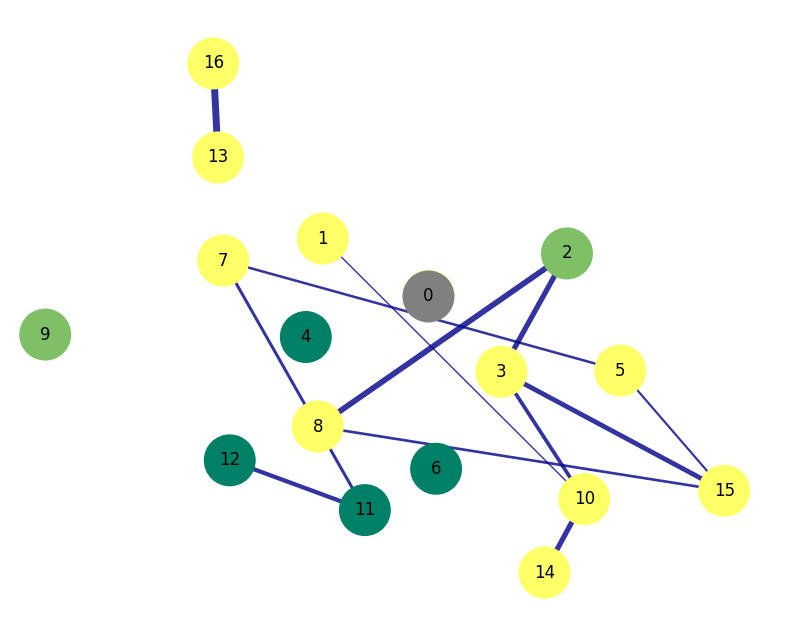


--- Eliminando nodo 1 ---
DEBUG removed=1: eps=1.0e-06, max_hat=4.02e-06, max_full_masked=7.49e-01
       edges_inferred=12, edges_gt_masked=12, mismatches_total=0
NMSE binarizada: 0.000000
Matriz reconstruida remapeada:
              0    1             2             3             4             5   \
0   0.000000e+00  0.0  6.274287e-08  5.081265e-08  1.530186e-07  8.381391e-08   
1   0.000000e+00  0.0  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
2   6.274287e-08  0.0  0.000000e+00  3.293138e-06  1.552561e-07  7.090860e-08   
3   5.081265e-08  0.0  3.293138e-06  0.000000e+00  1.334136e-07  7.337506e-08   
4   1.530186e-07  0.0  1.552561e-07  1.334136e-07  0.000000e+00  1.393357e-07   
5   8.381391e-08  0.0  7.090860e-08  7.337506e-08  1.393357e-07  0.000000e+00   
6   1.194393e-07  0.0  1.337769e-07  1.100605e-07  1.987890e-07  1.222062e-07   
7   8.735887e-08  0.0  8.820134e-08  9.064466e-08  1.289469e-07  2.179997e-06   
8   7.569183e-08  0.0  3.483848e-06  5.815800e-08

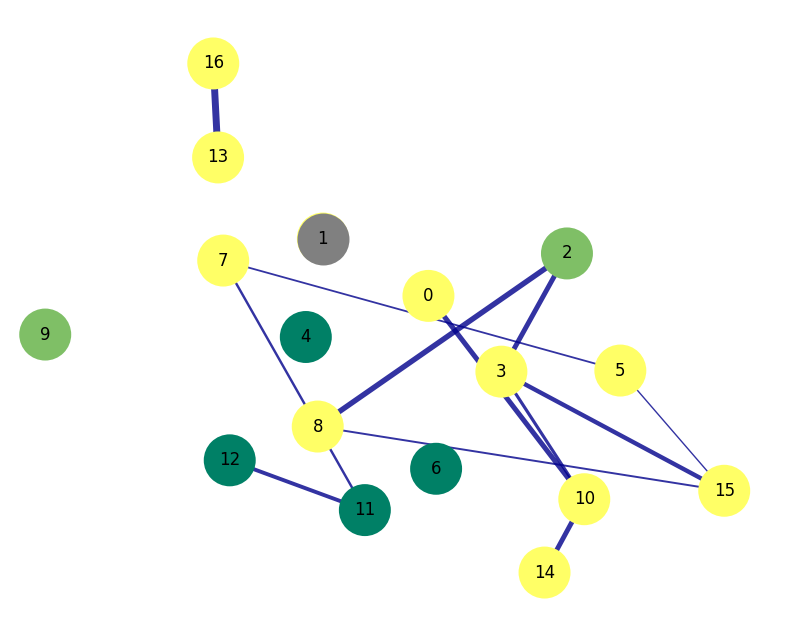


--- Eliminando nodo 2 ---
DEBUG removed=2: eps=1.0e-06, max_hat=4.97e-06, max_full_masked=7.49e-01
       edges_inferred=12, edges_gt_masked=12, mismatches_total=0
NMSE binarizada: 0.000000
Matriz reconstruida remapeada:
              0             1    2             3             4             5   \
0   0.000000e+00  4.793737e-06  0.0  2.402460e-08  7.234832e-08  3.962783e-08   
1   4.793737e-06  0.000000e+00  0.0  2.785026e-08  7.553175e-08  3.855841e-08   
2   0.000000e+00  0.000000e+00  0.0  0.000000e+00  0.000000e+00  0.000000e+00   
3   2.402460e-08  2.785026e-08  0.0  0.000000e+00  6.307891e-08  3.469227e-08   
4   7.234832e-08  7.553175e-08  0.0  6.307891e-08  0.000000e+00  6.587894e-08   
5   3.962783e-08  3.855841e-08  0.0  3.469227e-08  6.587894e-08  0.000000e+00   
6   5.647179e-08  6.169529e-08  0.0  5.203740e-08  9.398892e-08  5.777998e-08   
7   4.130391e-08  4.305656e-08  0.0  4.285746e-08  6.096703e-08  2.682330e-06   
8   3.578765e-08  3.468159e-08  0.0  2.749753e-08

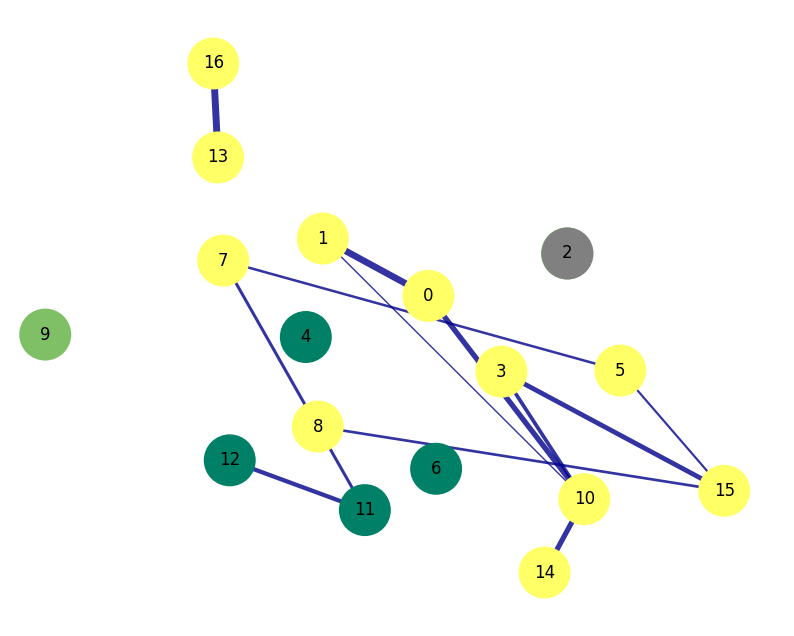


--- Eliminando nodo 3 ---
DEBUG removed=3: eps=1.0e-06, max_hat=6.40e-06, max_full_masked=7.49e-01
       edges_inferred=11, edges_gt_masked=11, mismatches_total=0
NMSE binarizada: 0.000000
Matriz reconstruida remapeada:
          0         1         2    3    4         5    6         7         8   \
0   0.000000  0.000006  0.000000  0.0  0.0  0.000000  0.0  0.000000  0.000000   
1   0.000006  0.000000  0.000000  0.0  0.0  0.000000  0.0  0.000000  0.000000   
2   0.000000  0.000000  0.000000  0.0  0.0  0.000000  0.0  0.000000  0.000006   
3   0.000000  0.000000  0.000000  0.0  0.0  0.000000  0.0  0.000000  0.000000   
4   0.000000  0.000000  0.000000  0.0  0.0  0.000000  0.0  0.000000  0.000000   
5   0.000000  0.000000  0.000000  0.0  0.0  0.000000  0.0  0.000003  0.000000   
6   0.000000  0.000000  0.000000  0.0  0.0  0.000000  0.0  0.000000  0.000000   
7   0.000000  0.000000  0.000000  0.0  0.0  0.000003  0.0  0.000000  0.000000   
8   0.000000  0.000000  0.000006  0.0  0.0  0.000

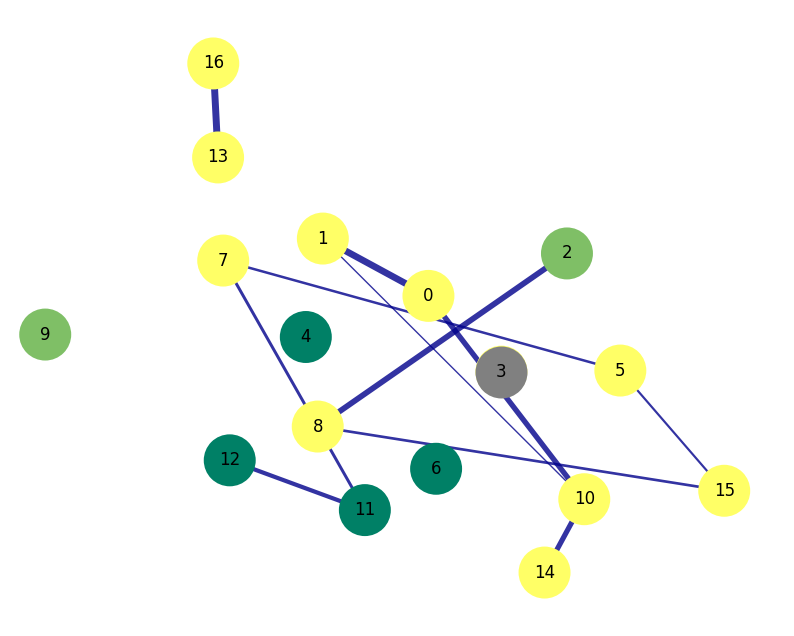


--- Eliminando nodo 4 ---
DEBUG removed=4: eps=1.0e-06, max_hat=3.94e-06, max_full_masked=7.49e-01
       edges_inferred=14, edges_gt_masked=14, mismatches_total=0
NMSE binarizada: 0.000000
Matriz reconstruida remapeada:
              0             1             2             3    4             5   \
0   0.000000e+00  3.797678e-06  2.492300e-08  2.018403e-08  0.0  3.329293e-08   
1   3.797678e-06  0.000000e+00  3.064958e-08  2.339812e-08  0.0  3.239447e-08   
2   2.492300e-08  3.064958e-08  0.000000e+00  3.233895e-06  0.0  2.816663e-08   
3   2.018403e-08  2.339812e-08  3.233895e-06  0.000000e+00  0.0  2.914637e-08   
4   0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.0  0.000000e+00   
5   3.329293e-08  3.239447e-08  2.816663e-08  2.914637e-08  0.0  0.000000e+00   
6   4.744423e-08  5.183269e-08  5.313945e-08  4.371872e-08  0.0  4.854329e-08   
7   3.470108e-08  3.617355e-08  3.503573e-08  3.600628e-08  0.0  2.125834e-06   
8   3.006665e-08  2.913740e-08  3.425321e-06  2.3

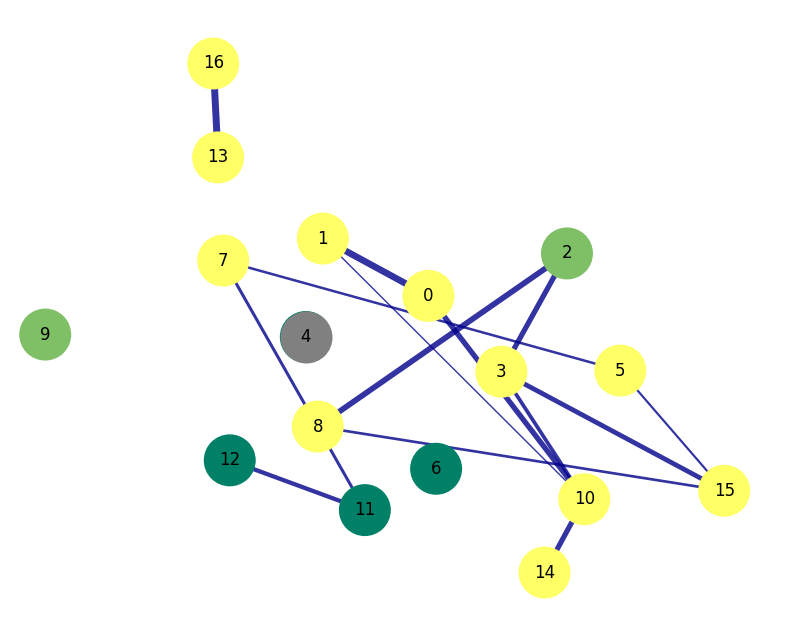


--- Eliminando nodo 5 ---
DEBUG removed=5: eps=1.0e-06, max_hat=4.21e-06, max_full_masked=7.49e-01
       edges_inferred=12, edges_gt_masked=12, mismatches_total=0
NMSE binarizada: 0.000000
Matriz reconstruida remapeada:
              0             1             2             3             4    5   \
0   0.000000e+00  4.067717e-06  2.136695e-08  1.730414e-08  5.211016e-08  0.0   
1   4.067717e-06  0.000000e+00  2.627645e-08  2.005964e-08  5.440307e-08  0.0   
2   2.136695e-08  2.627645e-08  0.000000e+00  3.462311e-06  5.287214e-08  0.0   
3   1.730414e-08  2.005964e-08  3.462311e-06  0.000000e+00  4.543370e-08  0.0   
4   5.211016e-08  5.440307e-08  5.287214e-08  4.543370e-08  0.000000e+00  0.0   
5   0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.0   
6   4.067481e-08  4.443712e-08  4.555742e-08  3.748086e-08  6.769718e-08  0.0   
7   2.974988e-08  3.101225e-08  3.003678e-08  3.086884e-08  4.391258e-08  0.0   
8   2.577669e-08  2.498003e-08  3.667859e-06  1.9

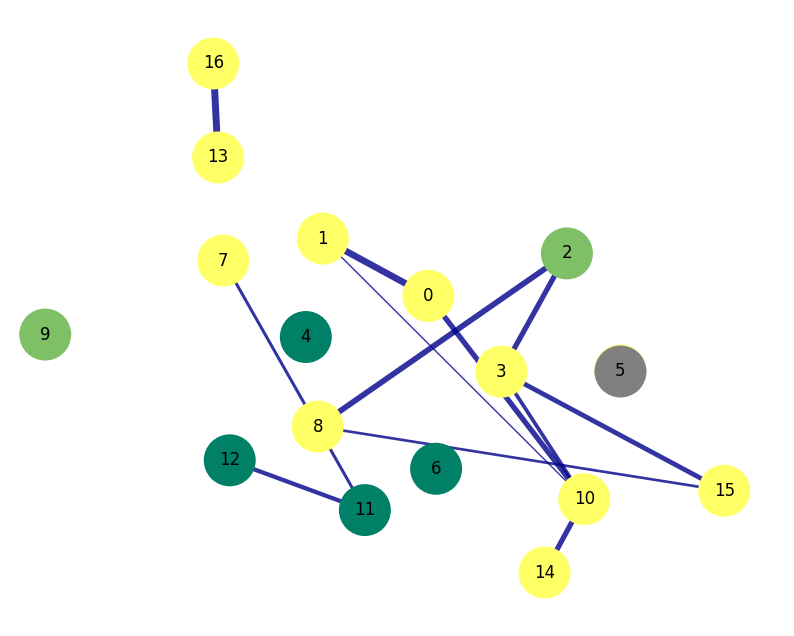


--- Eliminando nodo 6 ---
DEBUG removed=6: eps=1.0e-06, max_hat=3.11e-06, max_full_masked=7.49e-01
       edges_inferred=14, edges_gt_masked=14, mismatches_total=0
NMSE binarizada: 0.000000
Matriz reconstruida remapeada:
              0             1             2             3             4   \
0   0.000000e+00  2.971542e-06  7.207132e-08  5.836735e-08  1.757690e-07   
1   2.971542e-06  0.000000e+00  8.863119e-08  6.766173e-08  1.835031e-07   
2   7.207132e-08  8.863119e-08  0.000000e+00  2.545543e-06  1.783392e-07   
3   5.836735e-08  6.766173e-08  2.545543e-06  0.000000e+00  1.532491e-07   
4   1.757690e-07  1.835031e-07  1.783392e-07  1.532491e-07  0.000000e+00   
5   9.627515e-08  9.367700e-08  8.145111e-08  8.428428e-08  1.600518e-07   
6   0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
7   1.003472e-07  1.046052e-07  1.013149e-07  1.041215e-07  1.481184e-07   
8   8.694549e-08  8.425833e-08  2.690294e-06  6.680479e-08  1.471643e-07   
9   1.264618e-07  

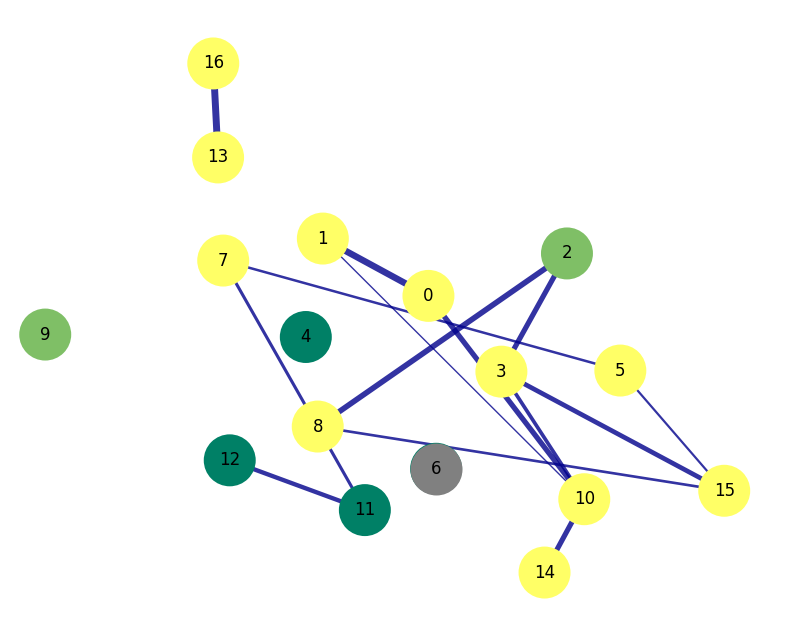


--- Eliminando nodo 7 ---
DEBUG removed=7: eps=1.0e-06, max_hat=4.36e-06, max_full_masked=7.49e-01
       edges_inferred=12, edges_gt_masked=12, mismatches_total=0
NMSE binarizada: 0.000000
Matriz reconstruida remapeada:
              0             1             2             3             4   \
0   0.000000e+00  4.208273e-06  1.708990e-08  1.384035e-08  4.167921e-08   
1   4.208273e-06  0.000000e+00  2.101666e-08  1.604428e-08  4.351316e-08   
2   1.708990e-08  2.101666e-08  0.000000e+00  3.580503e-06  4.228867e-08   
3   1.384035e-08  1.604428e-08  3.580503e-06  0.000000e+00  3.633919e-08   
4   4.167921e-08  4.351316e-08  4.228867e-08  3.633919e-08  0.000000e+00   
5   2.282923e-08  2.221315e-08  1.931409e-08  1.998590e-08  3.795226e-08   
6   3.253289e-08  3.554210e-08  3.643815e-08  2.997828e-08  5.414616e-08   
7   0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
8   2.061694e-08  1.997975e-08  3.793634e-06  1.584108e-08  3.489632e-08   
9   2.998723e-08  

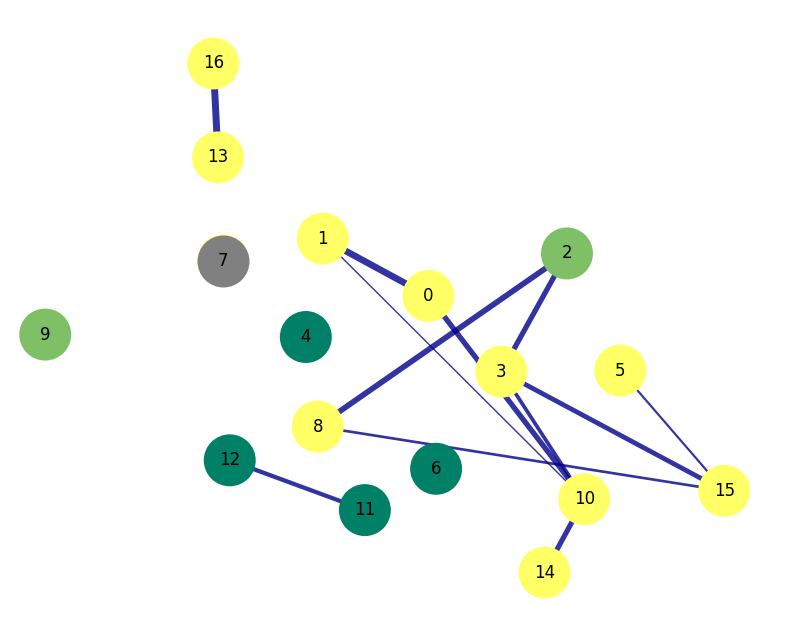


--- Eliminando nodo 8 ---
DEBUG removed=8: eps=1.0e-06, max_hat=4.75e-06, max_full_masked=7.49e-01
       edges_inferred=12, edges_gt_masked=12, mismatches_total=0
NMSE binarizada: 0.000000
Matriz reconstruida remapeada:
              0             1             2             3             4   \
0   0.000000e+00  4.591989e-06  1.836477e-08  1.487281e-08  4.478839e-08   
1   4.591989e-06  0.000000e+00  2.258446e-08  1.724115e-08  4.675914e-08   
2   1.836477e-08  2.258446e-08  0.000000e+00  3.906897e-06  4.544331e-08   
3   1.487281e-08  1.724115e-08  3.906897e-06  0.000000e+00  3.905001e-08   
4   4.478839e-08  4.675914e-08  4.544331e-08  3.905001e-08  0.000000e+00   
5   2.453224e-08  2.387020e-08  2.075487e-08  2.147681e-08  4.078341e-08   
6   3.495977e-08  3.819346e-08  3.915636e-08  3.221459e-08  5.818535e-08   
7   2.556985e-08  2.665485e-08  2.581644e-08  2.653160e-08  3.774262e-08   
8   0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
9   3.222421e-08  

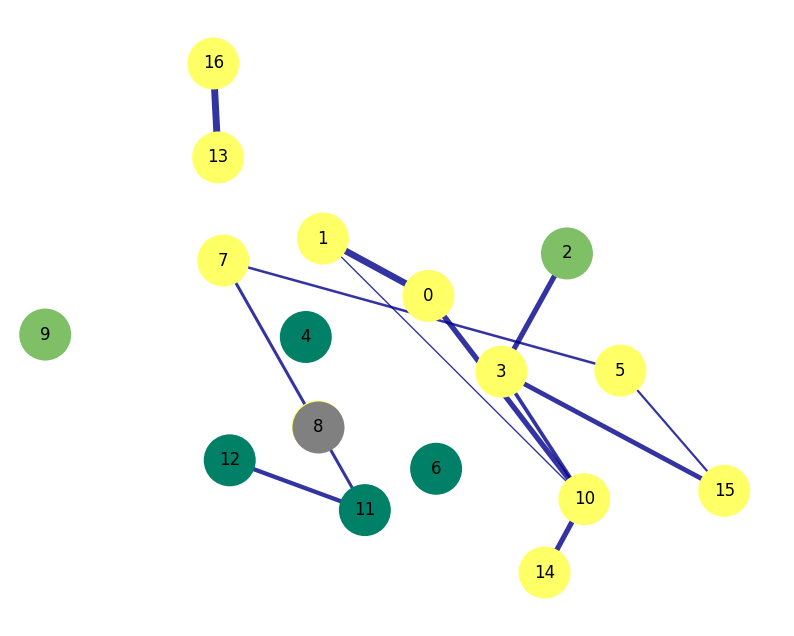


--- Eliminando nodo 9 ---
DEBUG removed=9: eps=1.0e-06, max_hat=3.25e-06, max_full_masked=7.49e-01
       edges_inferred=14, edges_gt_masked=14, mismatches_total=0
NMSE binarizada: 0.000000
Matriz reconstruida remapeada:
              0             1             2             3             4   \
0   0.000000e+00  3.109349e-06  6.284822e-08  5.089797e-08  1.532755e-07   
1   3.109349e-06  0.000000e+00  7.728889e-08  5.900293e-08  1.600199e-07   
2   6.284822e-08  7.728889e-08  0.000000e+00  2.659975e-06  1.555168e-07   
3   5.089797e-08  5.900293e-08  2.659975e-06  0.000000e+00  1.336376e-07   
4   1.532755e-07  1.600199e-07  1.555168e-07  1.336376e-07  0.000000e+00   
5   8.395464e-08  8.168899e-08  7.102766e-08  7.349827e-08  1.395696e-07   
6   1.196399e-07  1.307063e-07  1.340015e-07  1.102453e-07  1.991228e-07   
7   8.750555e-08  9.121867e-08  8.834944e-08  9.079686e-08  1.291634e-07   
8   7.581892e-08  7.347564e-08  2.812642e-06  5.825565e-08  1.283314e-07   
9   0.000000e+00  

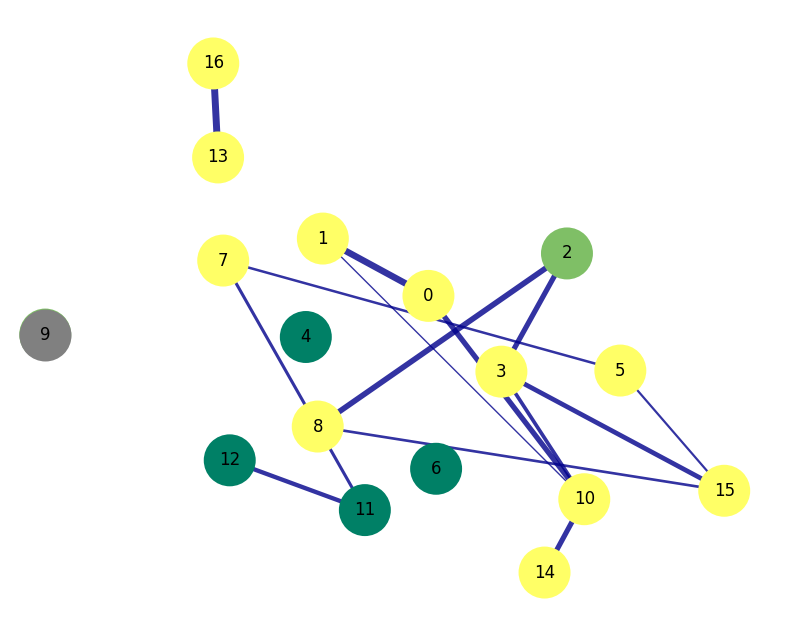


--- Eliminando nodo 10 ---
DEBUG removed=10: eps=1.0e-06, max_hat=6.75e-06, max_full_masked=7.49e-01
       edges_inferred=10, edges_gt_masked=10, mismatches_total=0
NMSE binarizada: 0.000000
Matriz reconstruida remapeada:
          0         1         2         3    4         5    6         7   \
0   0.000000  0.000007  0.000000  0.000000  0.0  0.000000  0.0  0.000000   
1   0.000007  0.000000  0.000000  0.000000  0.0  0.000000  0.0  0.000000   
2   0.000000  0.000000  0.000000  0.000006  0.0  0.000000  0.0  0.000000   
3   0.000000  0.000000  0.000006  0.000000  0.0  0.000000  0.0  0.000000   
4   0.000000  0.000000  0.000000  0.000000  0.0  0.000000  0.0  0.000000   
5   0.000000  0.000000  0.000000  0.000000  0.0  0.000000  0.0  0.000004   
6   0.000000  0.000000  0.000000  0.000000  0.0  0.000000  0.0  0.000000   
7   0.000000  0.000000  0.000000  0.000000  0.0  0.000004  0.0  0.000000   
8   0.000000  0.000000  0.000006  0.000000  0.0  0.000000  0.0  0.000000   
9   0.000000  0.

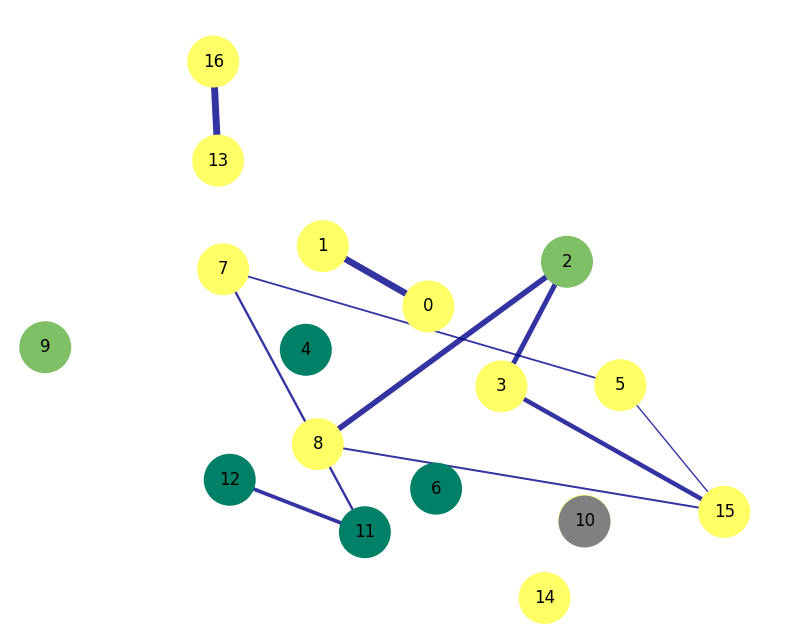


--- Eliminando nodo 11 ---
DEBUG removed=11: eps=1.0e-06, max_hat=4.32e-06, max_full_masked=7.49e-01
       edges_inferred=12, edges_gt_masked=12, mismatches_total=0
NMSE binarizada: 0.000000
Matriz reconstruida remapeada:
              0             1             2             3             4   \
0   0.000000e+00  4.160593e-06  4.022425e-08  3.257583e-08  9.809975e-08   
1   4.160593e-06  0.000000e+00  4.946661e-08  3.776319e-08  1.024163e-07   
2   4.022425e-08  4.946661e-08  0.000000e+00  3.546654e-06  9.953421e-08   
3   3.257583e-08  3.776319e-08  3.546654e-06  0.000000e+00  8.553101e-08   
4   9.809975e-08  1.024163e-07  9.953421e-08  8.553101e-08  0.000000e+00   
5   5.373283e-08  5.228276e-08  4.545928e-08  4.704052e-08  8.932767e-08   
6   7.657218e-08  8.365492e-08  8.576393e-08  7.055943e-08  1.274430e-07   
7   5.600549e-08  5.838197e-08  5.654560e-08  5.811201e-08  8.266743e-08   
8   4.852579e-08  4.702604e-08  3.755137e-06  3.728491e-08  8.213496e-08   
9   7.058050e-08

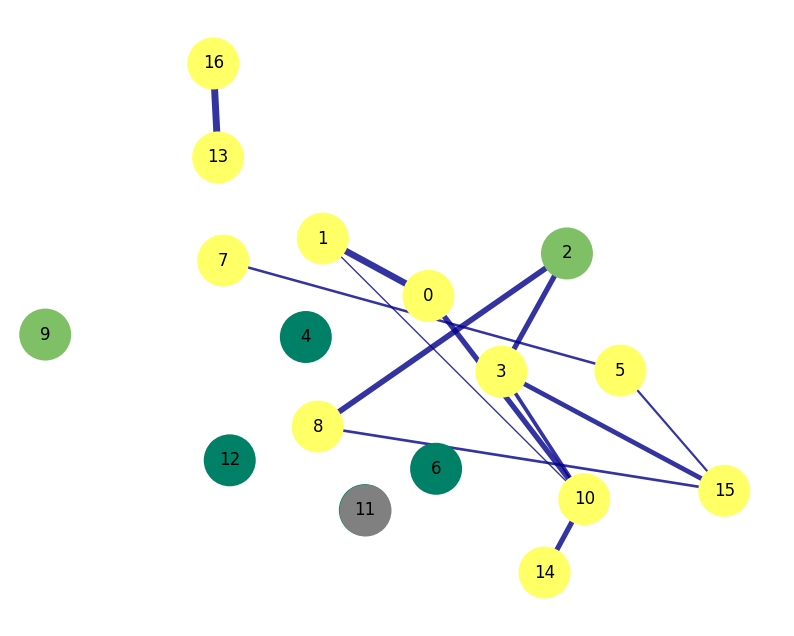


--- Eliminando nodo 12 ---
DEBUG removed=12: eps=1.0e-06, max_hat=3.41e-06, max_full_masked=7.49e-01
       edges_inferred=13, edges_gt_masked=13, mismatches_total=0
NMSE binarizada: 0.000000
Matriz reconstruida remapeada:
              0             1             2             3             4   \
0   0.000000e+00  3.256196e-06  7.477619e-08  6.055790e-08  1.823657e-07   
1   3.256196e-06  0.000000e+00  9.195756e-08  7.020111e-08  1.903901e-07   
2   7.477619e-08  9.195756e-08  0.000000e+00  2.788180e-06  1.850324e-07   
3   6.055790e-08  7.020111e-08  2.788180e-06  0.000000e+00  1.590007e-07   
4   1.823657e-07  1.903901e-07  1.850324e-07  1.590007e-07  0.000000e+00   
5   9.988840e-08  9.719275e-08  8.450801e-08  8.744752e-08  1.660586e-07   
6   1.423464e-07  1.555130e-07  1.594337e-07  1.311688e-07  2.369144e-07   
7   1.041132e-07  1.085311e-07  1.051173e-07  1.080292e-07  1.536773e-07   
8   9.020860e-08  8.742059e-08  2.947199e-06  6.931200e-08  1.526875e-07   
9   1.312079e-07

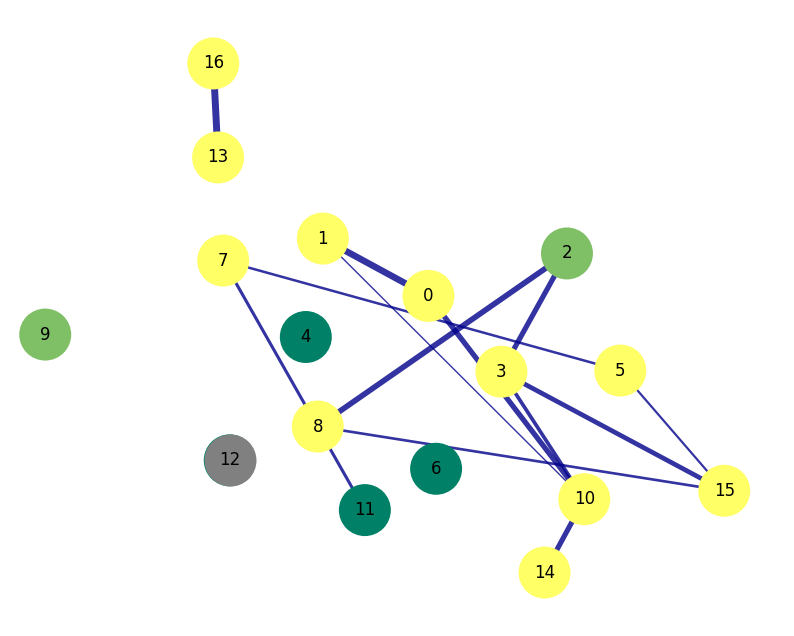


--- Eliminando nodo 13 ---
DEBUG removed=13: eps=1.0e-06, max_hat=5.21e-06, max_full_masked=7.25e-01
       edges_inferred=13, edges_gt_masked=13, mismatches_total=0
NMSE binarizada: 0.000000
Matriz reconstruida remapeada:
          0         1         2         3    4         5    6         7   \
0   0.000000  0.000005  0.000000  0.000000  0.0  0.000000  0.0  0.000000   
1   0.000005  0.000000  0.000000  0.000000  0.0  0.000000  0.0  0.000000   
2   0.000000  0.000000  0.000000  0.000004  0.0  0.000000  0.0  0.000000   
3   0.000000  0.000000  0.000004  0.000000  0.0  0.000000  0.0  0.000000   
4   0.000000  0.000000  0.000000  0.000000  0.0  0.000000  0.0  0.000000   
5   0.000000  0.000000  0.000000  0.000000  0.0  0.000000  0.0  0.000003   
6   0.000000  0.000000  0.000000  0.000000  0.0  0.000000  0.0  0.000000   
7   0.000000  0.000000  0.000000  0.000000  0.0  0.000003  0.0  0.000000   
8   0.000000  0.000000  0.000005  0.000000  0.0  0.000000  0.0  0.000000   
9   0.000000  0.

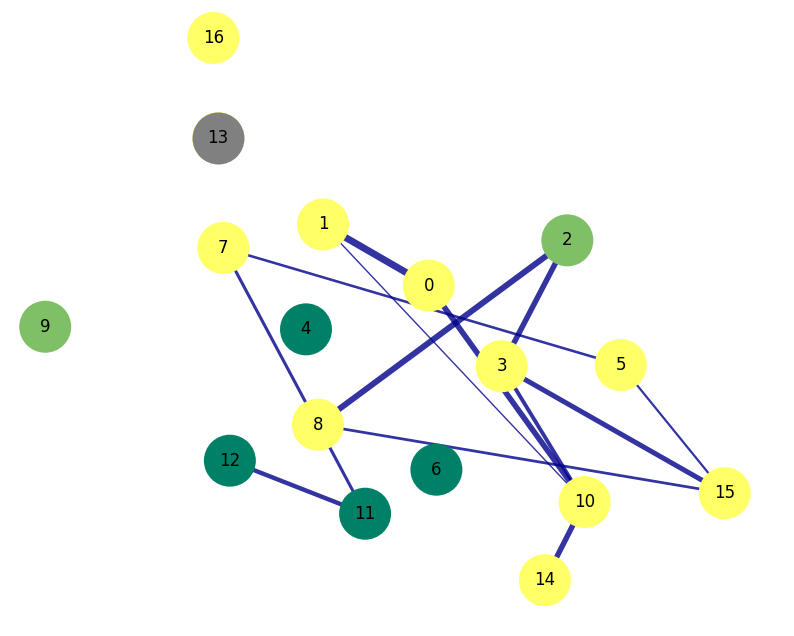


--- Eliminando nodo 14 ---
DEBUG removed=14: eps=1.0e-06, max_hat=1.97e-06, max_full_masked=7.49e-01
       edges_inferred=12, edges_gt_masked=13, mismatches_total=2
       sample mismatches (i,j): [[1, 10], [10, 1]]
         mismatch (1,10): Ah=8.77e-07, Af=-3.14e-01
         mismatch (10,1): Ah=8.77e-07, Af=-3.14e-01
NMSE binarizada: 0.277350
Matriz reconstruida remapeada:
              0             1             2             3             4   \
0   0.000000e+00  1.821858e-06  1.474964e-07  1.194508e-07  3.597174e-07   
1   1.821858e-06  0.000000e+00  1.813868e-07  1.384721e-07  3.755455e-07   
2   1.474964e-07  1.813868e-07  0.000000e+00  1.590432e-06  3.649774e-07   
3   1.194508e-07  1.384721e-07  1.590432e-06  0.000000e+00  3.136297e-07   
4   3.597174e-07  3.755455e-07  3.649774e-07  3.136297e-07  0.000000e+00   
5   1.970304e-07  1.917132e-07  1.666925e-07  1.724907e-07  3.275515e-07   
6   2.807790e-07  3.067503e-07  3.144838e-07  2.587311e-07  4.673149e-07   
7   2.053639e

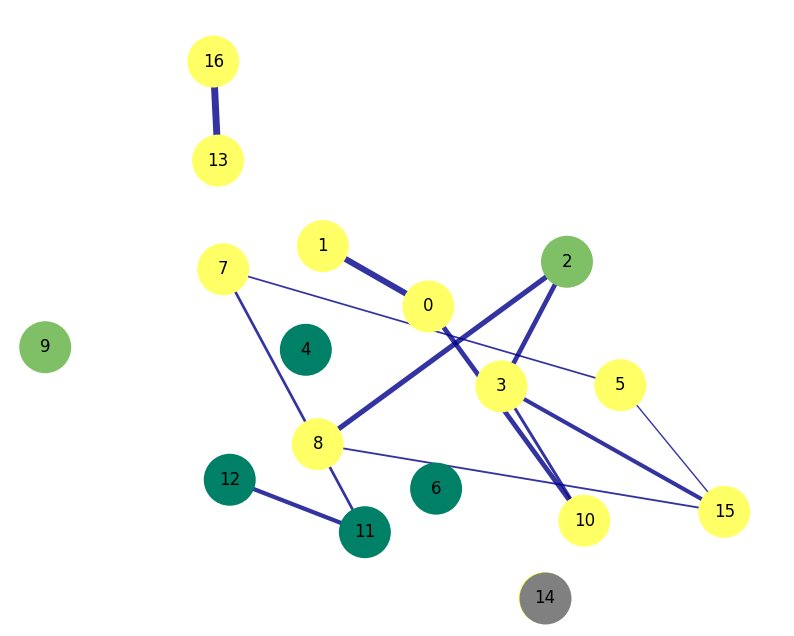


--- Eliminando nodo 15 ---
DEBUG removed=15: eps=1.0e-06, max_hat=4.30e-06, max_full_masked=7.49e-01
       edges_inferred=11, edges_gt_masked=11, mismatches_total=0
NMSE binarizada: 0.000000
Matriz reconstruida remapeada:
              0             1             2             3             4   \
0   0.000000e+00  4.134560e-06  4.684575e-08  3.793829e-08  1.142484e-07   
1   4.134560e-06  0.000000e+00  5.760953e-08  4.397955e-08  1.192755e-07   
2   4.684575e-08  5.760953e-08  0.000000e+00  3.526442e-06  1.159190e-07   
3   3.793829e-08  4.397955e-08  3.526442e-06  0.000000e+00  9.961066e-08   
4   1.142484e-07  1.192755e-07  1.159190e-07  9.961066e-08  0.000000e+00   
5   6.257804e-08  6.088926e-08  5.294254e-08  5.478408e-08  1.040323e-07   
6   8.917707e-08  9.742572e-08  9.988192e-08  8.217453e-08  1.484220e-07   
7   6.522481e-08  6.799249e-08  6.585383e-08  6.767809e-08  9.627569e-08   
8   5.651384e-08  5.476721e-08  3.732962e-06  4.342255e-08  9.565556e-08   
9   8.219908e-08

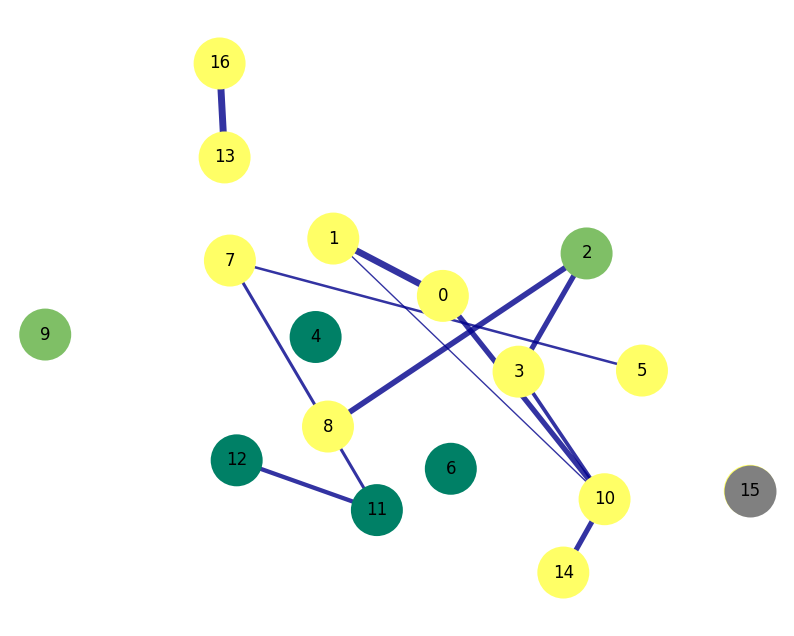


--- Eliminando nodo 16 ---
DEBUG removed=16: eps=1.0e-06, max_hat=4.84e-06, max_full_masked=7.25e-01
       edges_inferred=13, edges_gt_masked=13, mismatches_total=0
NMSE binarizada: 0.000000
Matriz reconstruida remapeada:
              0             1             2             3             4   \
0   0.000000e+00  4.840540e-06  7.204660e-10  5.834737e-10  1.757087e-09   
1   4.840540e-06  0.000000e+00  8.860065e-10  6.763853e-10  1.834405e-09   
2   7.204660e-10  8.860065e-10  0.000000e+00  4.112997e-06  1.782776e-09   
3   5.834737e-10  6.763853e-10  4.112997e-06  0.000000e+00  1.531967e-09   
4   1.757087e-09  1.834405e-09  1.782776e-09  1.531967e-09  0.000000e+00   
5   9.624223e-10  9.364489e-10  8.142318e-10  8.425541e-10  1.599969e-09   
6   1.371502e-09  1.498364e-09  1.536138e-09  1.263808e-09  2.282658e-09   
7   1.003125e-09  1.045695e-09  1.012801e-09  1.040858e-09  1.480677e-09   
8   8.691596e-10  8.422957e-10  4.359963e-06  6.678185e-10  1.471139e-09   
9   1.264188e-09

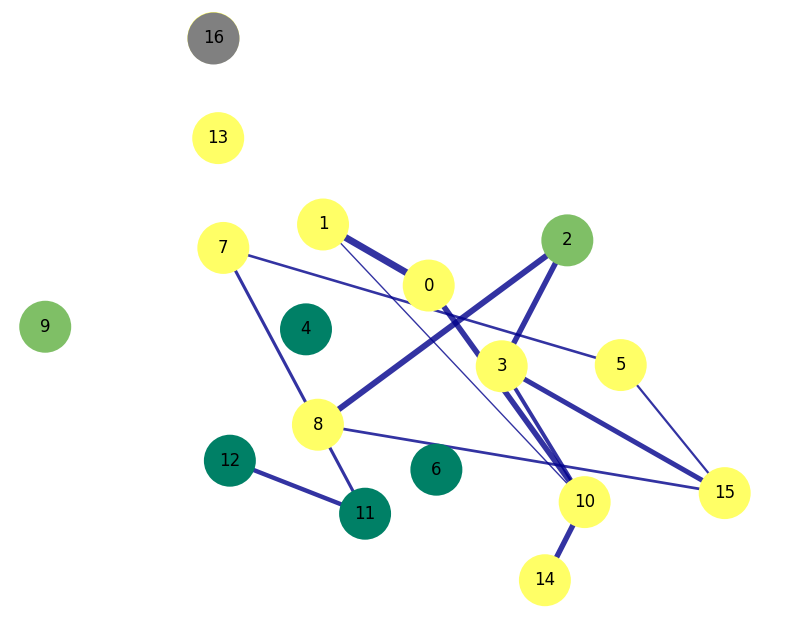


NMSE por nodo eliminado:
    node     nmse
0      0  0.00000
1      1  0.00000
2      2  0.00000
3      3  0.00000
4      4  0.00000
5      5  0.00000
6      6  0.00000
7      7  0.00000
8      8  0.00000
9      9  0.00000
10    10  0.00000
11    11  0.00000
12    12  0.00000
13    13  0.00000
14    14  0.27735
15    15  0.00000
16    16  0.00000
mean and median nmse: 0.01631471165368321 0.0


In [198]:
lambda_reg = 20            
epsilon    = 1e-6         
results = []

for s in range(N):
    print(f"\n--- removing node {s} ---")
    P = construct_P(N, s)

    A_tilde_small = evaluate_graph_stability_fast(A, X, P, lambda_reg, eps=1e-3)
    # A_tilde_small = evaluate_graph_stability(A, X, P, lambda_reg)

    nmse, A_hat_bin, A_full_bin = calculate_nmse_with_mask_and_binarize(A_tilde_small, A, s, eps=epsilon)
    print(f"NMSE binarized: {nmse:.6f}")
    results.append({'node': s, 'nmse': nmse})

    A_cont = remap_A_hat(A_tilde_small, s)
    W_recon_df = pd.DataFrame(A_cont)
    print("refinment matrix:")
    print(W_recon_df)

    pos_removed = tuple(coords[s]) 
    plot_graph_(
        W            = W_recon_df,
        df_info      = df,
        pos_removed  = pos_removed,
        removed_node = s,
        epsilon      = epsilon, 
        save_svg     = False,
        out_dir      = path, 
        filename     = f"graph_stable_glasso_drop{s}.svg", 
        show=True
    )

# 6) Resumen final
df_results = pd.DataFrame(results)
print("\nNMSE:")
print(df_results)
mean_nmse = df_results['nmse'].mean()
median_nmse = df_results['nmse'].median()
print("mean and median nmse:", mean_nmse, median_nmse)


### KNN

In [112]:
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import normalize
from scipy.sparse.csgraph import laplacian as csgraph_laplacian

In [135]:
def knn_graph(X, k=5, metric='cosine', symmetrize='mutual',
              weighted='gaussian', sigma='median', self_loops=False):
    X = normalize(np.asarray(X, float), norm='l2', axis=1)  
    D = kneighbors_graph(X, n_neighbors=k, mode='distance',
                         metric=metric, include_self=self_loops, n_jobs=-1).tocsr()
    
    D = D.maximum(D.T) if symmetrize == 'union' else D.minimum(D.T)
   
    W = D.copy()
    if weighted == 'binary':
        W.data[:] = 1.0
    elif weighted == 'distance':
        W.data = 1.0 / (W.data + 1e-9)
    elif weighted == 'gaussian':
        d = W.data
        s = (np.median(d) if sigma == 'median' else float(sigma)) or 1.0
        W.data = np.exp(-(d**2)/(2*s**2))
    else:
        raise ValueError("weighted must be 'gaussian' | 'binary' | 'distance'")

    if not self_loops:
        W.setdiag(0.0); W.eliminate_zeros()

   
    L = csgraph_laplacian(W, normed=False)
    L_norm = csgraph_laplacian(W, normed=True)
    return W, L, L_norm

In [136]:
def knn_similarity_df(X, k=4, metric='cosine', symmetrize='mutual',
                      weighted='gaussian', sigma='median', node_ids=None):
    W, _, _ = knn_graph(X, k=k, metric=metric, symmetrize=symmetrize,
                        weighted=weighted, sigma=sigma)
    A = W.toarray()
    np.fill_diagonal(A, 0.0)
    n = A.shape[0]

    if node_ids is None:
        node_ids = np.arange(n)  # 0,1,2,...,n-1
    return pd.DataFrame(A, index=node_ids, columns=node_ids)

/opt/anaconda3/envs/pyunlocbox-env/lib/python3.10/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


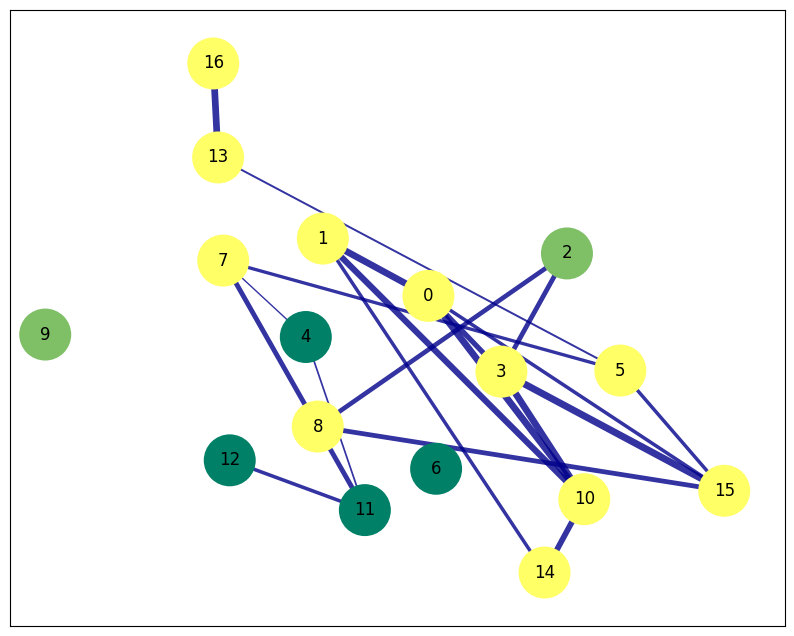

In [137]:
matrix_knn = knn_similarity_df(X, k=4, metric='cosine',
                               symmetrize='mutual', weighted='gaussian', sigma='median')

G_knn, G_all= plot_network(matrix_knn,0.1,same_posicion_data,df) 

In [176]:
matrix_knn

0         1         2         3         4         5    6         7   \
0   0.000000  0.739711  0.000000  0.636272  0.000000  0.000000  0.0  0.000000   
1   0.739711  0.000000  0.000000  0.000000  0.000000  0.000000  0.0  0.000000   
2   0.000000  0.000000  0.000000  0.606293  0.000000  0.000000  0.0  0.000000   
3   0.636272  0.000000  0.606293  0.000000  0.000000  0.000000  0.0  0.000000   
4   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.0  0.368842   
5   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.0  0.503664   
6   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.0  0.000000   
7   0.000000  0.000000  0.000000  0.000000  0.368842  0.503664  0.0  0.000000   
8   0.000000  0.000000  0.595748  0.000000  0.000000  0.000000  0.0  0.000000   
9   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.0  0.000000   
10  0.746577  0.703379  0.000000  0.745202  0.000000  0.000000  0.0  0.000000   
11  0.000000  0.000000  0.000000  0.000000  0.392675  0.000000  0.0  0.612063   
12  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.0  0.000000   
13  0.000000  0.000000  0.000000  0.000000  0.000000  0.409693  0.0  0.000000   
14  0.000000  0.515762  0.000000  0.000000  0.000000  0.000000  0.0  0.000000   
15  0.519609  0.000000  0.000000  0.759152  0.000000  0.515836  0.0  0.000000   
16  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.0  0.000000   

          8    9         10        11        12        13        14        15  \
0   0.000000  0.0  0.746577  0.000000  0.000000  0.000000  0.000000  0.519609   
1   0.000000  0.0  0.703379  0.000000  0.000000  0.000000  0.515762  0.000000   
2   0.595748  0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
3   0.000000  0.0  0.745202  0.000000  0.000000  0.000000  0.000000  0.759152   
4   0.000000  0.0  0.000000  0.392675  0.000000  0.000000  0.000000  0.000000   
5   0.000000  0.0  0.000000  0.000000  0.000000  0.409693  0.000000  0.515836   
6   0.000000  0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
7   0.000000  0.0  0.000000  0.612063  0.000000  0.000000  0.000000  0.000000   
8   0.000000  0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.606768   
9   0.000000  0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
10  0.000000  0.0  0.000000  0.000000  0.000000  0.000000  0.672274  0.000000   
11  0.000000  0.0  0.000000  0.000000  0.522057  0.000000  0.000000  0.000000   
12  0.000000  0.0  0.000000  0.522057  0.000000  0.000000  0.000000  0.000000   
13  0.000000  0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
14  0.000000  0.0  0.672274  0.000000  0.000000  0.000000  0.000000  0.000000   
15  0.606768  0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
16  0.000000  0.0  0.000000  0.000000  0.000000  0.742484  0.000000  0.000000   

          16  
0   0.000000  
1   0.000000  
2   0.000000  
3   0.000000  
4   0.000000  
5   0.000000  
6   0.000000  
7   0.000000  
8   0.000000  
9   0.000000  
10  0.000000  
11  0.000000  
12  0.000000  
13  0.742484  
14  0.000000  
15  0.000000  
16  0.000000

In [216]:
X = df_norm.values 
A = matrix_knn.values
N = X.shape[0]  
F = X.shape[1]  


#### Refinement Loop


--- Eliminando nodo 0 ---
DEBUG removed=0: eps=1.0e-07, max_hat=5.68e-06, max_full_masked=7.59e-01
       edges_inferred=16, edges_gt_masked=16, mismatches_total=0
NMSE binarizada: 0.000000
Matriz reconstruida remapeada:
     0         1         2         3         4         5    6         7   \
0   0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.0  0.000000   
1   0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.0  0.000000   
2   0.0  0.000000  0.000000  0.000004  0.000000  0.000000  0.0  0.000000   
3   0.0  0.000000  0.000004  0.000000  0.000000  0.000000  0.0  0.000000   
4   0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.0  0.000002   
5   0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.0  0.000004   
6   0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.0  0.000000   
7   0.0  0.000000  0.000000  0.000000  0.000002  0.000004  0.0  0.000000   
8   0.0  0.000000  0.000004  0.000000  0.000000  0.000000  0.0  0.000000   
9   0.0  0.000000 

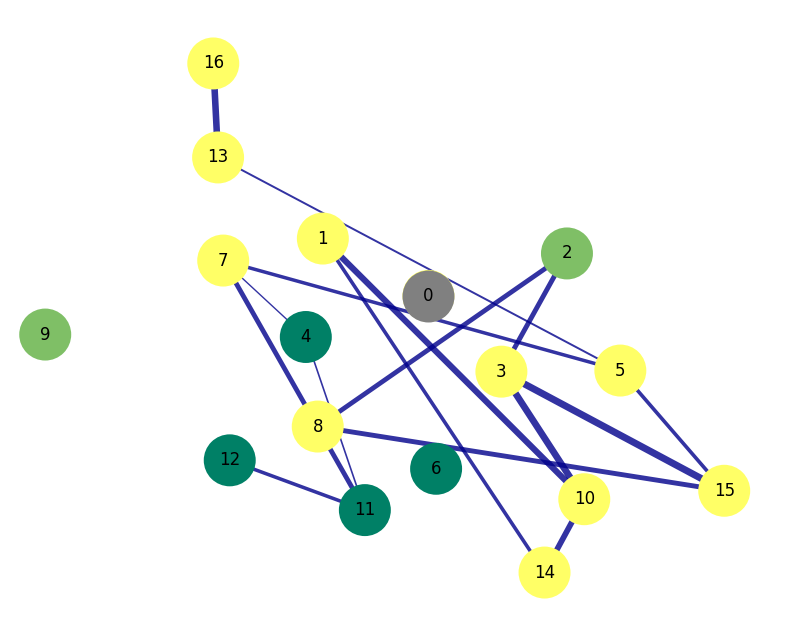


--- Eliminando nodo 1 ---
DEBUG removed=1: eps=1.0e-07, max_hat=3.32e-06, max_full_masked=7.59e-01
       edges_inferred=17, edges_gt_masked=17, mismatches_total=0
NMSE binarizada: 0.000000
Matriz reconstruida remapeada:
          0    1         2         3         4         5    6         7   \
0   0.000000  0.0  0.000000  0.000003  0.000000  0.000000  0.0  0.000000   
1   0.000000  0.0  0.000000  0.000000  0.000000  0.000000  0.0  0.000000   
2   0.000000  0.0  0.000000  0.000003  0.000000  0.000000  0.0  0.000000   
3   0.000003  0.0  0.000003  0.000000  0.000000  0.000000  0.0  0.000000   
4   0.000000  0.0  0.000000  0.000000  0.000000  0.000000  0.0  0.000001   
5   0.000000  0.0  0.000000  0.000000  0.000000  0.000000  0.0  0.000002   
6   0.000000  0.0  0.000000  0.000000  0.000000  0.000000  0.0  0.000000   
7   0.000000  0.0  0.000000  0.000000  0.000001  0.000002  0.0  0.000000   
8   0.000000  0.0  0.000003  0.000000  0.000000  0.000000  0.0  0.000000   
9   0.000000  0.0 

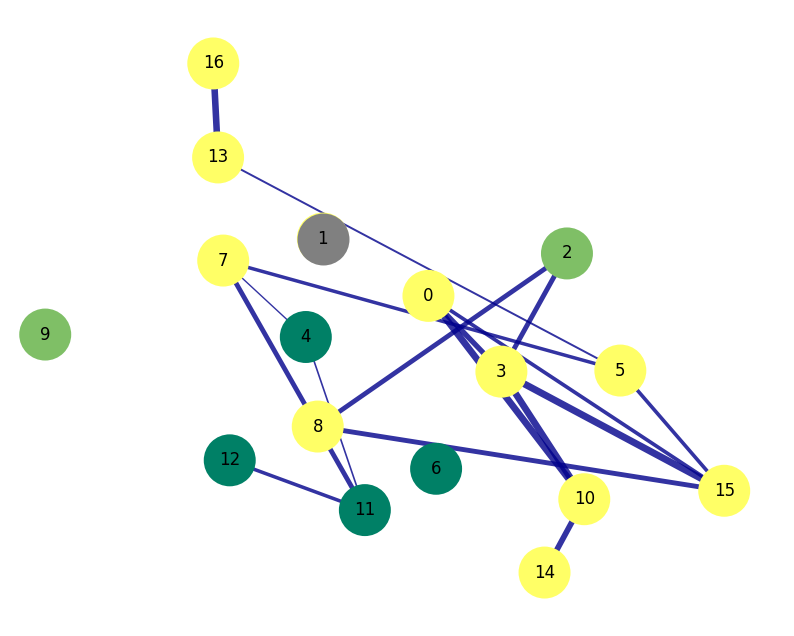


--- Eliminando nodo 2 ---
DEBUG removed=2: eps=1.0e-07, max_hat=3.51e-04, max_full_masked=7.59e-01
       edges_inferred=18, edges_gt_masked=18, mismatches_total=0
NMSE binarizada: 0.000000
Matriz reconstruida remapeada:
          0         1    2         3         4         5    6         7   \
0   0.000000  0.000343  0.0  0.000291  0.000000  0.000000  0.0  0.000000   
1   0.000343  0.000000  0.0  0.000000  0.000000  0.000000  0.0  0.000000   
2   0.000000  0.000000  0.0  0.000000  0.000000  0.000000  0.0  0.000000   
3   0.000291  0.000000  0.0  0.000000  0.000000  0.000000  0.0  0.000000   
4   0.000000  0.000000  0.0  0.000000  0.000000  0.000000  0.0  0.000150   
5   0.000000  0.000000  0.0  0.000000  0.000000  0.000000  0.0  0.000227   
6   0.000000  0.000000  0.0  0.000000  0.000000  0.000000  0.0  0.000000   
7   0.000000  0.000000  0.0  0.000000  0.000150  0.000227  0.0  0.000000   
8   0.000000  0.000000  0.0  0.000000  0.000000  0.000000  0.0  0.000000   
9   0.000000  0.00

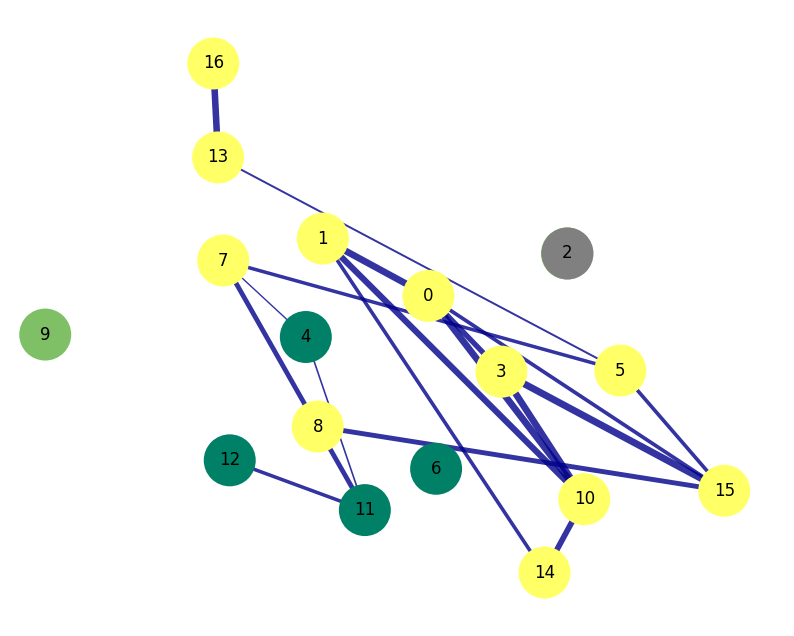


--- Eliminando nodo 3 ---
DEBUG removed=3: eps=1.0e-07, max_hat=5.48e-06, max_full_masked=7.47e-01
       edges_inferred=16, edges_gt_masked=16, mismatches_total=0
NMSE binarizada: 0.000000
Matriz reconstruida remapeada:
          0         1         2    3         4         5    6         7   \
0   0.000000  0.000005  0.000000  0.0  0.000000  0.000000  0.0  0.000000   
1   0.000005  0.000000  0.000000  0.0  0.000000  0.000000  0.0  0.000000   
2   0.000000  0.000000  0.000000  0.0  0.000000  0.000000  0.0  0.000000   
3   0.000000  0.000000  0.000000  0.0  0.000000  0.000000  0.0  0.000000   
4   0.000000  0.000000  0.000000  0.0  0.000000  0.000000  0.0  0.000002   
5   0.000000  0.000000  0.000000  0.0  0.000000  0.000000  0.0  0.000004   
6   0.000000  0.000000  0.000000  0.0  0.000000  0.000000  0.0  0.000000   
7   0.000000  0.000000  0.000000  0.0  0.000002  0.000004  0.0  0.000000   
8   0.000000  0.000000  0.000004  0.0  0.000000  0.000000  0.0  0.000000   
9   0.000000  0.00

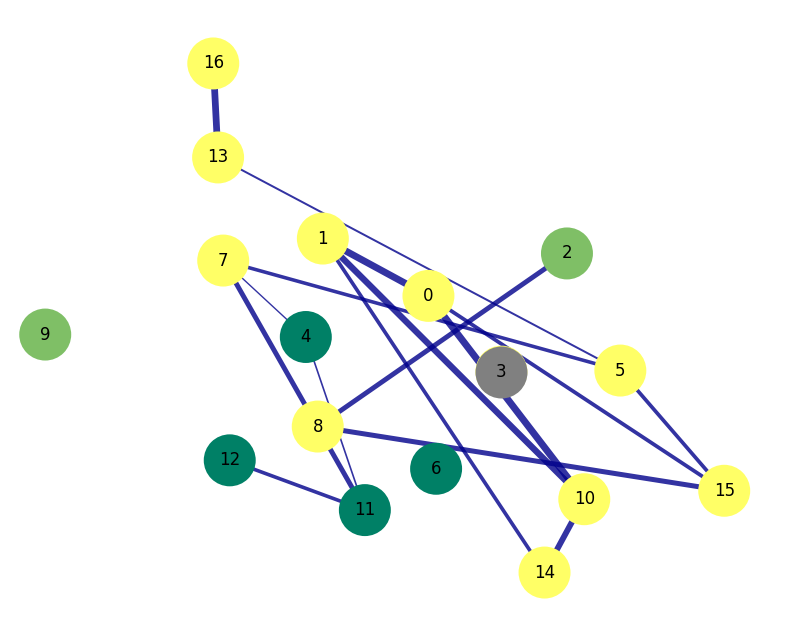


--- Eliminando nodo 4 ---
DEBUG removed=4: eps=1.0e-07, max_hat=3.69e-04, max_full_masked=7.59e-01
       edges_inferred=18, edges_gt_masked=18, mismatches_total=0
NMSE binarizada: 0.000000
Matriz reconstruida remapeada:
          0         1         2         3    4         5    6         7   \
0   0.000000  0.000360  0.000000  0.000306  0.0  0.000000  0.0  0.000000   
1   0.000360  0.000000  0.000000  0.000000  0.0  0.000000  0.0  0.000000   
2   0.000000  0.000000  0.000000  0.000291  0.0  0.000000  0.0  0.000000   
3   0.000306  0.000000  0.000291  0.000000  0.0  0.000000  0.0  0.000000   
4   0.000000  0.000000  0.000000  0.000000  0.0  0.000000  0.0  0.000000   
5   0.000000  0.000000  0.000000  0.000000  0.0  0.000000  0.0  0.000238   
6   0.000000  0.000000  0.000000  0.000000  0.0  0.000000  0.0  0.000000   
7   0.000000  0.000000  0.000000  0.000000  0.0  0.000238  0.0  0.000000   
8   0.000000  0.000000  0.000287  0.000000  0.0  0.000000  0.0  0.000000   
9   0.000000  0.00

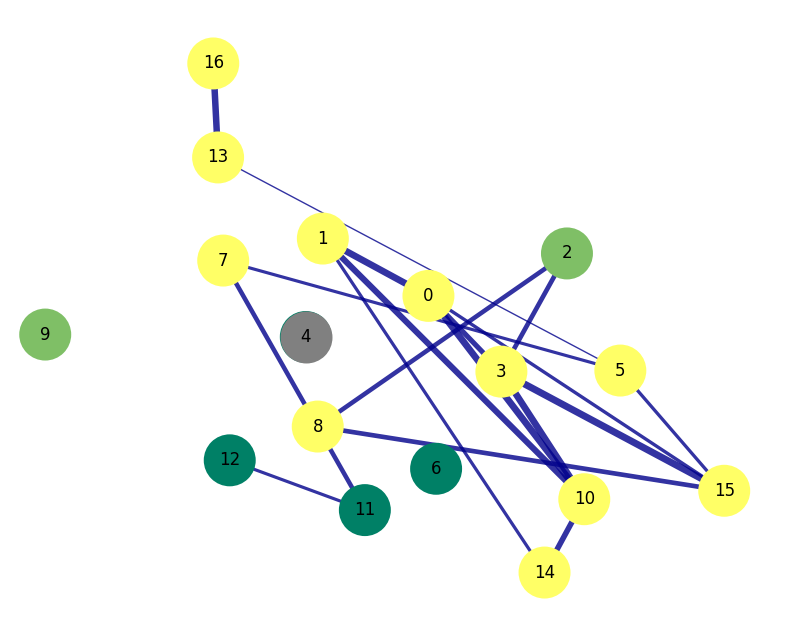


--- Eliminando nodo 5 ---
DEBUG removed=5: eps=1.0e-07, max_hat=3.47e-05, max_full_masked=7.59e-01
       edges_inferred=17, edges_gt_masked=17, mismatches_total=0
NMSE binarizada: 0.000000
Matriz reconstruida remapeada:
          0         1         2         3         4    5    6         7   \
0   0.000000  0.000034  0.000000  0.000029  0.000000  0.0  0.0  0.000000   
1   0.000034  0.000000  0.000000  0.000000  0.000000  0.0  0.0  0.000000   
2   0.000000  0.000000  0.000000  0.000027  0.000000  0.0  0.0  0.000000   
3   0.000029  0.000000  0.000027  0.000000  0.000000  0.0  0.0  0.000000   
4   0.000000  0.000000  0.000000  0.000000  0.000000  0.0  0.0  0.000015   
5   0.000000  0.000000  0.000000  0.000000  0.000000  0.0  0.0  0.000000   
6   0.000000  0.000000  0.000000  0.000000  0.000000  0.0  0.0  0.000000   
7   0.000000  0.000000  0.000000  0.000000  0.000015  0.0  0.0  0.000000   
8   0.000000  0.000000  0.000027  0.000000  0.000000  0.0  0.0  0.000000   
9   0.000000  0.00

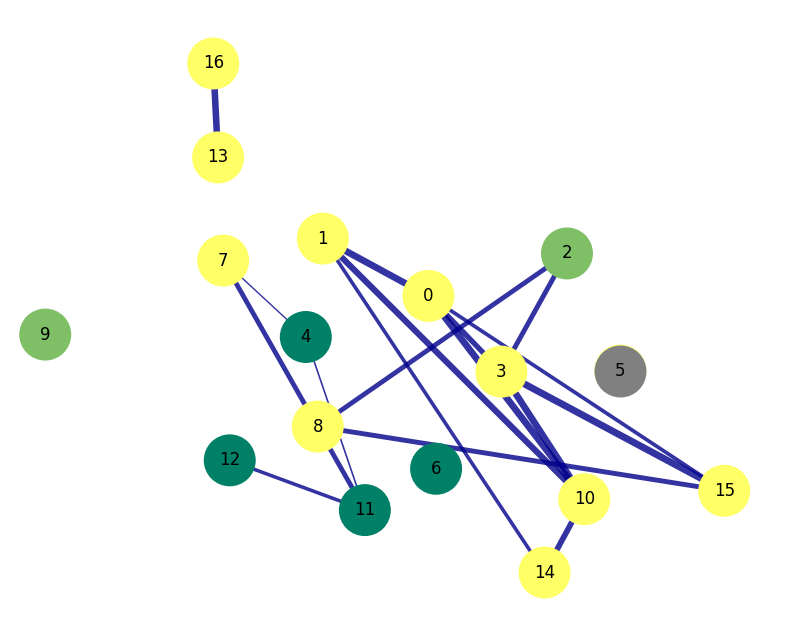


--- Eliminando nodo 6 ---
DEBUG removed=6: eps=1.0e-07, max_hat=3.08e-04, max_full_masked=7.59e-01
       edges_inferred=20, edges_gt_masked=20, mismatches_total=0
NMSE binarizada: 0.000000
Matriz reconstruida remapeada:
          0         1         2         3         4         5    6         7   \
0   0.000000  0.000300  0.000000  0.000255  0.000000  0.000000  0.0  0.000000   
1   0.000300  0.000000  0.000000  0.000000  0.000000  0.000000  0.0  0.000000   
2   0.000000  0.000000  0.000000  0.000242  0.000000  0.000000  0.0  0.000000   
3   0.000255  0.000000  0.000242  0.000000  0.000000  0.000000  0.0  0.000000   
4   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.0  0.000128   
5   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.0  0.000198   
6   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.0  0.000000   
7   0.000000  0.000000  0.000000  0.000000  0.000128  0.000198  0.0  0.000000   
8   0.000000  0.000000  0.000239  0.000000  0.000

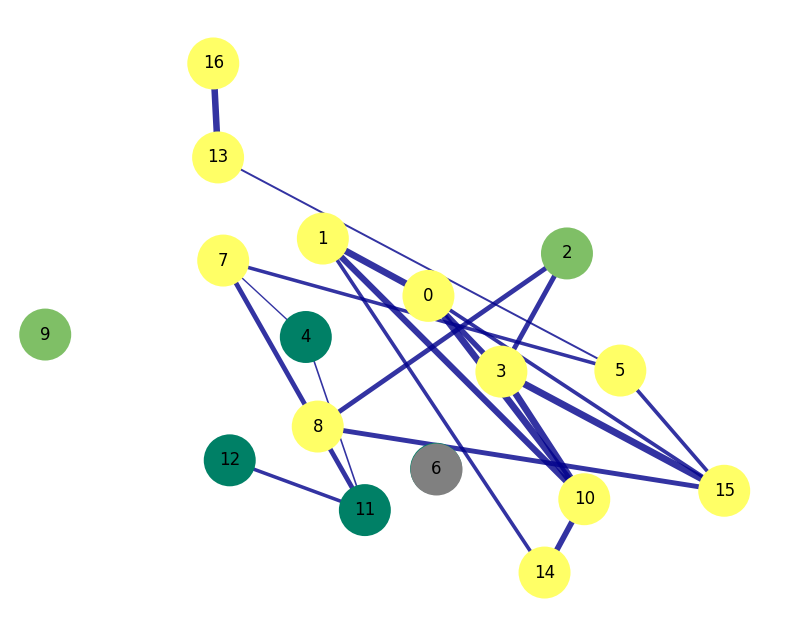


--- Eliminando nodo 7 ---
DEBUG removed=7: eps=1.0e-07, max_hat=1.27e-05, max_full_masked=7.59e-01
       edges_inferred=103, edges_gt_masked=17, mismatches_total=240
       sample mismatches (i,j): [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [0, 6], [0, 8], [0, 9], [0, 10], [0, 11], [0, 12], [0, 13], [0, 14], [0, 15], [0, 16], [1, 0], [1, 2], [1, 3], [1, 4], [1, 5]]
         mismatch (0,1): Ah=0.00e+00, Af=7.40e-01
         mismatch (0,2): Ah=3.78e-06, Af=0.00e+00
         mismatch (0,3): Ah=0.00e+00, Af=6.36e-01
         mismatch (0,4): Ah=9.23e-06, Af=0.00e+00
         mismatch (0,5): Ah=5.06e-06, Af=0.00e+00
         mismatch (0,6): Ah=7.20e-06, Af=0.00e+00
NMSE binarizada: 2.656845
Matriz reconstruida remapeada:
          0         1         2         3         4         5         6    7   \
0   0.000000  0.000000  0.000004  0.000000  0.000009  0.000005  0.000007  0.0   
1   0.000000  0.000000  0.000005  0.000004  0.000010  0.000005  0.000008  0.0   
2   0.000004  0.000005  0.000000

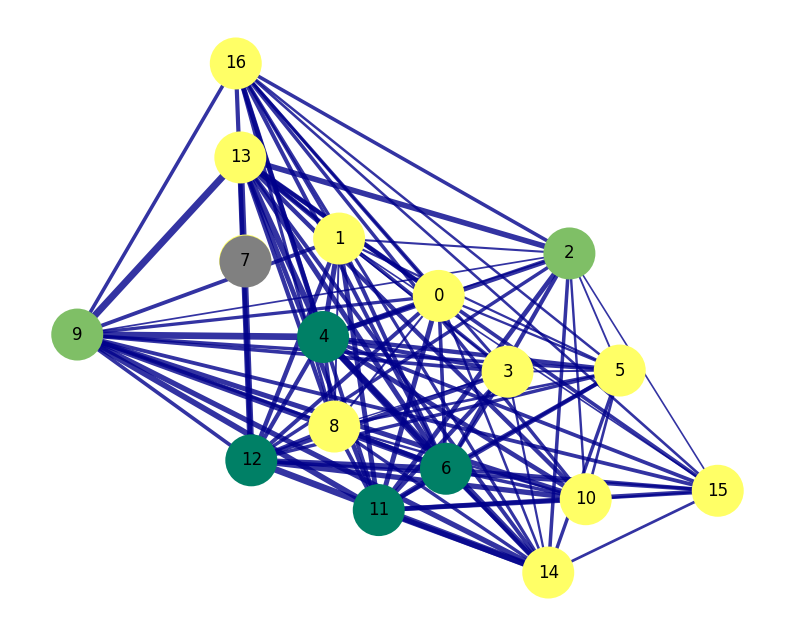


--- Eliminando nodo 8 ---
DEBUG removed=8: eps=1.0e-07, max_hat=2.51e-04, max_full_masked=7.59e-01
       edges_inferred=18, edges_gt_masked=18, mismatches_total=0
NMSE binarizada: 0.000000
Matriz reconstruida remapeada:
          0         1         2         3         4         5    6         7   \
0   0.000000  0.000245  0.000000  0.000209  0.000000  0.000000  0.0  0.000000   
1   0.000245  0.000000  0.000000  0.000000  0.000000  0.000000  0.0  0.000000   
2   0.000000  0.000000  0.000000  0.000198  0.000000  0.000000  0.0  0.000000   
3   0.000209  0.000000  0.000198  0.000000  0.000000  0.000000  0.0  0.000000   
4   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.0  0.000107   
5   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.0  0.000163   
6   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.0  0.000000   
7   0.000000  0.000000  0.000000  0.000000  0.000107  0.000163  0.0  0.000000   
8   0.000000  0.000000  0.000000  0.000000  0.000

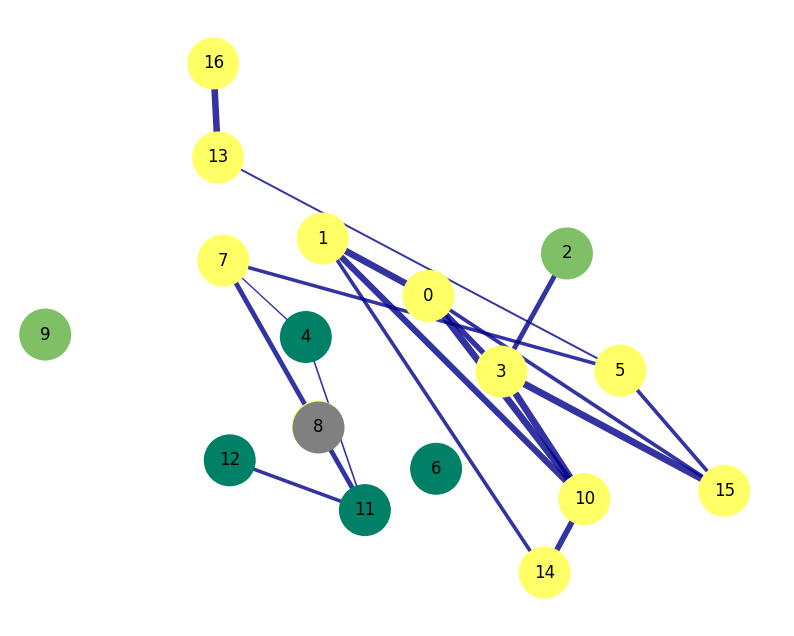


--- Eliminando nodo 9 ---
DEBUG removed=9: eps=1.0e-07, max_hat=2.47e-04, max_full_masked=7.59e-01
       edges_inferred=20, edges_gt_masked=20, mismatches_total=0
NMSE binarizada: 0.000000
Matriz reconstruida remapeada:
          0         1         2         3         4         5    6         7   \
0   0.000000  0.000241  0.000000  0.000205  0.000000  0.000000  0.0  0.000000   
1   0.000241  0.000000  0.000000  0.000000  0.000000  0.000000  0.0  0.000000   
2   0.000000  0.000000  0.000000  0.000194  0.000000  0.000000  0.0  0.000000   
3   0.000205  0.000000  0.000194  0.000000  0.000000  0.000000  0.0  0.000000   
4   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.0  0.000103   
5   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.0  0.000159   
6   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.0  0.000000   
7   0.000000  0.000000  0.000000  0.000000  0.000103  0.000159  0.0  0.000000   
8   0.000000  0.000000  0.000191  0.000000  0.000

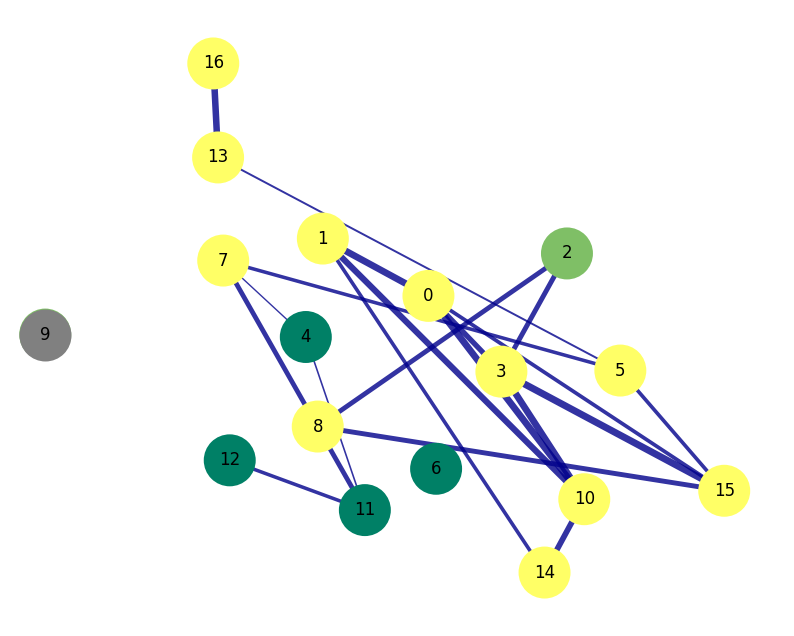


--- Eliminando nodo 10 ---
DEBUG removed=10: eps=1.0e-07, max_hat=5.31e-06, max_full_masked=7.59e-01
       edges_inferred=16, edges_gt_masked=16, mismatches_total=0
NMSE binarizada: 0.000000
Matriz reconstruida remapeada:
          0         1         2         3         4         5    6         7   \
0   0.000000  0.000005  0.000000  0.000004  0.000000  0.000000  0.0  0.000000   
1   0.000005  0.000000  0.000000  0.000000  0.000000  0.000000  0.0  0.000000   
2   0.000000  0.000000  0.000000  0.000004  0.000000  0.000000  0.0  0.000000   
3   0.000004  0.000000  0.000004  0.000000  0.000000  0.000000  0.0  0.000000   
4   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.0  0.000002   
5   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.0  0.000003   
6   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.0  0.000000   
7   0.000000  0.000000  0.000000  0.000000  0.000002  0.000003  0.0  0.000000   
8   0.000000  0.000000  0.000004  0.000000  0.0

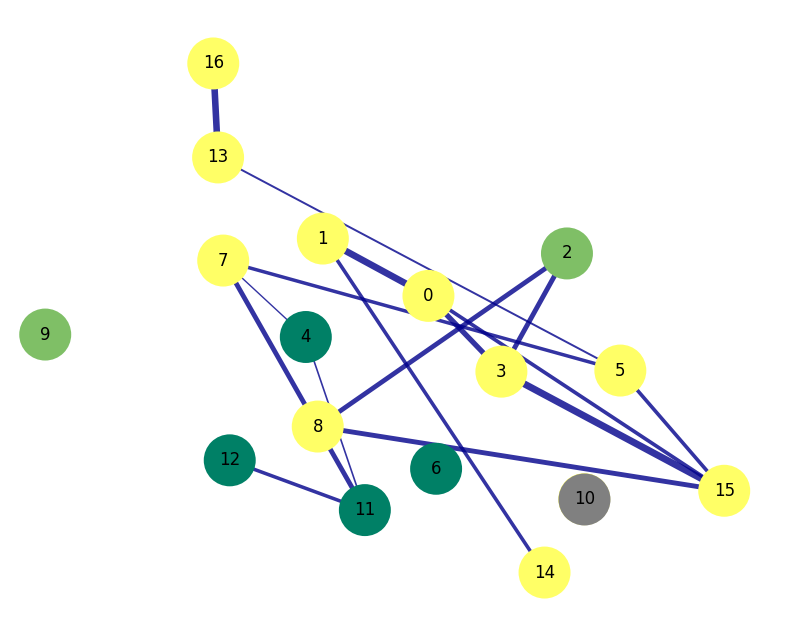


--- Eliminando nodo 11 ---
DEBUG removed=11: eps=1.0e-07, max_hat=5.47e-04, max_full_masked=7.59e-01
       edges_inferred=17, edges_gt_masked=17, mismatches_total=0
NMSE binarizada: 0.000000
Matriz reconstruida remapeada:
          0         1         2         3         4         5    6         7   \
0   0.000000  0.000534  0.000000  0.000455  0.000000  0.000000  0.0  0.000000   
1   0.000534  0.000000  0.000000  0.000000  0.000000  0.000000  0.0  0.000000   
2   0.000000  0.000000  0.000000  0.000432  0.000000  0.000000  0.0  0.000000   
3   0.000455  0.000000  0.000432  0.000000  0.000000  0.000000  0.0  0.000000   
4   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.0  0.000236   
5   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.0  0.000355   
6   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.0  0.000000   
7   0.000000  0.000000  0.000000  0.000000  0.000236  0.000355  0.0  0.000000   
8   0.000000  0.000000  0.000426  0.000000  0.0

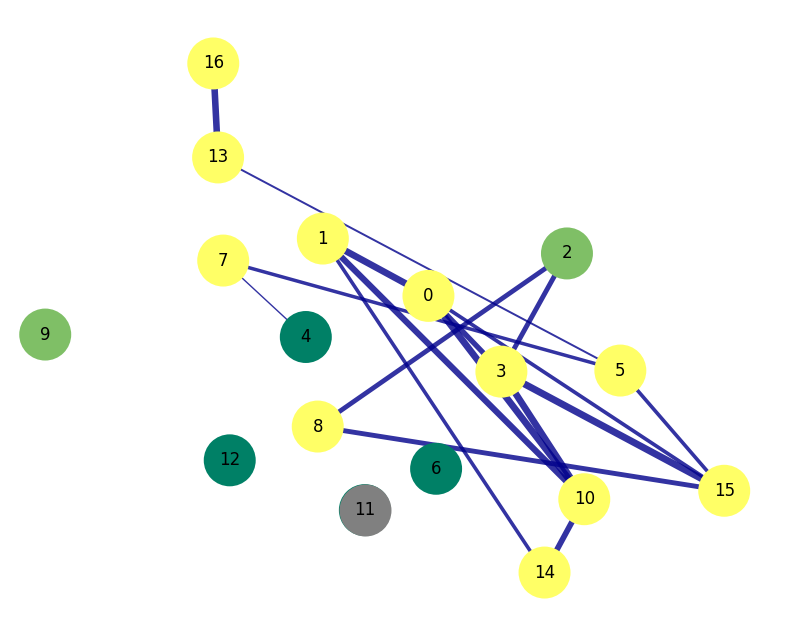


--- Eliminando nodo 12 ---
DEBUG removed=12: eps=1.0e-07, max_hat=4.89e-04, max_full_masked=7.59e-01
       edges_inferred=19, edges_gt_masked=19, mismatches_total=0
NMSE binarizada: 0.000000
Matriz reconstruida remapeada:
          0         1         2         3         4         5    6         7   \
0   0.000000  0.000477  0.000000  0.000405  0.000000  0.000000  0.0  0.000000   
1   0.000477  0.000000  0.000000  0.000000  0.000000  0.000000  0.0  0.000000   
2   0.000000  0.000000  0.000000  0.000385  0.000000  0.000000  0.0  0.000000   
3   0.000405  0.000000  0.000385  0.000000  0.000000  0.000000  0.0  0.000000   
4   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.0  0.000206   
5   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.0  0.000315   
6   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.0  0.000000   
7   0.000000  0.000000  0.000000  0.000000  0.000206  0.000315  0.0  0.000000   
8   0.000000  0.000000  0.000379  0.000000  0.0

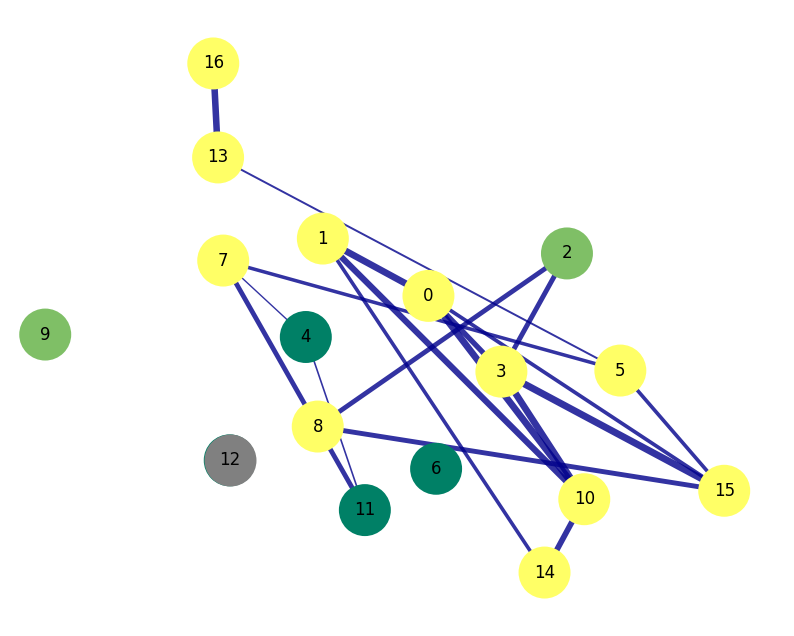


--- Eliminando nodo 13 ---
DEBUG removed=13: eps=1.0e-07, max_hat=5.68e-04, max_full_masked=7.59e-01
       edges_inferred=18, edges_gt_masked=18, mismatches_total=0
NMSE binarizada: 0.000000
Matriz reconstruida remapeada:
          0         1         2         3         4         5    6         7   \
0   0.000000  0.000554  0.000000  0.000471  0.000000  0.000000  0.0  0.000000   
1   0.000554  0.000000  0.000000  0.000000  0.000000  0.000000  0.0  0.000000   
2   0.000000  0.000000  0.000000  0.000448  0.000000  0.000000  0.0  0.000000   
3   0.000471  0.000000  0.000448  0.000000  0.000000  0.000000  0.0  0.000000   
4   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.0  0.000241   
5   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.0  0.000367   
6   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.0  0.000000   
7   0.000000  0.000000  0.000000  0.000000  0.000241  0.000367  0.0  0.000000   
8   0.000000  0.000000  0.000441  0.000000  0.0

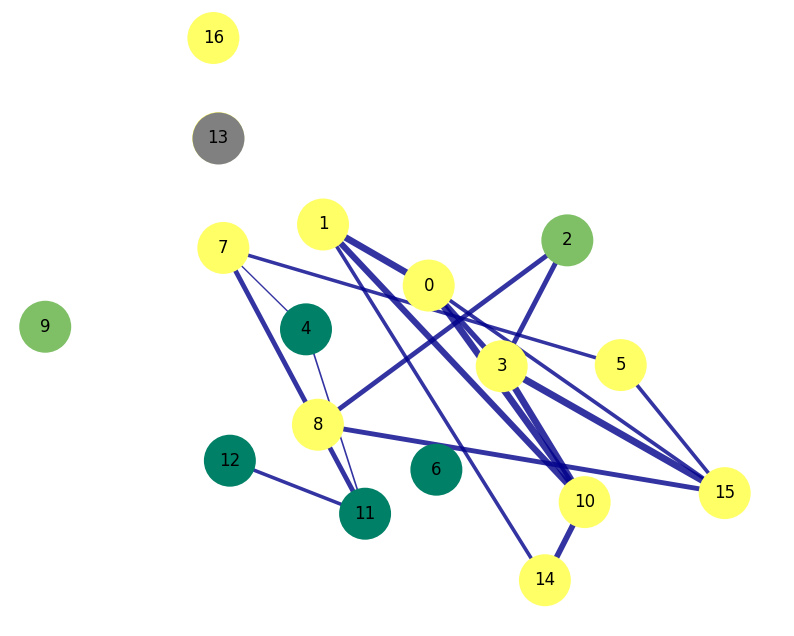


--- Eliminando nodo 14 ---
DEBUG removed=14: eps=1.0e-07, max_hat=5.27e-04, max_full_masked=7.59e-01
       edges_inferred=18, edges_gt_masked=18, mismatches_total=0
NMSE binarizada: 0.000000
Matriz reconstruida remapeada:
          0         1         2         3         4         5    6         7   \
0   0.000000  0.000514  0.000000  0.000437  0.000000  0.000000  0.0  0.000000   
1   0.000514  0.000000  0.000000  0.000000  0.000000  0.000000  0.0  0.000000   
2   0.000000  0.000000  0.000000  0.000416  0.000000  0.000000  0.0  0.000000   
3   0.000437  0.000000  0.000416  0.000000  0.000000  0.000000  0.0  0.000000   
4   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.0  0.000225   
5   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.0  0.000340   
6   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.0  0.000000   
7   0.000000  0.000000  0.000000  0.000000  0.000225  0.000340  0.0  0.000000   
8   0.000000  0.000000  0.000409  0.000000  0.0

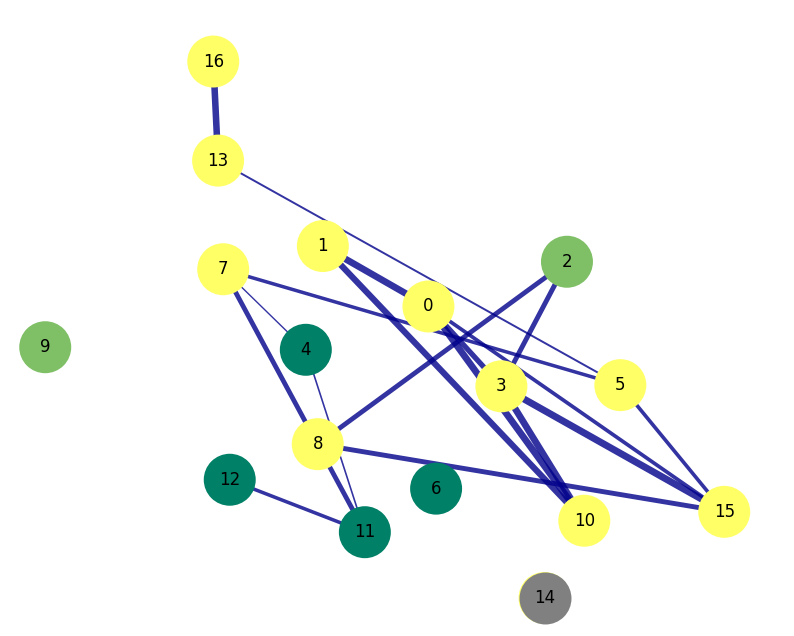


--- Eliminando nodo 15 ---
DEBUG removed=15: eps=1.0e-07, max_hat=4.80e-06, max_full_masked=7.47e-01
       edges_inferred=16, edges_gt_masked=16, mismatches_total=0
NMSE binarizada: 0.000000
Matriz reconstruida remapeada:
          0         1         2         3         4         5    6         7   \
0   0.000000  0.000005  0.000000  0.000004  0.000000  0.000000  0.0  0.000000   
1   0.000005  0.000000  0.000000  0.000000  0.000000  0.000000  0.0  0.000000   
2   0.000000  0.000000  0.000000  0.000004  0.000000  0.000000  0.0  0.000000   
3   0.000004  0.000000  0.000004  0.000000  0.000000  0.000000  0.0  0.000000   
4   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.0  0.000002   
5   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.0  0.000003   
6   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.0  0.000000   
7   0.000000  0.000000  0.000000  0.000000  0.000002  0.000003  0.0  0.000000   
8   0.000000  0.000000  0.000004  0.000000  0.0

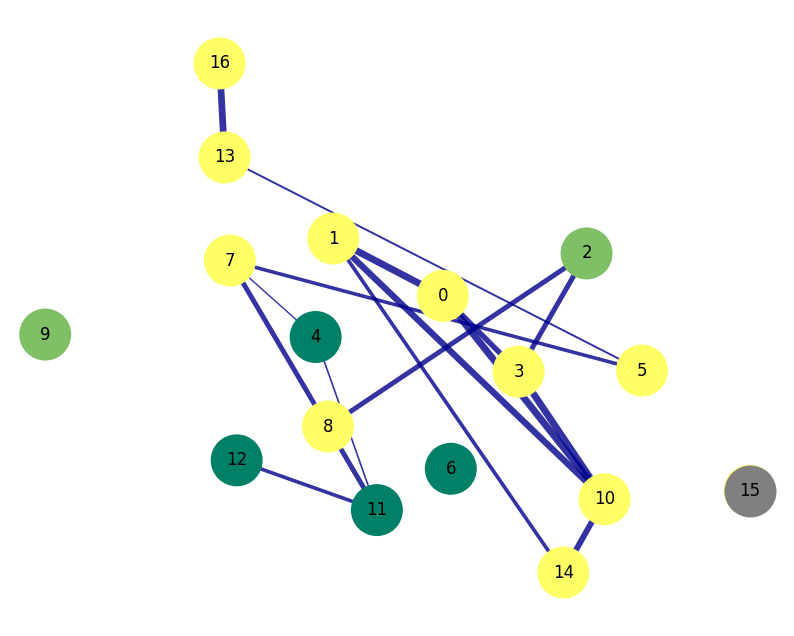


--- Eliminando nodo 16 ---
DEBUG removed=16: eps=1.0e-07, max_hat=4.56e-04, max_full_masked=7.59e-01
       edges_inferred=19, edges_gt_masked=19, mismatches_total=0
NMSE binarizada: 0.000000
Matriz reconstruida remapeada:
          0         1         2         3         4         5    6         7   \
0   0.000000  0.000445  0.000000  0.000378  0.000000  0.000000  0.0  0.000000   
1   0.000445  0.000000  0.000000  0.000000  0.000000  0.000000  0.0  0.000000   
2   0.000000  0.000000  0.000000  0.000360  0.000000  0.000000  0.0  0.000000   
3   0.000378  0.000000  0.000360  0.000000  0.000000  0.000000  0.0  0.000000   
4   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.0  0.000194   
5   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.0  0.000295   
6   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.0  0.000000   
7   0.000000  0.000000  0.000000  0.000000  0.000194  0.000295  0.0  0.000000   
8   0.000000  0.000000  0.000354  0.000000  0.0

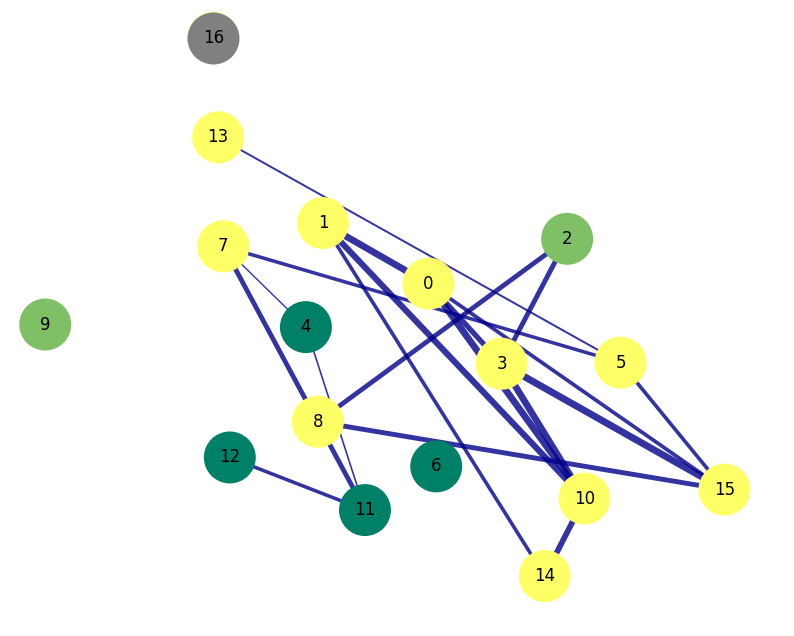


NMSE por nodo eliminado:
    node      nmse
0      0  0.000000
1      1  0.000000
2      2  0.000000
3      3  0.000000
4      4  0.000000
5      5  0.000000
6      6  0.000000
7      7  2.656845
8      8  0.000000
9      9  0.000000
10    10  0.000000
11    11  0.000000
12    12  0.000000
13    13  0.000000
14    14  0.000000
15    15  0.000000
16    16  0.000000
mean and median nmse: 0.15628497980119327 0.0


In [217]:
lambda_reg = 0.2         
epsilon    = 1e-7       
results = []

for s in range(N):
    print(f"\n--- Removing node  {s} ---")
    P = construct_P(N, s)
    A_tilde_small = evaluate_graph_stability_fast(A, X, P, lambda_reg, eps=1e-3)
    #A_tilde_small = evaluate_graph_stability(A, X, P, lambda_reg)

    nmse, A_hat_bin, A_full_bin = calculate_nmse_with_mask_and_binarize(A_tilde_small, A, s, eps=epsilon)
    print(f"NMSE binarized: {nmse:.6f}")
    results.append({'node': s, 'nmse': nmse})

    A_cont = remap_A_hat(A_tilde_small, s)
    W_recon_df = pd.DataFrame(A_cont)
    print("refinment matrix:")
    print(W_recon_df)

    pos_removed = tuple(coords[s]) 
    plot_graph_(
        W            = W_recon_df,
        df_info      = df,
        pos_removed  = pos_removed,
        removed_node = s,
        epsilon      = epsilon, 
        save_svg     = False,
        out_dir      = path, 
        filename     = f"graph_stable_glasso_drop{s}.svg", 
        show=True
    )

# 6) Resumen final
df_results = pd.DataFrame(results)
print("\nNMSE:")
print(df_results)
mean_nmse = df_results['nmse'].mean()
median_nmse = df_results['nmse'].median()
print("mean and median nmse:", mean_nmse, median_nmse)


### LOO node without refinement

In [108]:
def infer_graph_kalofolias_from_X(X, dist_type='correlation', alpha=0.1, beta=1.0):

    W_learned, _ = lg.log_degree_barrier(
        X, dist_type=dist_type,
        alpha=alpha, beta=beta,
        retall=True, verbosity='LOW'
    )
    return np.array(W_learned)

def infer_graph_glasso_from_X(X, tol_std_eps=1e-8, glasso_cv=10, max_iter=1000):

    # X shape: (N, F) -> transpose: (F, N) => samples=F, features=N
    datos2 = X.T.astype(float).copy()  # shape (F, N)
    datos2 /= datos2.std(axis=0)
    # fit model
    edge_model = covariance.GraphicalLassoCV(cv=glasso_cv, max_iter=max_iter, verbose=False, assume_centered=True)
    edge_model.fit(datos2)  
    precision_m = edge_model.precision_
    np.fill_diagonal(precision_m, 0.0)
    return precision_m

def knn_similarity_matrix_from_X(X, k=4, metric='cosine', symmetrize='mutual',
                                 weighted='gaussian', sigma='median', self_loops=False):
 
    Xn = normalize(np.asarray(X, float), norm='l2', axis=1)
    D = kneighbors_graph(Xn, n_neighbors=k, mode='distance',
                         metric=metric, include_self=self_loops, n_jobs=-1).tocsr()

    D = D.maximum(D.T) if symmetrize == 'union' else D.minimum(D.T)

    W = D.copy()
    if weighted == 'binary':
        W.data[:] = 1.0
    elif weighted == 'distance':
        W.data = 1.0 / (W.data + 1e-9)
    elif weighted == 'gaussian':
        d = W.data
        s = (np.median(d) if sigma == 'median' else float(sigma)) or 1.0
        if s == 0:
            s = 1.0
        W.data = np.exp(-(d**2)/(2*s**2))
    else:
        raise ValueError("weighted must be 'gaussian' | 'binary' | 'distance'")

    if not self_loops:
        W.setdiag(0.0); W.eliminate_zeros()

    A = W.toarray()
    np.fill_diagonal(A, 0.0)
    return A


#### loop execution

In [116]:
from pathlib import Path
from IPython.display import display


def run_leave_one_experiment(X, df_info,
                             method='kalofolias',
                             method_params=None,
                             thresholds=None,
                             glasso_use_partial_corr=False,
                             plot_each=False,
                             plot_eps=1e-4,
                             print_matrices=True,
                             save_figs=False,
                             out_dir="./graphs",
                             file_prefix="",
                             show_plots=False):
  
    if method_params is None:
        method_params = {}
    if thresholds is None:
        thresholds = {}

    N = X.shape[0]

    # --------- infer A_full_raw ----------
    if method == 'kalofolias':
        A_full_raw = infer_graph_kalofolias_from_X(X, **method_params.get('kalofolias', {}))
    elif method == 'glasso':
        prec_full = infer_graph_glasso_from_X(X, **method_params.get('glasso', {}))
        if glasso_use_partial_corr:
            A_full_raw = precision_to_partialcorr(prec_full)
        else:
            A_full_raw = np.abs(prec_full)
    elif method == 'knn':
        A_full_raw = knn_similarity_matrix_from_X(X, **method_params.get('knn', {}))
    else:
        raise ValueError("Again'")

    A_full_raw = np.array(A_full_raw, dtype=float)
    np.fill_diagonal(A_full_raw, 0.0)
    A_full_raw = 0.5 * (A_full_raw + A_full_raw.T)

    if method in thresholds and thresholds[method] is not None:
        chosen_thr = float(thresholds[method])
    else:
        if method == 'kalofolias':
            chosen_thr = 0.01
        elif method == 'glasso':
            chosen_thr = 0.31
        else:
            chosen_thr = 0.0

    if print_matrices:
        print(f"\n[Method={method}] chosen_threshold = {chosen_thr:.6e}")
        print("A_full (raw):")
        display(pd.DataFrame(np.round(A_full_raw, 6)).style.set_caption("A_full_raw"))


    saved_figs = []
    if save_figs:
        out_path = Path(out_dir)
        out_path.mkdir(parents=True, exist_ok=True)
    else:
        out_path = None

    results = []
    try:
        coords = same_posicion_data(df_info)
    except Exception:
        coords = None

    for s in range(N):
        print(f"\n--- {method} | removing node {s} ---")

        X_small = np.delete(X, s, axis=0)

        if method == 'kalofolias':
            Atil_small_raw = infer_graph_kalofolias_from_X(X_small, **method_params.get('kalofolias', {}))
        elif method == 'glasso':
            prec_small = infer_graph_glasso_from_X(X_small, **method_params.get('glasso', {}))
            if glasso_use_partial_corr:
                Atil_small_raw = precision_to_partialcorr(prec_small)
            else:
                Atil_small_raw = np.abs(prec_small)
        elif method == 'knn':
            Atil_small_raw = knn_similarity_matrix_from_X(X_small, **method_params.get('knn', {}))
        else:
            raise ValueError("method desconocido")

        Atil_small_raw = np.array(Atil_small_raw, dtype=float)

        # remap to NxN
        A_cont = remap_A_hat(Atil_small_raw, s)
        A_cont = 0.5 * (A_cont + A_cont.T)
        np.fill_diagonal(A_cont, 0.0)

        # trh to plot(kalofolias and glasso)
        if method in ('kalofolias', 'glasso'):
            A_full_plot = A_full_raw.copy()
            A_full_plot[np.abs(A_full_plot) < chosen_thr] = 0.0
            A_cont_plot = A_cont.copy()
            A_cont_plot[np.abs(A_cont_plot) < chosen_thr] = 0.0
        else:
            A_full_plot = A_full_raw.copy()
            A_cont_plot = A_cont.copy()

        if print_matrices:
            print("A_full umbralizada (para plot):")
            display(pd.DataFrame(np.round(A_full_plot, 6)).style.set_caption("A_full_plot"))
            print(f"A_cont remapeada umbralizada (node {s}) (para plot):")
            display(pd.DataFrame(np.round(A_cont_plot, 6)).style.set_caption(f"A_cont_plot_removed_{s}"))

        #  NMSE 
        if method in ('kalofolias', 'glasso'):
            eps_for_nmse = chosen_thr
        else:
            eps_for_nmse = 1e-8

        nmse, A_hat_bin, A_full_bin = calculate_nmse_with_mask_and_binarize(Atil_small_raw, A_full_raw, s, eps=eps_for_nmse)
        print(f"NMSE binarizada (eps={eps_for_nmse:.6e}) = {nmse}")

        if plot_each or save_figs:
            try:
                W_recon_df = pd.DataFrame(A_cont_plot)

                if file_prefix is None:
                    file_prefix = ""
                base_name = f"{file_prefix}{method}_node{s}.svg"

                links_e, svg_path = plot_graph_(
                    W=W_recon_df,
                    df_info=df_info,
                    pos_removed=(tuple(coords[s]) if coords is not None else None),
                    removed_node=s,
                    epsilon=plot_eps,
                    save_svg=False,
                    out_dir=str(out_path) if out_path is not None else None,
                    filename=base_name,
                    show=show_plots
                )

            
                if svg_path:
                    saved_figs.append(svg_path)

            except Exception as e:
                print("Error plot_graph_ (save/display):", e)

        results.append({'method': method, 'node': s, 'nmse': nmse})

    df_results = pd.DataFrame(results)
    return df_results, A_full_raw, saved_figs


In [118]:
svg_root = "/Images"

res_kalo, A_kalo, svg_paths_kalo = run_leave_one_experiment(
    X, df, method='kalofolias',
    method_params={'kalofolias':{'alpha':0.1,'beta':0.1}},
    thresholds={'kalofolias':0.01},
    plot_each=True,           
    save_figs=True,
    out_dir=svg_root,
    file_prefix="exp1_",
    show_plots=False,
    print_matrices=True
)
print("Saved:", svg_paths_kalo)



Solution found after 155 iterations:
    objective function f(sol) = 4.574058e+00
    stopping criterion: RTOL

[MÉTODO=kalofolias] chosen_threshold = 1.000000e-02
A_full (raw) — redondeada:



--- kalofolias | eliminando nodo 0 ---
Solution found after 80 iterations:
    objective function f(sol) = 4.548846e+00
    stopping criterion: RTOL
A_full umbralizada (para plot):


A_cont remapeada umbralizada (node 0) (para plot):


NMSE binarizada (eps=1.000000e-02) = 0.7977240352174656

--- kalofolias | eliminando nodo 1 ---
Solution found after 80 iterations:
    objective function f(sol) = 4.529501e+00
    stopping criterion: RTOL
A_full umbralizada (para plot):


A_cont remapeada umbralizada (node 1) (para plot):


NMSE binarizada (eps=1.000000e-02) = 0.6454972243679029

--- kalofolias | eliminando nodo 2 ---
Solution found after 68 iterations:
    objective function f(sol) = 4.539402e+00
    stopping criterion: RTOL
A_full umbralizada (para plot):


A_cont remapeada umbralizada (node 2) (para plot):


NMSE binarizada (eps=1.000000e-02) = 0.8164965809277261

--- kalofolias | eliminando nodo 3 ---
Solution found after 135 iterations:
    objective function f(sol) = 4.362457e+00
    stopping criterion: RTOL
A_full umbralizada (para plot):


A_cont remapeada umbralizada (node 3) (para plot):


NMSE binarizada (eps=1.000000e-02) = 0.6741998624632421

--- kalofolias | eliminando nodo 4 ---
Solution found after 90 iterations:
    objective function f(sol) = 4.434900e+00
    stopping criterion: RTOL
A_full umbralizada (para plot):


A_cont remapeada umbralizada (node 4) (para plot):


NMSE binarizada (eps=1.000000e-02) = 0.7071067811865476

--- kalofolias | eliminando nodo 5 ---
Solution found after 117 iterations:
    objective function f(sol) = 4.301424e+00
    stopping criterion: RTOL
A_full umbralizada (para plot):


A_cont remapeada umbralizada (node 5) (para plot):


NMSE binarizada (eps=1.000000e-02) = 0.42640143271122083

--- kalofolias | eliminando nodo 6 ---
Solution found after 101 iterations:
    objective function f(sol) = 4.224407e+00
    stopping criterion: RTOL
A_full umbralizada (para plot):


A_cont remapeada umbralizada (node 6) (para plot):


NMSE binarizada (eps=1.000000e-02) = 0.30151134457776363

--- kalofolias | eliminando nodo 7 ---
Solution found after 125 iterations:
    objective function f(sol) = 4.302912e+00
    stopping criterion: RTOL
A_full umbralizada (para plot):


A_cont remapeada umbralizada (node 7) (para plot):


NMSE binarizada (eps=1.000000e-02) = 0.31622776601683794

--- kalofolias | eliminando nodo 8 ---
Solution found after 80 iterations:
    objective function f(sol) = 4.521552e+00
    stopping criterion: RTOL
A_full umbralizada (para plot):


A_cont remapeada umbralizada (node 8) (para plot):


NMSE binarizada (eps=1.000000e-02) = 0.7071067811865476

--- kalofolias | eliminando nodo 9 ---
Solution found after 85 iterations:
    objective function f(sol) = 4.423630e+00
    stopping criterion: RTOL
A_full umbralizada (para plot):


A_cont remapeada umbralizada (node 9) (para plot):


NMSE binarizada (eps=1.000000e-02) = 0.6454972243679029

--- kalofolias | eliminando nodo 10 ---
Solution found after 98 iterations:
    objective function f(sol) = 4.359320e+00
    stopping criterion: RTOL
A_full umbralizada (para plot):


A_cont remapeada umbralizada (node 10) (para plot):


NMSE binarizada (eps=1.000000e-02) = 0.6324555320336759

--- kalofolias | eliminando nodo 11 ---
Solution found after 89 iterations:
    objective function f(sol) = 4.478420e+00
    stopping criterion: RTOL
A_full umbralizada (para plot):


A_cont remapeada umbralizada (node 11) (para plot):


NMSE binarizada (eps=1.000000e-02) = 0.6741998624632421

--- kalofolias | eliminando nodo 12 ---
Solution found after 123 iterations:
    objective function f(sol) = 4.314798e+00
    stopping criterion: RTOL
A_full umbralizada (para plot):


A_cont remapeada umbralizada (node 12) (para plot):


NMSE binarizada (eps=1.000000e-02) = 0.4082482904638631

--- kalofolias | eliminando nodo 13 ---
Solution found after 149 iterations:
    objective function f(sol) = 4.376823e+00
    stopping criterion: RTOL
A_full umbralizada (para plot):


A_cont remapeada umbralizada (node 13) (para plot):


NMSE binarizada (eps=1.000000e-02) = 0.5

--- kalofolias | eliminando nodo 14 ---
Solution found after 149 iterations:
    objective function f(sol) = 4.308601e+00
    stopping criterion: RTOL
A_full umbralizada (para plot):


A_cont remapeada umbralizada (node 14) (para plot):


NMSE binarizada (eps=1.000000e-02) = 0.4082482904638631

--- kalofolias | eliminando nodo 15 ---
Solution found after 117 iterations:
    objective function f(sol) = 4.343227e+00
    stopping criterion: RTOL
A_full umbralizada (para plot):


A_cont remapeada umbralizada (node 15) (para plot):


NMSE binarizada (eps=1.000000e-02) = 0.6454972243679029

--- kalofolias | eliminando nodo 16 ---
Solution found after 112 iterations:
    objective function f(sol) = 4.386989e+00
    stopping criterion: RTOL
A_full umbralizada (para plot):


A_cont remapeada umbralizada (node 16) (para plot):


NMSE binarizada (eps=1.000000e-02) = 0.5
Saved: ['/Users/mariajoseguerrero/Library/Mobile Documents/com~apple~CloudDocs/Documents/Universidad/PhD/Análisis métodos grafos/Paper ICASSP/Images/exp1_kalofolias_node0.svg', '/Users/mariajoseguerrero/Library/Mobile Documents/com~apple~CloudDocs/Documents/Universidad/PhD/Análisis métodos grafos/Paper ICASSP/Images/exp1_kalofolias_node1.svg', '/Users/mariajoseguerrero/Library/Mobile Documents/com~apple~CloudDocs/Documents/Universidad/PhD/Análisis métodos grafos/Paper ICASSP/Images/exp1_kalofolias_node2.svg', '/Users/mariajoseguerrero/Library/Mobile Documents/com~apple~CloudDocs/Documents/Universidad/PhD/Análisis métodos grafos/Paper ICASSP/Images/exp1_kalofolias_node3.svg', '/Users/mariajoseguerrero/Library/Mobile Documents/com~apple~CloudDocs/Documents/Universidad/PhD/Análisis métodos grafos/Paper ICASSP/Images/exp1_kalofolias_node4.svg', '/Users/mariajoseguerrero/Library/Mobile Documents/com~apple~CloudDocs/Documents/Universidad/PhD

/opt/anaconda3/envs/pyunlocbox-env/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:192: ConvergenceWarning: graphical_lasso: did not converge after 10000 iteration: dual gap: 6.495e-03
  warnings.warn(



--- glasso | eliminando nodo 0 ---
NMSE binarizada (eps=3.100000e-01) = 0.0


/opt/anaconda3/envs/pyunlocbox-env/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:192: ConvergenceWarning: graphical_lasso: did not converge after 10000 iteration: dual gap: 4.829e-03
  warnings.warn(


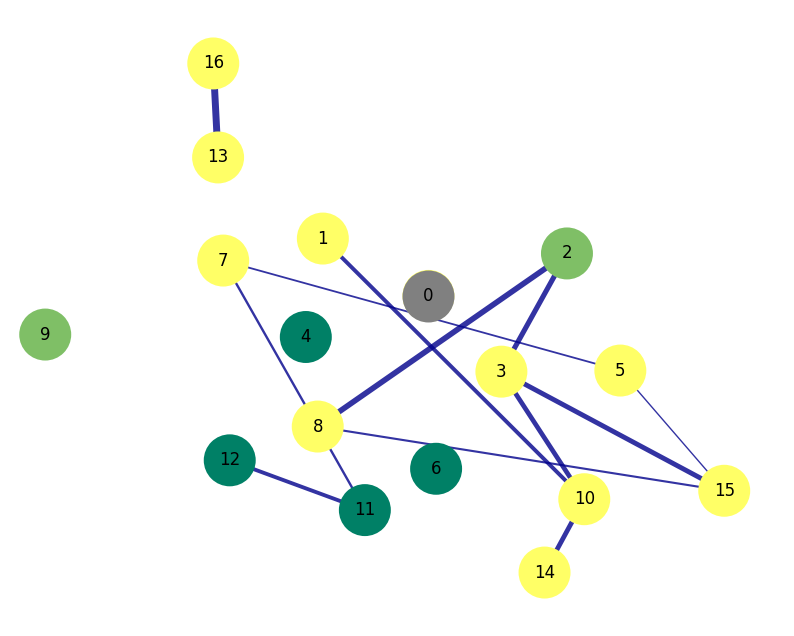


--- glasso | eliminando nodo 1 ---
NMSE binarizada (eps=3.100000e-01) = 0.2886751345948129


/opt/anaconda3/envs/pyunlocbox-env/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:192: ConvergenceWarning: graphical_lasso: did not converge after 10000 iteration: dual gap: 1.476e-03
  warnings.warn(


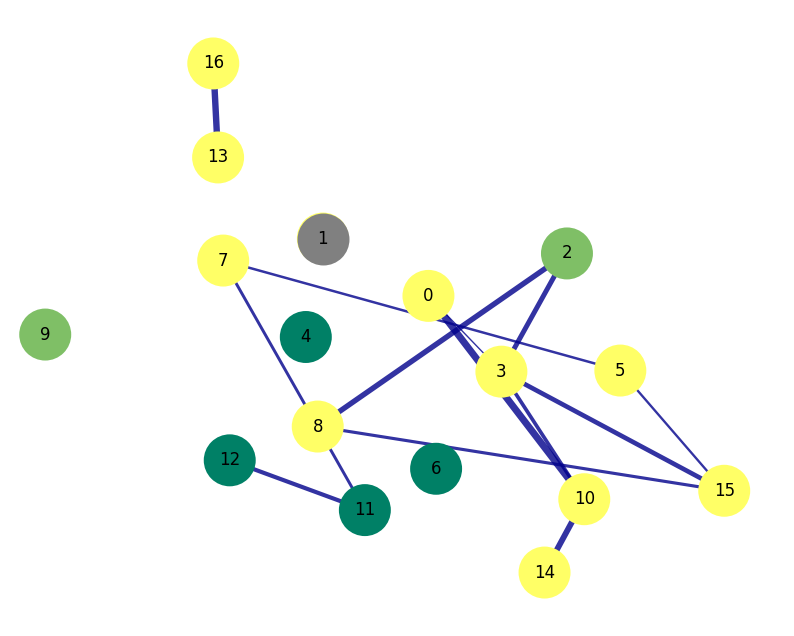


--- glasso | eliminando nodo 2 ---
NMSE binarizada (eps=3.100000e-01) = 0.5


/opt/anaconda3/envs/pyunlocbox-env/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:192: ConvergenceWarning: graphical_lasso: did not converge after 10000 iteration: dual gap: -4.547e-03
  warnings.warn(


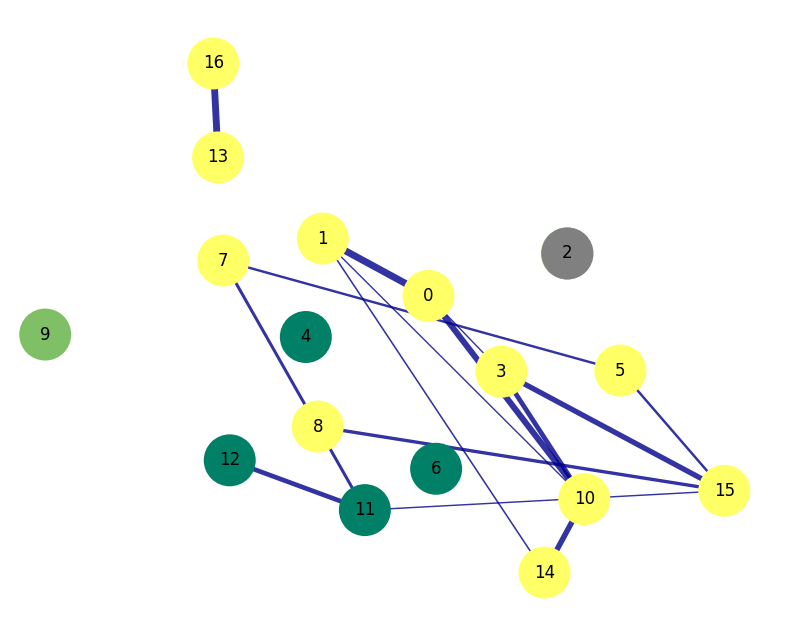


--- glasso | eliminando nodo 3 ---
NMSE binarizada (eps=3.100000e-01) = 0.0


/opt/anaconda3/envs/pyunlocbox-env/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:192: ConvergenceWarning: graphical_lasso: did not converge after 10000 iteration: dual gap: -3.815e-03
  warnings.warn(


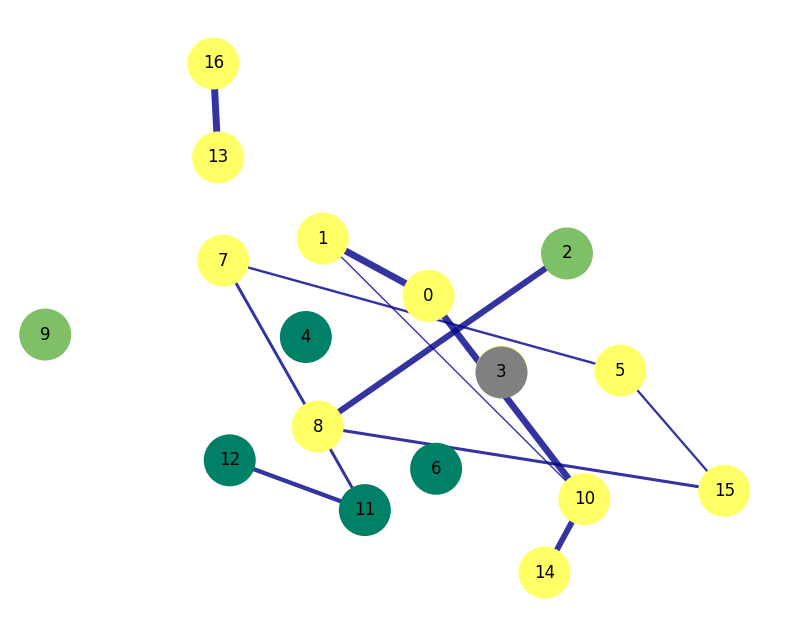


--- glasso | eliminando nodo 4 ---
NMSE binarizada (eps=3.100000e-01) = 0.0


/opt/anaconda3/envs/pyunlocbox-env/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:192: ConvergenceWarning: graphical_lasso: did not converge after 10000 iteration: dual gap: -1.061e-03
  warnings.warn(


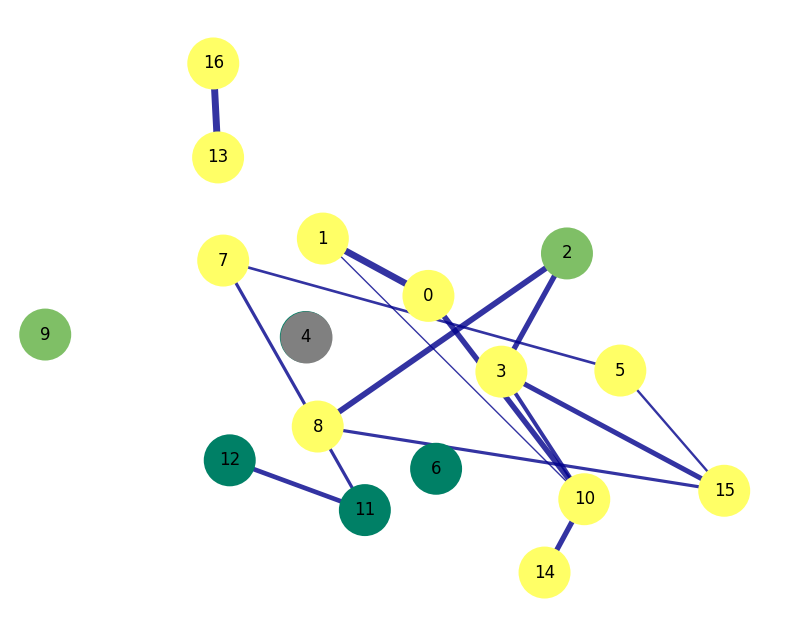


--- glasso | eliminando nodo 5 ---
NMSE binarizada (eps=3.100000e-01) = 0.0


/opt/anaconda3/envs/pyunlocbox-env/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:192: ConvergenceWarning: graphical_lasso: did not converge after 10000 iteration: dual gap: -3.416e-03
  warnings.warn(


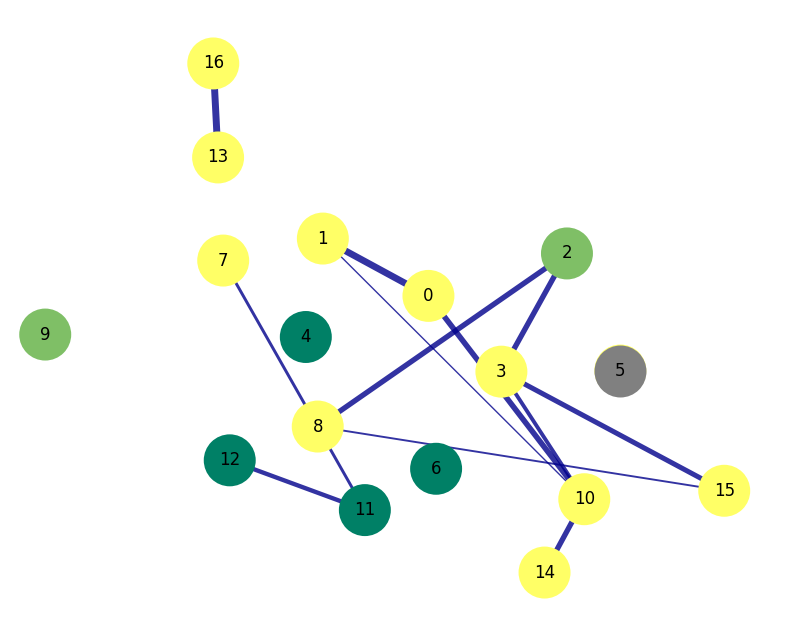


--- glasso | eliminando nodo 6 ---
NMSE binarizada (eps=3.100000e-01) = 0.2672612419124244


/opt/anaconda3/envs/pyunlocbox-env/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:192: ConvergenceWarning: graphical_lasso: did not converge after 10000 iteration: dual gap: 4.695e-03
  warnings.warn(


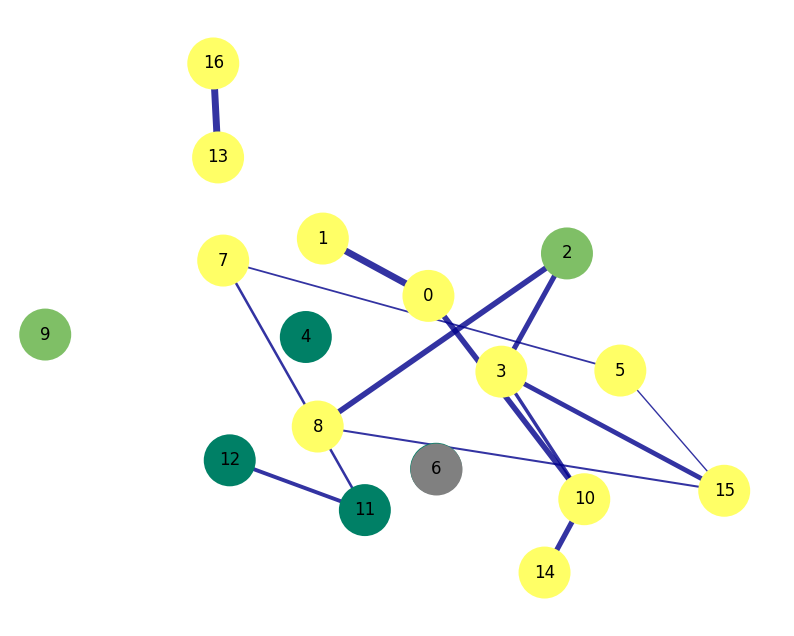


--- glasso | eliminando nodo 7 ---
NMSE binarizada (eps=3.100000e-01) = 0.2886751345948129


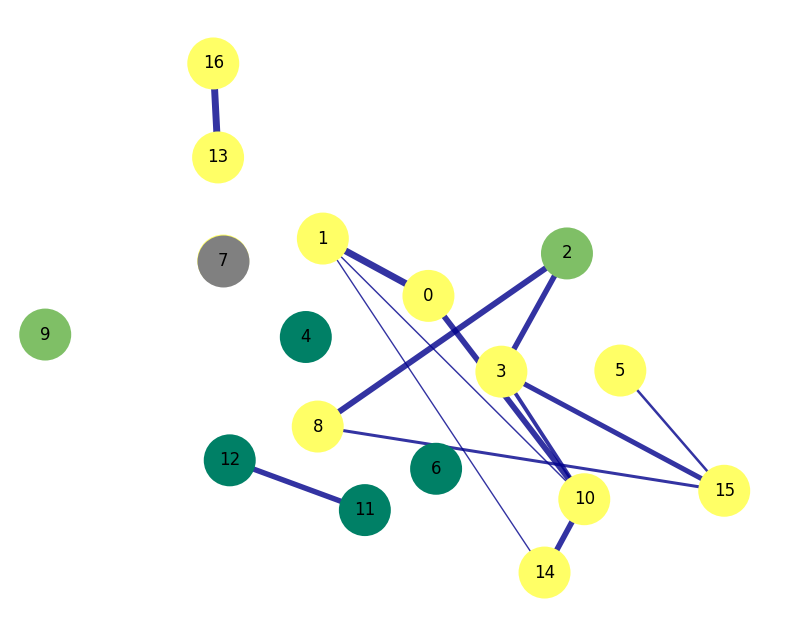


--- glasso | eliminando nodo 8 ---
NMSE binarizada (eps=3.100000e-01) = 0.2886751345948129


/opt/anaconda3/envs/pyunlocbox-env/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:192: ConvergenceWarning: graphical_lasso: did not converge after 10000 iteration: dual gap: 2.634e-03
  warnings.warn(


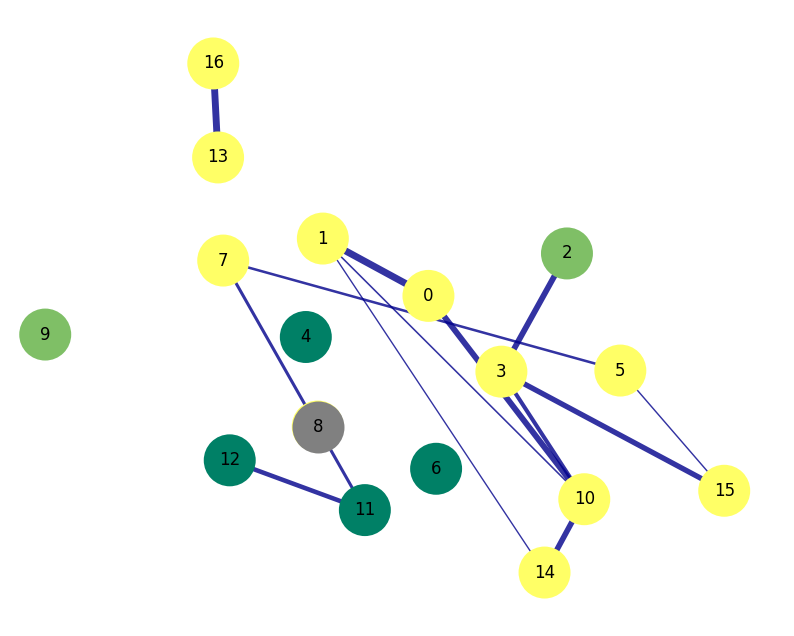


--- glasso | eliminando nodo 9 ---
NMSE binarizada (eps=3.100000e-01) = 0.2672612419124244


/opt/anaconda3/envs/pyunlocbox-env/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:192: ConvergenceWarning: graphical_lasso: did not converge after 10000 iteration: dual gap: 6.867e-03
  warnings.warn(


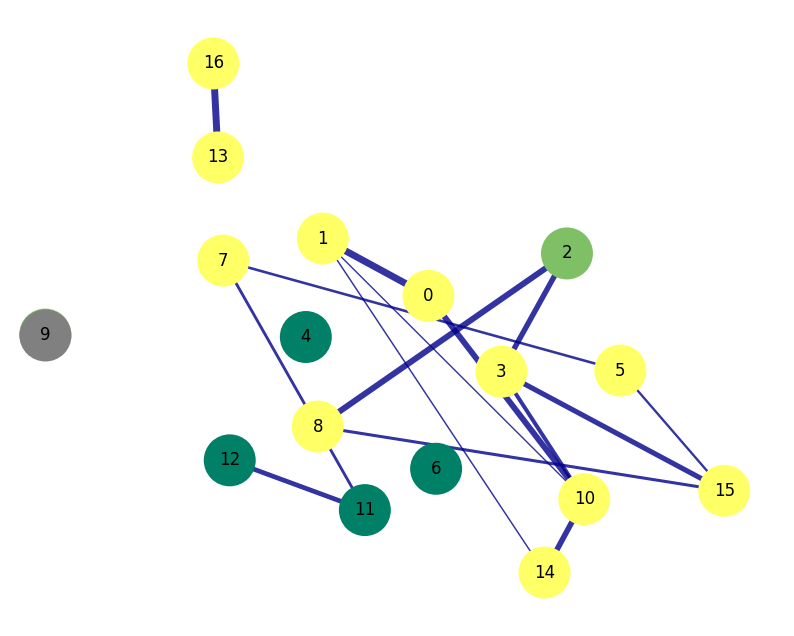


--- glasso | eliminando nodo 10 ---
NMSE binarizada (eps=3.100000e-01) = 0.4472135954999579


/opt/anaconda3/envs/pyunlocbox-env/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:192: ConvergenceWarning: graphical_lasso: did not converge after 10000 iteration: dual gap: -3.019e-03
  warnings.warn(


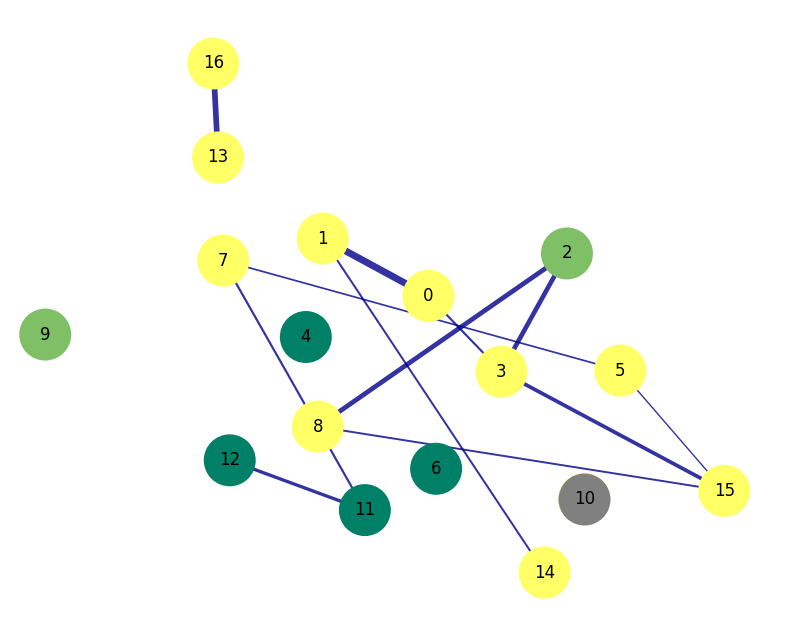


--- glasso | eliminando nodo 11 ---
NMSE binarizada (eps=3.100000e-01) = 0.5


/opt/anaconda3/envs/pyunlocbox-env/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:192: ConvergenceWarning: graphical_lasso: did not converge after 10000 iteration: dual gap: 4.283e-03
  warnings.warn(


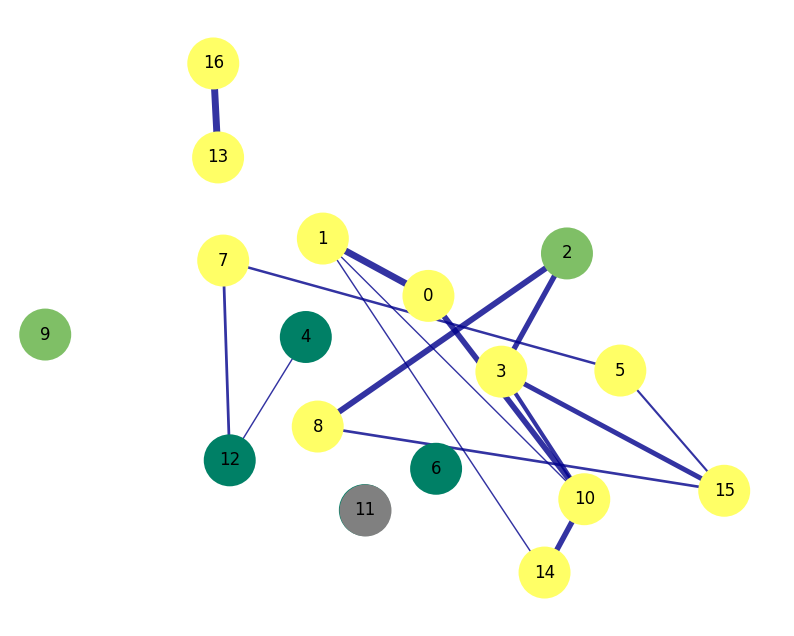


--- glasso | eliminando nodo 12 ---
NMSE binarizada (eps=3.100000e-01) = 0.0


/opt/anaconda3/envs/pyunlocbox-env/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:192: ConvergenceWarning: graphical_lasso: did not converge after 10000 iteration: dual gap: 3.277e-03
  warnings.warn(


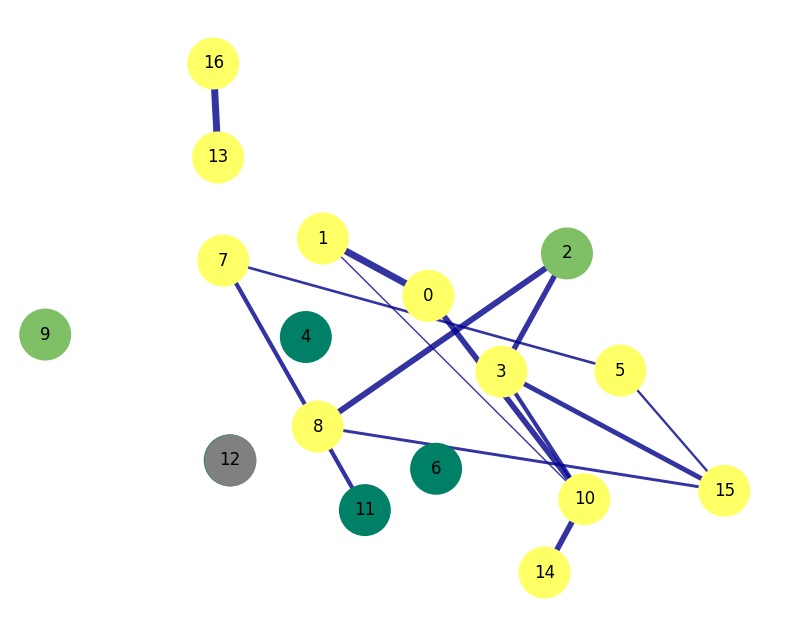


--- glasso | eliminando nodo 13 ---
NMSE binarizada (eps=3.100000e-01) = 0.2773500981126146


/opt/anaconda3/envs/pyunlocbox-env/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:192: ConvergenceWarning: graphical_lasso: did not converge after 10000 iteration: dual gap: 6.960e-03
  warnings.warn(


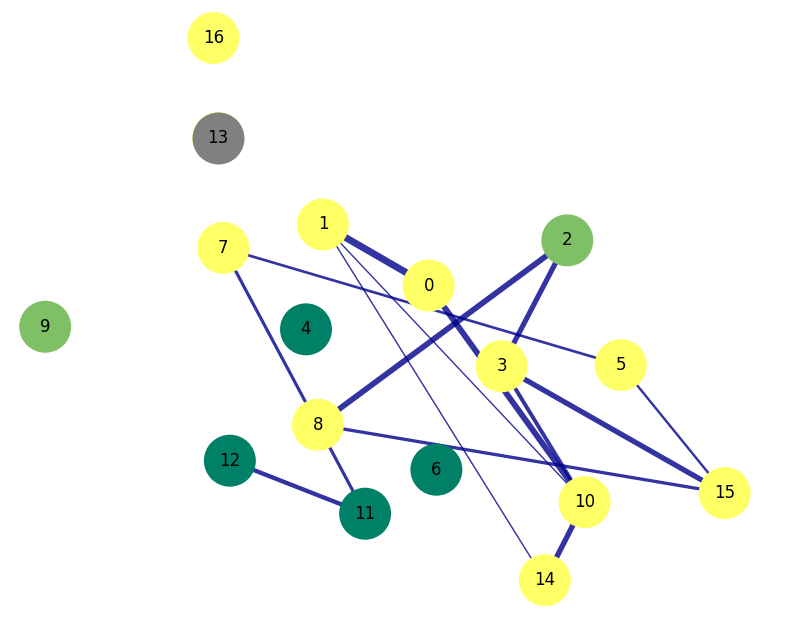


--- glasso | eliminando nodo 14 ---
NMSE binarizada (eps=3.100000e-01) = 0.0


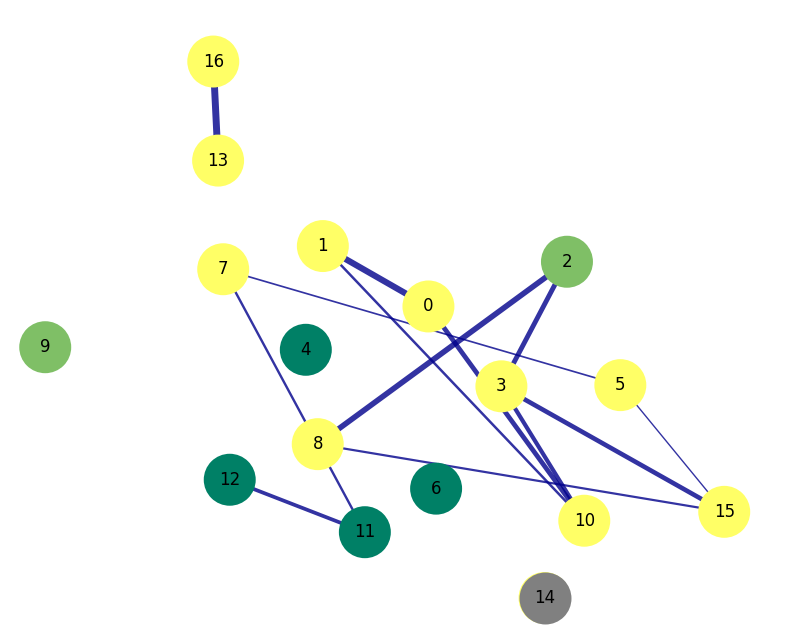


--- glasso | eliminando nodo 15 ---
NMSE binarizada (eps=3.100000e-01) = 0.42640143271122083


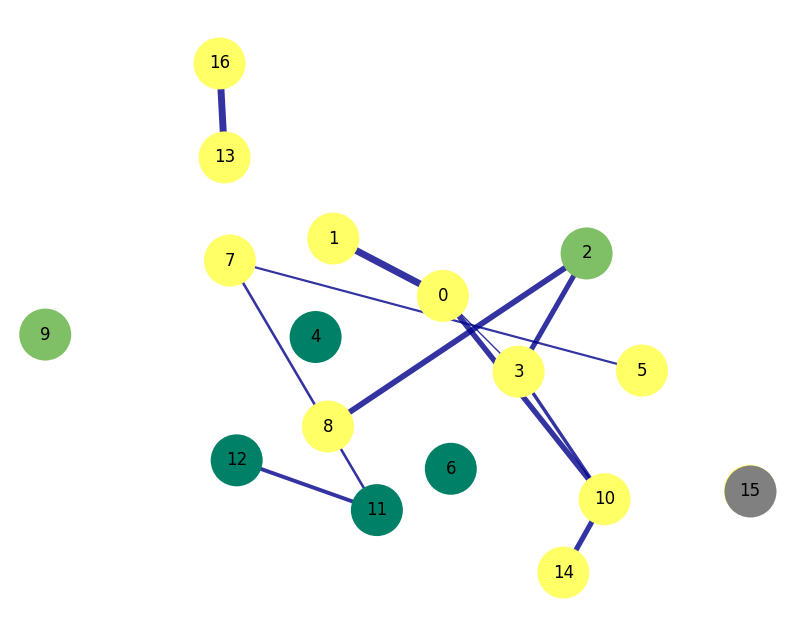


--- glasso | eliminando nodo 16 ---
NMSE binarizada (eps=3.100000e-01) = 0.2773500981126146


/opt/anaconda3/envs/pyunlocbox-env/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:192: ConvergenceWarning: graphical_lasso: did not converge after 10000 iteration: dual gap: 4.411e-03
  warnings.warn(


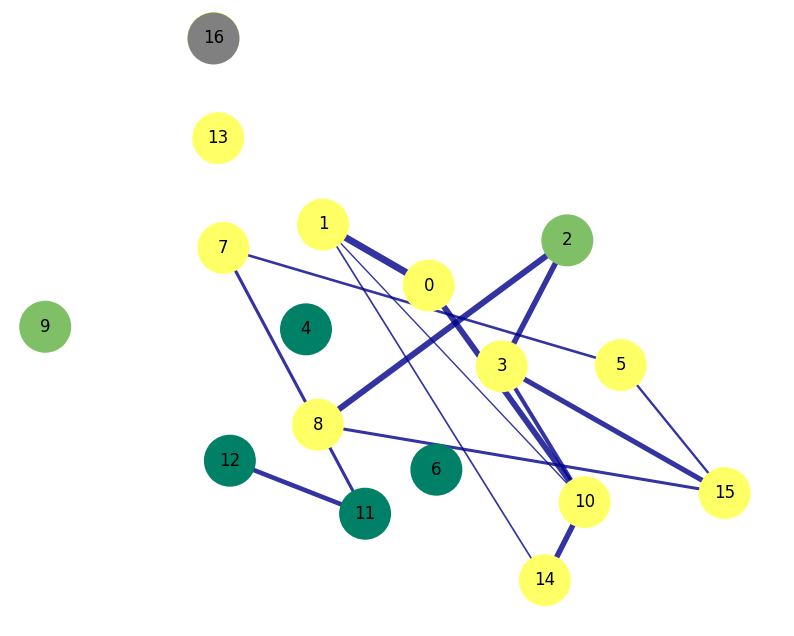

Saved: ['/Users/mariajoseguerrero/Library/Mobile Documents/com~apple~CloudDocs/Documents/Universidad/PhD/Análisis métodos grafos/Paper ICASSP/Images/exp1_glasso_node0.svg', '/Users/mariajoseguerrero/Library/Mobile Documents/com~apple~CloudDocs/Documents/Universidad/PhD/Análisis métodos grafos/Paper ICASSP/Images/exp1_glasso_node1.svg', '/Users/mariajoseguerrero/Library/Mobile Documents/com~apple~CloudDocs/Documents/Universidad/PhD/Análisis métodos grafos/Paper ICASSP/Images/exp1_glasso_node2.svg', '/Users/mariajoseguerrero/Library/Mobile Documents/com~apple~CloudDocs/Documents/Universidad/PhD/Análisis métodos grafos/Paper ICASSP/Images/exp1_glasso_node3.svg', '/Users/mariajoseguerrero/Library/Mobile Documents/com~apple~CloudDocs/Documents/Universidad/PhD/Análisis métodos grafos/Paper ICASSP/Images/exp1_glasso_node4.svg', '/Users/mariajoseguerrero/Library/Mobile Documents/com~apple~CloudDocs/Documents/Universidad/PhD/Análisis métodos grafos/Paper ICASSP/Images/exp1_glasso_no

In [120]:
res_glasso, A_glasso, svg_paths_glasso = run_leave_one_experiment(
    X, df, method='glasso',
    method_params={'glasso': {'glasso_cv': 10, 'max_iter': 10000}},
    thresholds={'glasso': 0.31},
    glasso_use_partial_corr=False, 
    plot_each=True,           
    save_figs=False,
    out_dir=svg_root,
    file_prefix="exp1_",
    show_plots=True,
    print_matrices=False
)
print("Saved:", svg_paths_glasso)


--- knn | eliminando nodo 0 ---
NMSE binarizada (eps=1.000000e-08) = 0.35355339059327373


/opt/anaconda3/envs/pyunlocbox-env/lib/python3.10/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/opt/anaconda3/envs/pyunlocbox-env/lib/python3.10/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


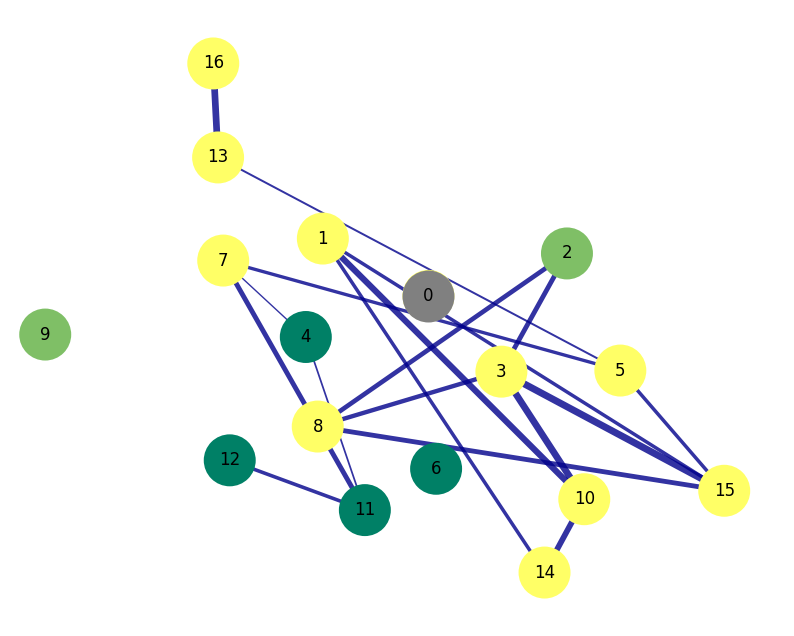

/opt/anaconda3/envs/pyunlocbox-env/lib/python3.10/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)



--- knn | eliminando nodo 1 ---
NMSE binarizada (eps=1.000000e-08) = 0.0


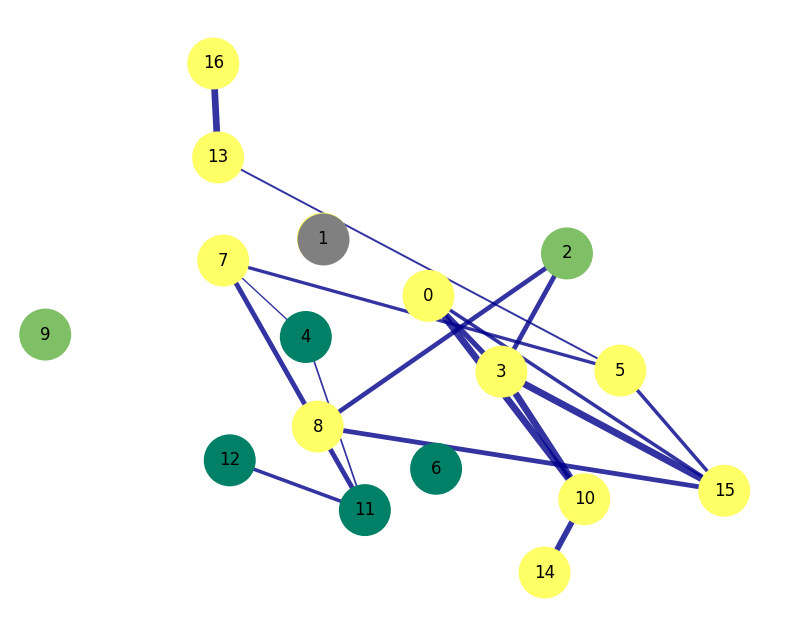


--- knn | eliminando nodo 2 ---
NMSE binarizada (eps=1.000000e-08) = 0.23570226039551587


/opt/anaconda3/envs/pyunlocbox-env/lib/python3.10/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


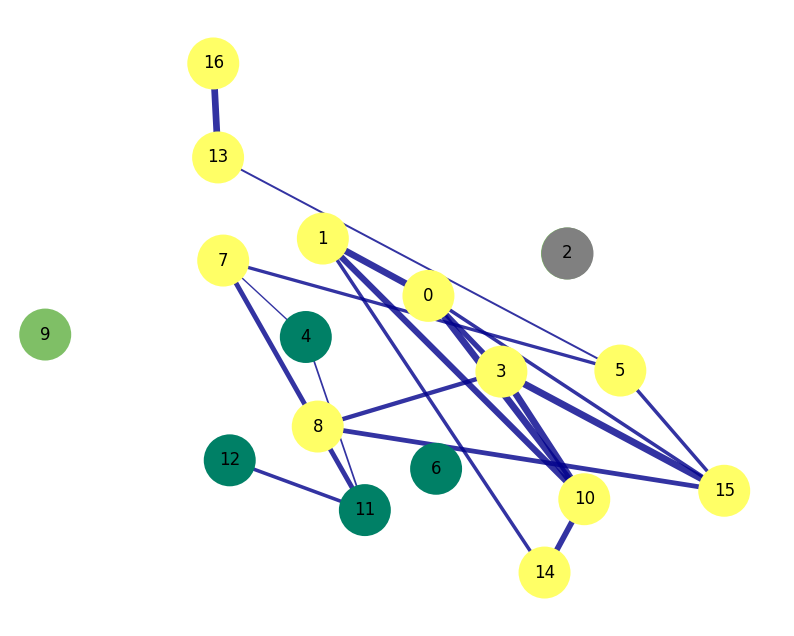


--- knn | eliminando nodo 3 ---
NMSE binarizada (eps=1.000000e-08) = 0.35355339059327373


/opt/anaconda3/envs/pyunlocbox-env/lib/python3.10/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


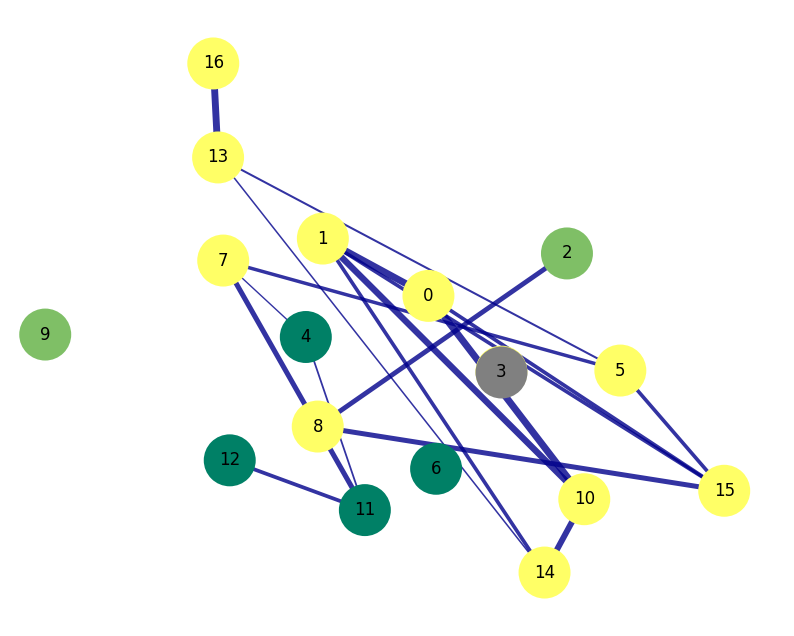


--- knn | eliminando nodo 4 ---
NMSE binarizada (eps=1.000000e-08) = 0.0


/opt/anaconda3/envs/pyunlocbox-env/lib/python3.10/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


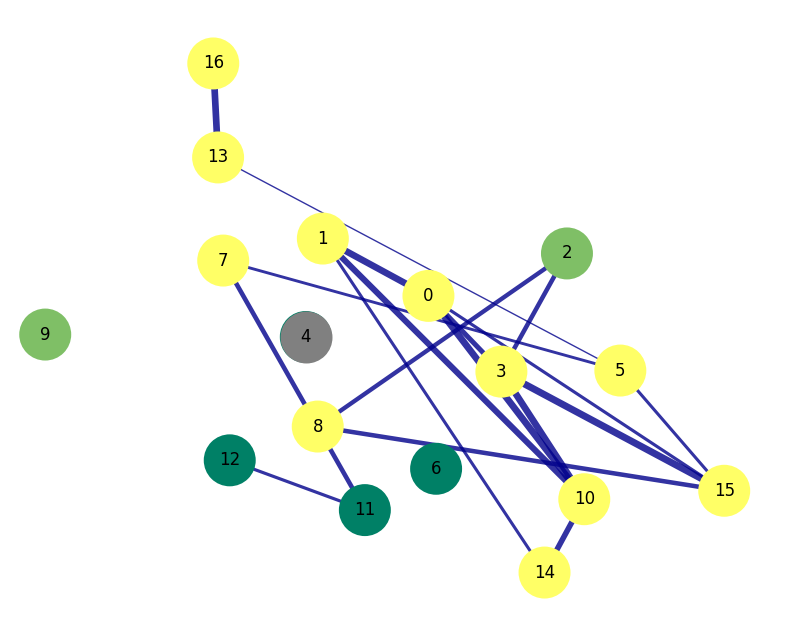


--- knn | eliminando nodo 5 ---
NMSE binarizada (eps=1.000000e-08) = 0.24253562503633297


/opt/anaconda3/envs/pyunlocbox-env/lib/python3.10/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


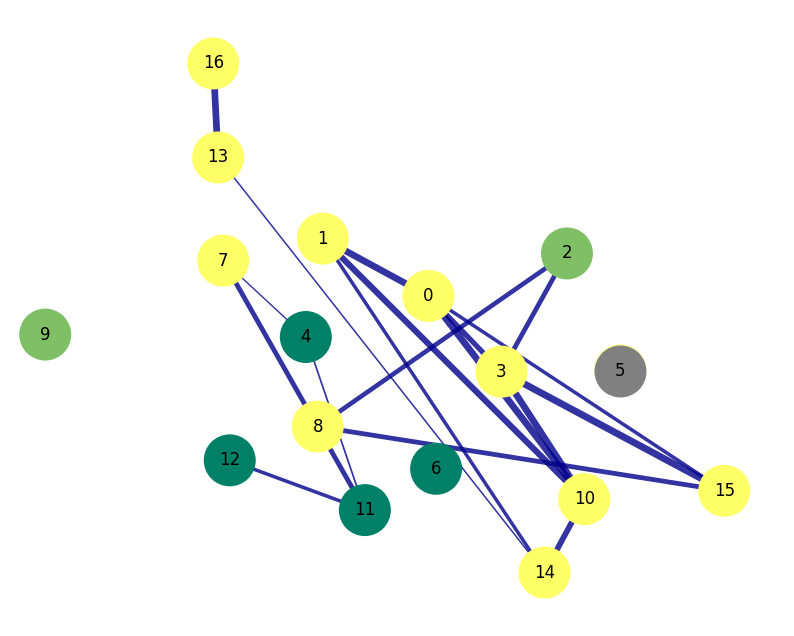


--- knn | eliminando nodo 6 ---


/opt/anaconda3/envs/pyunlocbox-env/lib/python3.10/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


NMSE binarizada (eps=1.000000e-08) = 0.0


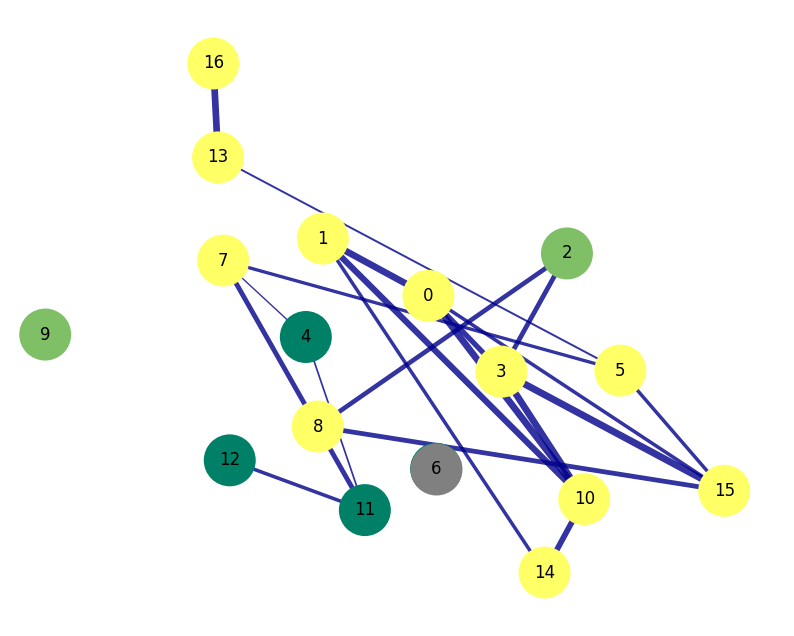


--- knn | eliminando nodo 7 ---
NMSE binarizada (eps=1.000000e-08) = 0.0


/opt/anaconda3/envs/pyunlocbox-env/lib/python3.10/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


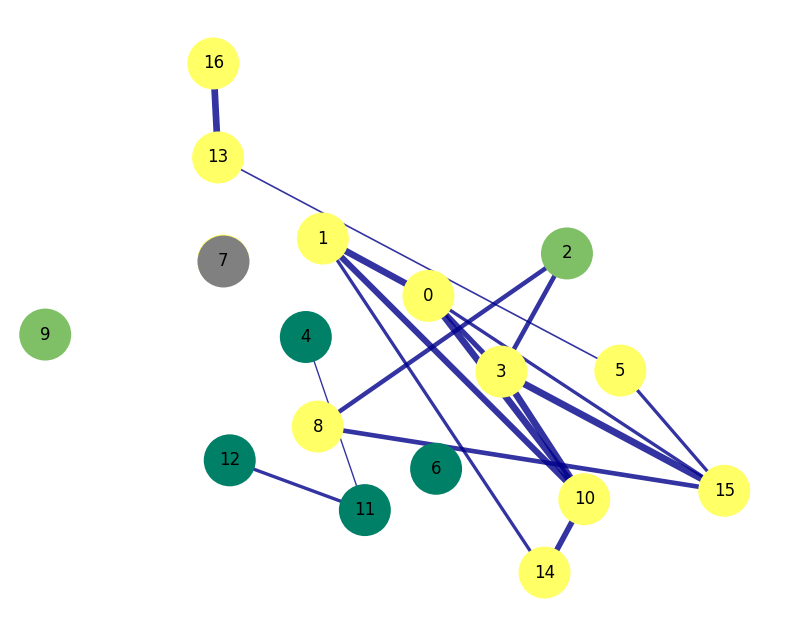


--- knn | eliminando nodo 8 ---
NMSE binarizada (eps=1.000000e-08) = 0.0


/opt/anaconda3/envs/pyunlocbox-env/lib/python3.10/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


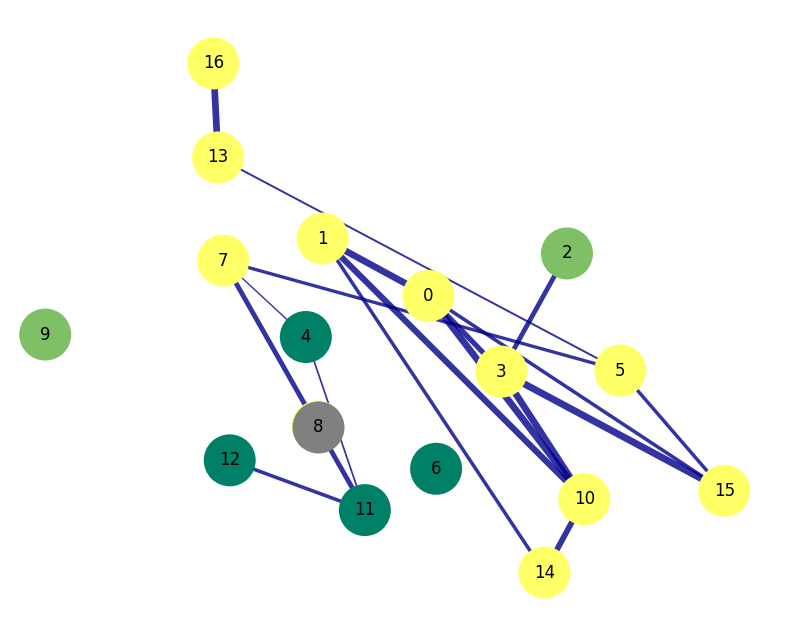


--- knn | eliminando nodo 9 ---
NMSE binarizada (eps=1.000000e-08) = 0.0


/opt/anaconda3/envs/pyunlocbox-env/lib/python3.10/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


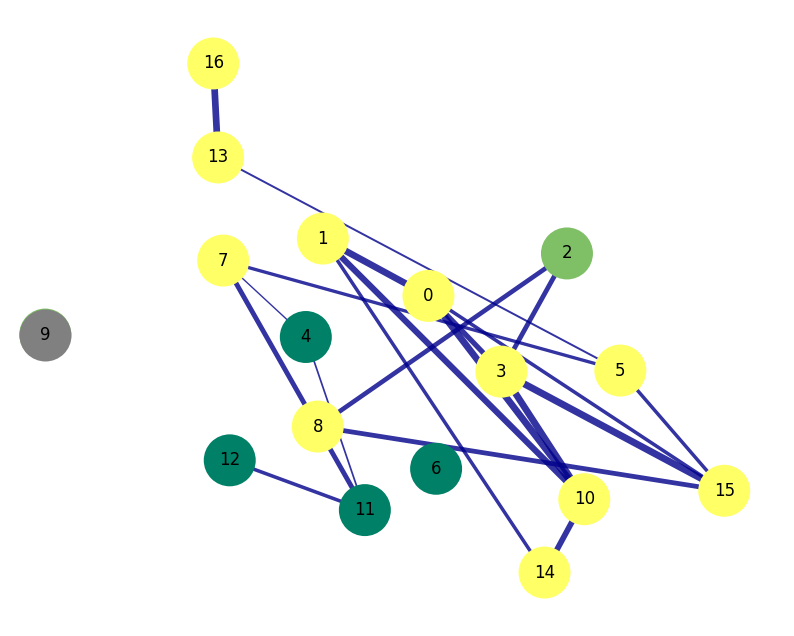


--- knn | eliminando nodo 10 ---
NMSE binarizada (eps=1.000000e-08) = 0.25


/opt/anaconda3/envs/pyunlocbox-env/lib/python3.10/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


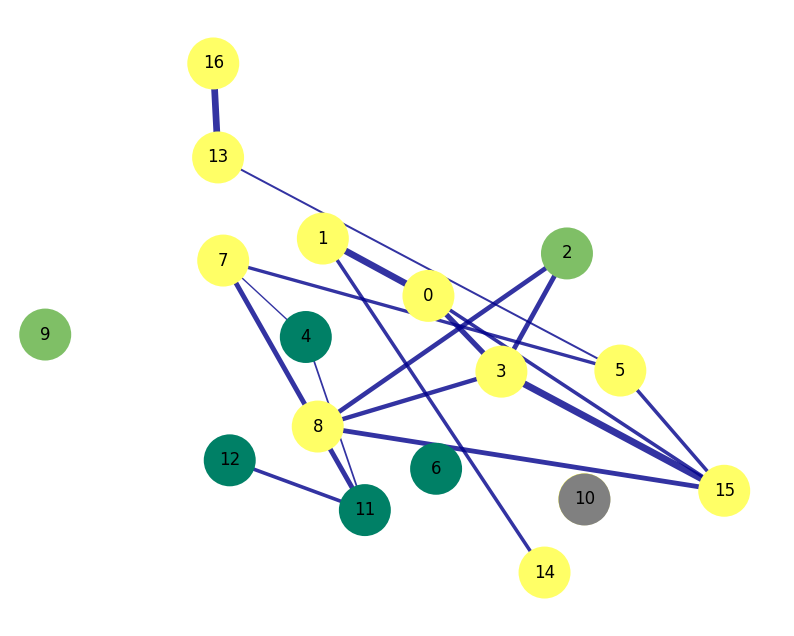


--- knn | eliminando nodo 11 ---
NMSE binarizada (eps=1.000000e-08) = 0.0


/opt/anaconda3/envs/pyunlocbox-env/lib/python3.10/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


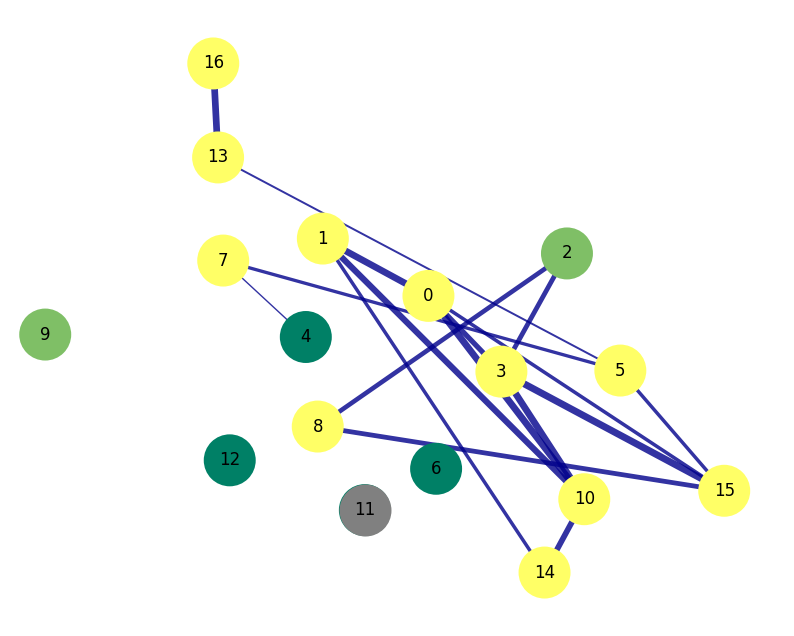


--- knn | eliminando nodo 12 ---
NMSE binarizada (eps=1.000000e-08) = 0.0


/opt/anaconda3/envs/pyunlocbox-env/lib/python3.10/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


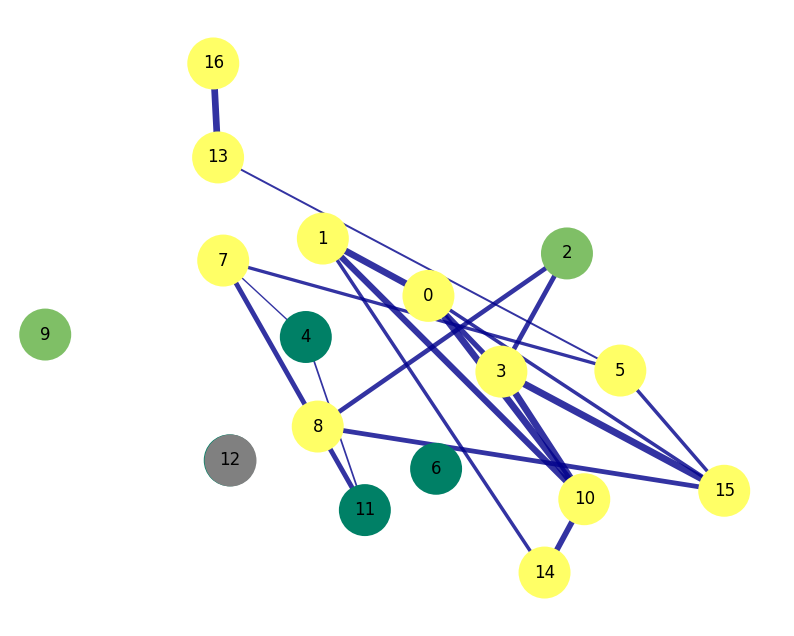


--- knn | eliminando nodo 13 ---
NMSE binarizada (eps=1.000000e-08) = 0.0


/opt/anaconda3/envs/pyunlocbox-env/lib/python3.10/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


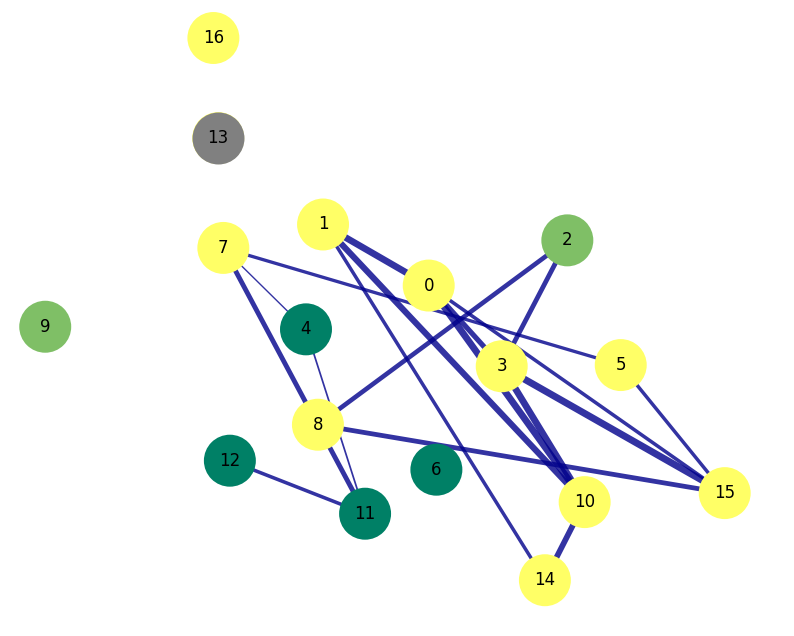


--- knn | eliminando nodo 14 ---
NMSE binarizada (eps=1.000000e-08) = 0.0


/opt/anaconda3/envs/pyunlocbox-env/lib/python3.10/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


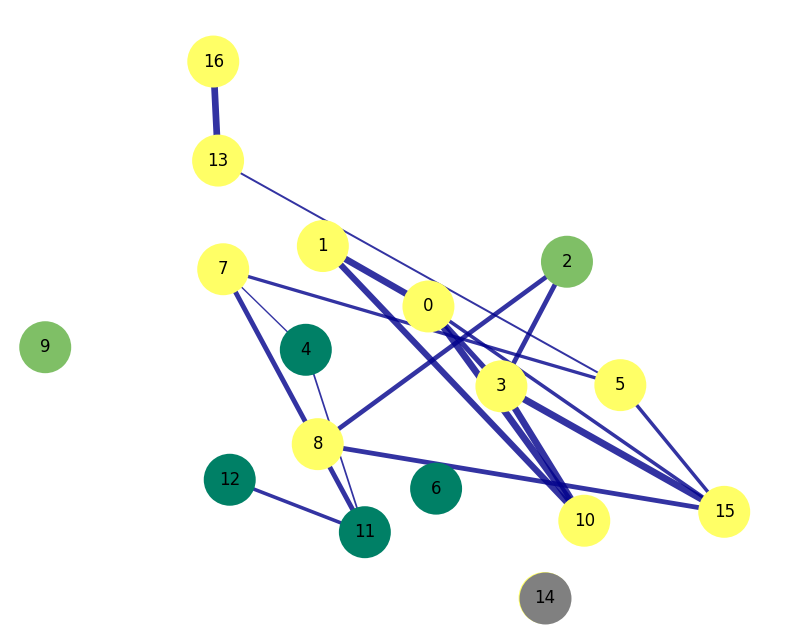

/opt/anaconda3/envs/pyunlocbox-env/lib/python3.10/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)



--- knn | eliminando nodo 15 ---
NMSE binarizada (eps=1.000000e-08) = 0.35355339059327373


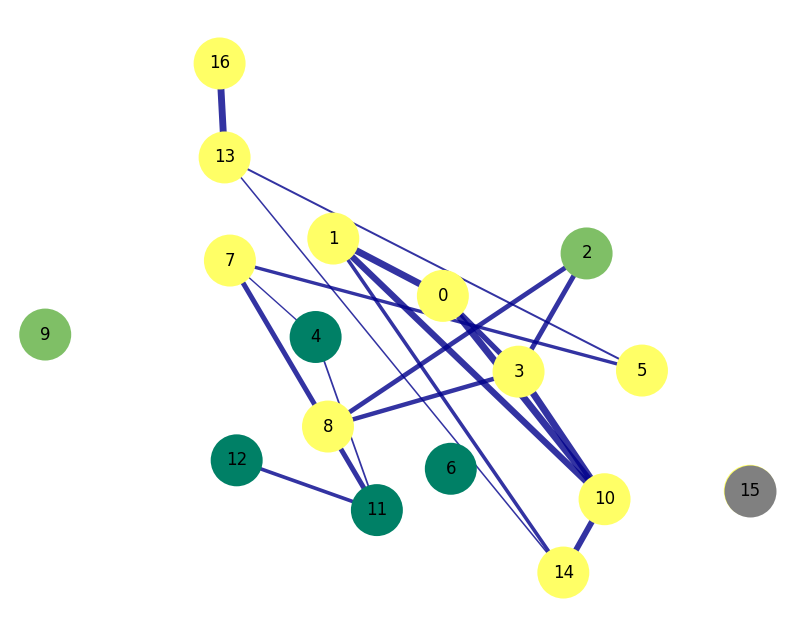


--- knn | eliminando nodo 16 ---
NMSE binarizada (eps=1.000000e-08) = 0.2294157338705618


/opt/anaconda3/envs/pyunlocbox-env/lib/python3.10/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


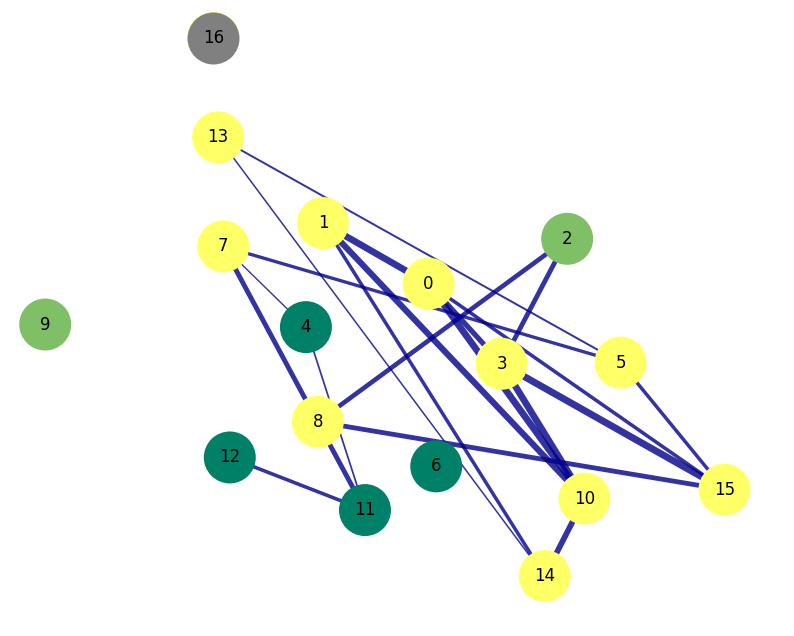

Saved: ['/Users/mariajoseguerrero/Library/Mobile Documents/com~apple~CloudDocs/Documents/Universidad/PhD/Análisis métodos grafos/Paper ICASSP/Images/exp1_knn_node0.svg', '/Users/mariajoseguerrero/Library/Mobile Documents/com~apple~CloudDocs/Documents/Universidad/PhD/Análisis métodos grafos/Paper ICASSP/Images/exp1_knn_node1.svg', '/Users/mariajoseguerrero/Library/Mobile Documents/com~apple~CloudDocs/Documents/Universidad/PhD/Análisis métodos grafos/Paper ICASSP/Images/exp1_knn_node2.svg', '/Users/mariajoseguerrero/Library/Mobile Documents/com~apple~CloudDocs/Documents/Universidad/PhD/Análisis métodos grafos/Paper ICASSP/Images/exp1_knn_node3.svg', '/Users/mariajoseguerrero/Library/Mobile Documents/com~apple~CloudDocs/Documents/Universidad/PhD/Análisis métodos grafos/Paper ICASSP/Images/exp1_knn_node4.svg', '/Users/mariajoseguerrero/Library/Mobile Documents/com~apple~CloudDocs/Documents/Universidad/PhD/Análisis métodos grafos/Paper ICASSP/Images/exp1_knn_node5.svg', '/Users/

In [121]:
res_knn, A_knn, svg_paths_knn = run_leave_one_experiment(
    X, df, method='knn',
    method_params={'knn': {'k': 4, 'metric': 'cosine', 'symmetrize': 'mutual', 'weighted': 'gaussian', 'sigma': 'median'}},
    thresholds={'knn': None},
    glasso_use_partial_corr=False, 
    plot_each=True,           
    save_figs=False,
    out_dir=svg_root,
    file_prefix="exp1_",
    show_plots=True,
    print_matrices=False
)
print("Saved:", svg_paths_knn)

### Raw Results

In [140]:
df_all = pd.concat([res_kalo, res_glasso, res_knn], ignore_index=True)
print("\nResumen NMSE por método y nodo:")
print(df_all.pivot_table(index='node', columns='method', values='nmse'))


Resumen NMSE por método y nodo:
method    glasso  kalofolias       knn
node                                  
0       0.000000    0.797724  0.353553
1       0.288675    0.645497  0.000000
2       0.500000    0.816497  0.235702
3       0.000000    0.674200  0.353553
4       0.000000    0.707107  0.000000
5       0.000000    0.426401  0.242536
6       0.267261    0.301511  0.000000
7       0.288675    0.316228  0.000000
8       0.288675    0.707107  0.000000
9       0.267261    0.645497  0.000000
10      0.447214    0.632456  0.250000
11      0.500000    0.674200  0.000000
12      0.000000    0.408248  0.000000
13      0.277350    0.500000  0.000000
14      0.000000    0.408248  0.000000
15      0.426401    0.645497  0.353553
16      0.277350    0.500000  0.229416
